In [11]:
from __future__ import print_function
import numpy as np # Biblioteca de funciones matematicas de alto nivel
np.random.seed(1337)  # for reproducibility
#import tensorflow as tf
#import keras  
import pandas as pd

In [12]:
dataset = pd.read_csv('train_data2.csv', encoding = "ISO-8859-1") # lectura de datos 2019 
dataset1 = pd.read_csv('test_data2018.csv', encoding = "ISO-8859-1") # lectura de datos Victor
dataset2 = pd.read_csv('validation_data2018.csv', encoding = "ISO-8859-1") # lectura de datos Victor

In [13]:
#Extra check, but we drop inf and nan after 

dataset.replace([np.inf, -np.inf], -1, inplace=True) 
dataset.replace([np.nan, -np.nan], -1, inplace=True)

dataset1.replace([np.inf, -np.inf], -1, inplace=True) 
dataset1.replace([np.nan, -np.nan], -1, inplace=True)

dataset2.replace([np.inf, -np.inf], -1, inplace=True) 
dataset2.replace([np.nan, -np.nan], -1, inplace=True)

In [14]:
# Convert numeric dataset columns to Float

numeric_columns = dataset.select_dtypes(include=['int64', 'float64']).columns
for column in numeric_columns:
    dataset[column] = dataset[column].astype(float)

numeric_columns1 = dataset1.select_dtypes(include=['int64', 'float64']).columns
for column in numeric_columns1:
    dataset1[column] = dataset1[column].astype(float)

numeric_columns1 = dataset2.select_dtypes(include=['int64', 'float64']).columns
for column in numeric_columns1:
    dataset2[column] = dataset2[column].astype(float)

In [16]:
# Mapeo de etiquetas
mapping = {
    'DoS attacks-GoldenEye': 'DoS',
    'DoS attacks-Hulk': 'DoS',
    'DoS attacks-SlowHTTPTest': 'DoS',
    'DoS attacks-Slowloris': 'DoS',
    'DrDoS_DNS': 'DoS',
    'DrDoS_LDAP': 'DoS',
    'DrDoS_MSSQL': 'DoS',
    'DrDoS_NTP': 'DoS',
    'DrDoS_NetBIOS': 'DoS',
    'DrDoS_SNMP': 'DoS',
    'DrDoS_SSDP': 'DoS',
    'DrDoS_UDP': 'DoS',
    # Mapear todas las variantes de benign a BENIGN
    'benign': 'BENIGN',
    'Benign': 'BENIGN',
    'BENIGN': 'BENIGN',
    'Normal': 'BENIGN',
    'normal': 'BENIGN',
    # Agrega otros mapeos si es necesario
}

# Función para mapear etiquetas
def map_labels(label_series):
    return label_series.map(mapping).fillna(label_series)

# Aplicar el mapeo a cada conjunto de datos
dataset['Label'] = map_labels(dataset['Label'])
dataset1['Label'] = map_labels(dataset1['Label'])
dataset2['Label'] = map_labels(dataset2['Label'])

# Verificar el mapeo
print("Etiquetas únicas después del mapeo:")
print("Dataset train:", sorted(dataset['Label'].unique()))
print("Dataset test:", sorted(dataset1['Label'].unique()))
print("Dataset validation:", sorted(dataset2['Label'].unique()))

# Contar las etiquetas después del mapeo
print("\nConteo de etiquetas en train:")
print(dataset['Label'].value_counts())
print("\nConteo de etiquetas en test:")
print(dataset1['Label'].value_counts())
print("\nConteo de etiquetas en validation:")
print(dataset2['Label'].value_counts())

Etiquetas únicas después del mapeo:
Dataset train: ['BENIGN', 'DoS', 'LDAP', 'MSSQL', 'NetBIOS', 'Portmap', 'Syn', 'TFTP', 'UDP', 'UDPLag']
Dataset test: ['BENIGN', 'DoS', 'FTP-BruteForce', 'SSH-Bruteforce']
Dataset validation: ['BENIGN', 'DoS', 'FTP-BruteForce', 'SSH-Bruteforce']

Conteo de etiquetas en train:
Label
DoS        637499
LDAP        79828
BENIGN      79775
UDP         79745
Syn         79734
TFTP        79732
NetBIOS     79678
UDPLag      79601
MSSQL       79498
Portmap     79463
Name: count, dtype: int64

Conteo de etiquetas en test:
Label
DoS               42498
BENIGN            32391
FTP-BruteForce    15138
SSH-Bruteforce    11965
Name: count, dtype: int64

Conteo de etiquetas en validation:
Label
DoS               25300
BENIGN            15548
FTP-BruteForce     6542
SSH-Bruteforce     5825
Name: count, dtype: int64


In [17]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Usar el nombre de la columna correcto
Labels = dataset['Label'].unique()
Y_train = dataset["Label"]
Y_test = dataset1["Label"]
Y_validation = dataset2["Label"]

# Combinar todas las etiquetas
all_labels = np.concatenate([Y_train, Y_test, Y_validation])

# Ajustar LabelEncoder con todas las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Codificar las etiquetas en cada conjunto
Y_train_encoded = label_encoder.transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)
Y_validation_encoded = label_encoder.transform(Y_validation)

# Para referencia, imprimir la correspondencia de etiquetas
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'BENIGN': 0, 'DoS': 1, 'FTP-BruteForce': 2, 'LDAP': 3, 'MSSQL': 4, 'NetBIOS': 5, 'Portmap': 6, 'SSH-Bruteforce': 7, 'Syn': 8, 'TFTP': 9, 'UDP': 10, 'UDPLag': 11}


In [19]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

# Separar las características y las etiquetas PRIMERO
X_train = dataset.drop('Label', axis=1)
X_test = dataset1.drop('Label', axis=1)
X_validation = dataset2.drop('Label', axis=1)

# Obtener las columnas del conjunto de entrenamiento
train_columns = X_train.columns.tolist()

# Asegurar que los conjuntos de prueba y validación tengan las mismas columnas y en el mismo orden
# Agregar columnas faltantes con valor 0
for col in train_columns:
    if col not in X_test.columns:
        X_test[col] = 0
    if col not in X_validation.columns:
        X_validation[col] = 0

# Reordenar columnas para que coincidan
X_test = X_test[train_columns]
X_validation = X_validation[train_columns]

# AHORA identificar y eliminar las columnas con varianza cero
zero_var_cols = []
for col in X_train.columns:
    if X_train[col].var() == 0:
        print(f"Columna con varianza cero: {col}")
        zero_var_cols.append(col)

# Eliminar columnas con varianza cero de todos los conjuntos
if zero_var_cols:
    X_train = X_train.drop(columns=zero_var_cols)
    X_test = X_test.drop(columns=zero_var_cols)
    X_validation = X_validation.drop(columns=zero_var_cols)
    print(f"Eliminadas {len(zero_var_cols)} columnas con varianza cero")

# Visualizar la matriz de correlación (opcional - puede ser lenta con muchas columnas)
if X_train.shape[1] <= 50:  # Solo si hay pocas columnas
    plt.figure(figsize=(15, 7))
    cor = X_train.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    plt.savefig('correlation_matrix.svg')
else:
    print(f"Demasiadas columnas ({X_train.shape[1]}) para mostrar matriz de correlación")

features = list(X_train.columns)

# Verificaciones finales
print("\n=== VERIFICACIONES FINALES ===")
print("Columnas finales en X_train:", len(X_train.columns))
print("Columnas finales en X_test:", len(X_test.columns))
print("Columnas finales en X_validation:", len(X_validation.columns))

print("\n¿Las columnas coinciden?")
print("X_train vs X_test:", list(X_train.columns) == list(X_test.columns))
print("X_train vs X_validation:", list(X_train.columns) == list(X_validation.columns))

print("\nDimensiones finales:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_validation: {X_validation.shape}")

C:\Users\ecaba\AppData\Local\Temp\ipykernel_20116\2460062886.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
C:\Users\ecaba\AppData\Local\Temp\ipykernel_20116\2460062886.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_validation[col] = 0
C:\Users\ecaba\AppData\Local\Temp\ipykernel_20116\2460062886.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

Columna con varianza cero: Bwd PSH Flags
Columna con varianza cero: Fwd URG Flags
Columna con varianza cero: Bwd URG Flags
Columna con varianza cero: FIN Flag Count
Columna con varianza cero: PSH Flag Count
Columna con varianza cero: ECE Flag Count
Columna con varianza cero: Fwd Avg Bytes/Bulk
Columna con varianza cero: Fwd Avg Packets/Bulk
Columna con varianza cero: Fwd Avg Bulk Rate
Columna con varianza cero: Bwd Avg Bytes/Bulk
Columna con varianza cero: Bwd Avg Packets/Bulk
Columna con varianza cero: Bwd Avg Bulk Rate
Eliminadas 12 columnas con varianza cero
Demasiadas columnas (64) para mostrar matriz de correlación

=== VERIFICACIONES FINALES ===
Columnas finales en X_train: 64
Columnas finales en X_test: 64
Columnas finales en X_validation: 64

¿Las columnas coinciden?
X_train vs X_test: True
X_train vs X_validation: True

Dimensiones finales:
X_train: (1354553, 64)
X_test: (101992, 64)
X_validation: (53215, 64)


In [20]:
# Convertir las etiquetas de texto a números
Y_train_numeric = pd.get_dummies(Y_train).idxmax(axis=1)

# Obtener los nombres de las etiquetas
label_names = Y_train.unique()


In [21]:
Y_train
unique, counts = np.unique(Y_train, return_counts=True)
counts

array([ 79775, 637499,  79828,  79498,  79678,  79463,  79734,  79732,
        79745,  79601], dtype=int64)

In [22]:
unique

array(['BENIGN', 'DoS', 'LDAP', 'MSSQL', 'NetBIOS', 'Portmap', 'Syn',
       'TFTP', 'UDP', 'UDPLag'], dtype=object)

In [23]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
Y_test = lb_make.fit_transform(Y_test)

Labels1 = lb_make.inverse_transform(Y_test)
Labels1 = list(lb_make.classes_)
Labels1
unique1, counts1 = np.unique(Y_train, return_counts=True)
unique1


array(['BENIGN', 'DoS', 'LDAP', 'MSSQL', 'NetBIOS', 'Portmap', 'Syn',
       'TFTP', 'UDP', 'UDPLag'], dtype=object)

In [24]:
# Celda 11: Mapeo de etiquetas y conteo de valores ##DOS UNIFICADO PARA TRAIN DATASET
import pandas as pd

# Mapea las etiquetas en el dataset
dataset['Label'] = dataset['Label'].map(mapping).fillna(dataset['Label'])

# Cuenta los valores de las etiquetas
label_counts = dataset["Label"].value_counts()
print(label_counts)

# Obtén las etiquetas únicas
unique_labels = label_counts.index.to_list()

## Reduccion del dataset DoS para balancearlo
# Encuentra el número mínimo de ocurrencias entre las etiquetas
min_count = label_counts.min()

# Reduce los valores de 'DoS' para que coincidan con el número mínimo de ocurrencias
dos_indices = dataset[dataset['Label'] == 'DoS'].index
reduced_dos_indices = dos_indices[:min_count]

# Crear un nuevo dataset con los valores reducidos de 'DoS'
reduced_dataset = dataset.drop(dos_indices[min_count:])

#Varianza cero columnas despejadas
#Reduced_dataset pasa a tener shape 65, donde Label es la columna 65
#El resto de variables X_train, X_test y X_validation tiene shape 64
#El drop de la columna Label se efectua más adelante porque no podemos eliminar las etiquetas al usarse en el Y_train_reduce
for col in reduced_dataset.columns:
    if col != 'Label' and reduced_dataset[col].var() == 0:
        #print(col)
        reduced_dataset = reduced_dataset.drop(col, axis=1)

# Reducir `dataset` al tamaño de `dataset1`
#reduced_dataset = dataset.sample(n=420910, random_state=42)

print(reduced_dataset['Label'].value_counts())

Label
DoS        637499
LDAP        79828
BENIGN      79775
UDP         79745
Syn         79734
TFTP        79732
NetBIOS     79678
UDPLag      79601
MSSQL       79498
Portmap     79463
Name: count, dtype: int64
Label
LDAP       79828
BENIGN     79775
UDP        79745
Syn        79734
TFTP       79732
NetBIOS    79678
UDPLag     79601
MSSQL      79498
DoS        79463
Portmap    79463
Name: count, dtype: int64


In [25]:
unique, counts = np.unique(Y_test, return_counts=True)
counts

array([32391, 42498, 15138, 11965], dtype=int64)

In [26]:
dataset1["Label"].value_counts()

Label
DoS               42498
BENIGN            32391
FTP-BruteForce    15138
SSH-Bruteforce    11965
Name: count, dtype: int64

In [27]:
import shap
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Asegurarse de que X_train, X_test y X_validation sean DataFrames
#X_train = pd.DataFrame(X_train)
#X_test = pd.DataFrame(X_test)
#X_validation = pd.DataFrame(X_validation)

# Custom transformer for feature reduction
"""
class FeatureReducer(BaseEstimator, TransformerMixin):
    def __init__(self, zero_var_cols):
        self.zero_var_cols = zero_var_cols
        self.feature_indices_ = None
    
    def fit(self, X, y=None):
        # Get indices of columns to keep
        if isinstance(X, pd.DataFrame):
            all_cols = X.columns
            self.feature_indices_ = [i for i, col in enumerate(all_cols) if col not in self.zero_var_cols]
        else:
            # If X is numpy array, use the indices directly
            self.feature_indices_ = [i for i in range(X.shape[1]) if i not in self.zero_var_cols]
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.drop(columns=self.zero_var_cols, errors='ignore')
        else:
            # If X is numpy array, use column indices
            return X[:, self.feature_indices_]
"""

# Get zero variance columns from X_train
#zero_var_cols = [col for col in X_train.columns if X_train[col].var() == 0]

# Paso 1: Verificar las formas iniciales de los conjuntos de datos
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de X_validation:", X_validation.shape)

# Paso 2: Obtener las columnas de cada conjunto
cols_train = set(X_train.columns)
cols_test = set(X_test.columns)
cols_validation = set(X_validation.columns)

# Paso 3: Identificar columnas faltantes y adicionales en X_test
missing_in_test = cols_train - cols_test
extra_in_test = cols_test - cols_train

# Paso 4: Alinear X_test con X_train
# Agregar columnas faltantes en X_test
for col in missing_in_test:
    X_test[col] = 0  # O algún valor por defecto apropiado

# Eliminar columnas adicionales en X_test
if extra_in_test:
    X_test.drop(columns=extra_in_test, inplace=True)

# Asegurar que el orden de las columnas sea el mismo
X_test = X_test[X_train.columns]

# Paso 5: Repetir el proceso para X_validation
missing_in_validation = cols_train - cols_validation
extra_in_validation = cols_validation - cols_train

# Agregar columnas faltantes en X_validation
for col in missing_in_validation:
    X_validation[col] = 0  # O algún valor por defecto apropiado

# Eliminar columnas adicionales en X_validation
if extra_in_validation:
    X_validation.drop(columns=extra_in_validation, inplace=True)

# Alinear el orden de las columnas
X_validation = X_validation[X_train.columns]

# Paso 6: Verificar nuevamente las formas de los conjuntos de datos
print("Nueva forma de X_train:", X_train.shape)
print("Nueva forma de X_test:", X_test.shape)
print("Nueva forma de X_validation:", X_validation.shape)

# Verificar que las columnas coincidan antes de escalar
print("¿Las columnas de X_train y X_test coinciden?")
print(list(X_train.columns) == list(X_test.columns))

print("¿Las columnas de X_train y X_validation coinciden?")
print(list(X_train.columns) == list(X_validation.columns))

# Paso 8: Restablecer los índices de fila para evitar problemas futuros
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)

# Escalar los datos
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#X_validation_scaled = scaler.transform(X_validation)

# Entrenar el modelo
# Create pipeline with feature reduction first
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(16,12), activation='relu', max_iter=1200, random_state=0))
])

# Entrenar el modelo con las etiquetas codificadas
model.fit(X_train, Y_train_encoded)


#model.fit(X_train, Y_train)

# Predecir con el modelo
#Y_pred_2 = model.predict(X_test)

Forma de X_train: (1354553, 64)
Forma de X_test: (101992, 64)
Forma de X_validation: (53215, 64)
Nueva forma de X_train: (1354553, 64)
Nueva forma de X_test: (101992, 64)
Nueva forma de X_validation: (53215, 64)
¿Las columnas de X_train y X_test coinciden?
True
¿Las columnas de X_train y X_validation coinciden?
True


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(16, 12), max_iter=1200,
                               random_state=0))])

In [28]:
X_trainArr = X_train
Y_train

# Entrenar el modelo y guardar el historial
#history = model.fit(X_trainArr,Y_train) #Be careful with the input data ()
"""
#Descomentar para calcular train loss y train accuracy

# Obtener el clasificador del pipeline
mlp = model.named_steps['mlpclassifier']

# Inicializar listas para guardar precisión y pérdida en cada época
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Iterar sobre las épocas del historial del modelo
for epoch in range(len(mlp.loss_curve_)):
    # Obtener pérdida de entrenamiento
    train_loss.append(mlp.loss_curve_[epoch])
    
    # Obtener precisión de entrenamiento
    train_preds = mlp.predict(X_train)
    train_accuracy.append(np.mean(train_preds == Y_train))
    
    # Obtener precisión y pérdida de validación si está disponible
    val_preds = mlp.predict(X_validation)
    val_accuracy.append(np.mean(val_preds == Y_validation))
    
    # No podemos obtener la pérdida de validación directamente, así que añadimos un valor NaN
    val_loss.append(np.nan)

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar precisión (accuracy) en el eje y1
color = 'tab:blue'
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Precisión', color=color)
ax1.plot(train_accuracy, label='Precisión de entrenamiento', color=color)
ax1.plot(val_accuracy, label='Precisión de validación', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje y para la pérdida (loss) compartiendo el mismo eje x
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Pérdida', color=color)
ax2.plot(train_loss, label='Pérdida de entrenamiento', color=color)
# Agregamos la línea de val_loss solo si existe algún valor distinto de None
if any(val_loss):
    ax2.plot(val_loss, label='Pérdida de validación', color='tab:orange')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir leyendas
fig.tight_layout()  # Para ajustar el layout y que no se solapen etiquetas
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Precisión y Pérdida durante el Entrenamiento')
plt.show()

# Evaluar el modelo en los datos de prueba
test_score = model.score(X_test, Y_test)
print("Precisión en el conjunto de prueba:", test_score)

# Evaluar el modelo en los datos de validación
validation_score = model.score(X_validation, Y_validation)
print("Precisión en el conjunto de validación:", validation_score)
"""


'\n#Descomentar para calcular train loss y train accuracy\n\n# Obtener el clasificador del pipeline\nmlp = model.named_steps[\'mlpclassifier\']\n\n# Inicializar listas para guardar precisión y pérdida en cada época\ntrain_loss = []\ntrain_accuracy = []\nval_loss = []\nval_accuracy = []\n\n# Iterar sobre las épocas del historial del modelo\nfor epoch in range(len(mlp.loss_curve_)):\n    # Obtener pérdida de entrenamiento\n    train_loss.append(mlp.loss_curve_[epoch])\n    \n    # Obtener precisión de entrenamiento\n    train_preds = mlp.predict(X_train)\n    train_accuracy.append(np.mean(train_preds == Y_train))\n    \n    # Obtener precisión y pérdida de validación si está disponible\n    val_preds = mlp.predict(X_validation)\n    val_accuracy.append(np.mean(val_preds == Y_validation))\n    \n    # No podemos obtener la pérdida de validación directamente, así que añadimos un valor NaN\n    val_loss.append(np.nan)\n\n# Crear la figura y los ejes\nfig, ax1 = plt.subplots(figsize=(12, 6))

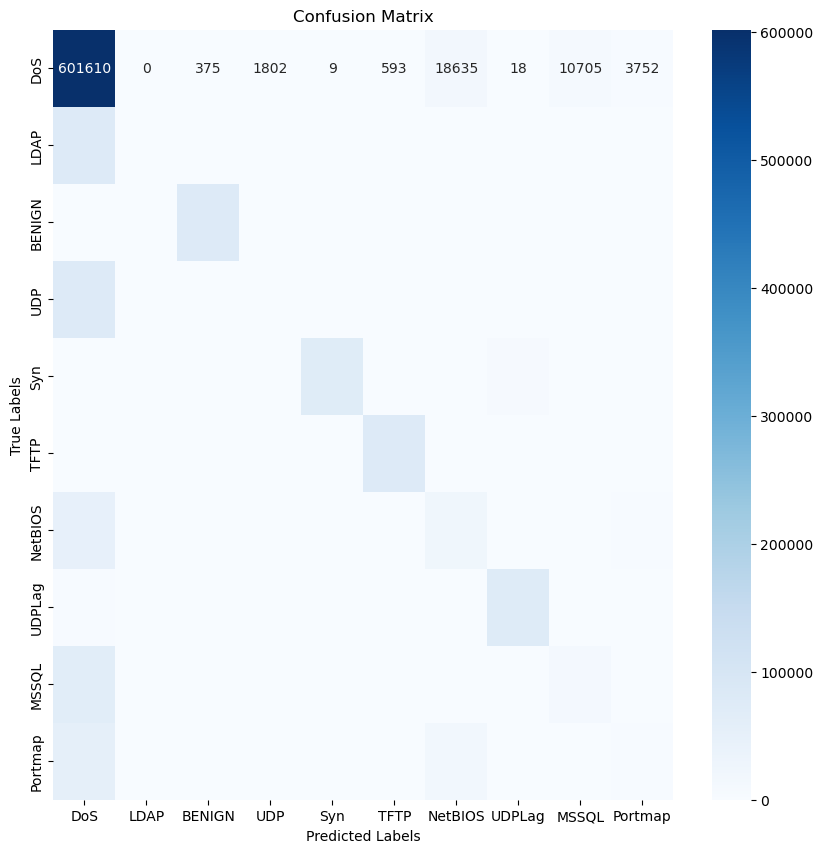

In [29]:
# Celda de evaluación del modelo SIN REDUCIR

# Import necessary libraries
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ensure X_trainArr is a NumPy array of type float64
X_trainArr = X_train.astype(np.float64) if not isinstance(X_train, np.ndarray) else X_train

# Fit the model with training data
model.fit(X_trainArr, Y_train)

# Predict using the model
Y_pred = model.predict(X_trainArr)

# Convert unique labels to a numpy array
LabelsArr = np.array(unique_labels)

# Create a mapping from label names to indices
label_to_index = {label: index for index, label in enumerate(LabelsArr)}

# Map the labels in Y_train and Y_pred using the mapping dictionary
Y_train_mapped = [mapping.get(label, label) for label in Y_train]
Y_pred_mapped = [mapping.get(label, label) for label in Y_pred]

# Convert string labels in Y_train_mapped and Y_pred_mapped to integer indices
Y_train_indices = np.array([label_to_index[label] for label in Y_train_mapped])
Y_pred_indices = np.array([label_to_index[label] for label in Y_pred_mapped])

# Map the numeric predictions to their corresponding label names
y_train_text = [LabelsArr[i] for i in Y_train_indices]
y_pred_text = [LabelsArr[i] for i in Y_pred_indices]

# Compute the confusion matrix
cm = confusion_matrix(y_train_text, y_pred_text, labels=LabelsArr)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LabelsArr, yticklabels=LabelsArr)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_train_text, y_pred_text, digits=8, zero_division=0))

              precision    recall  f1-score   support

      BENIGN  0.99336327 0.99815732 0.99575453     79775
         DoS  0.64323915 0.94370344 0.76502704    637499
        LDAP  0.00000000 0.00000000 0.00000000     79828
       MSSQL  0.52024309 0.15290951 0.23635091     79498
     NetBIOS  0.40340521 0.31907176 0.35631644     79678
     Portmap  0.37351140 0.05525842 0.09627380     79463
         Syn  0.99911493 0.90610028 0.95033707     79734
        TFTP  0.98192578 0.99889630 0.99033834     79732
         UDP  0.44542683 0.01832090 0.03519422     79745
      UDPLag  0.91143627 0.96486225 0.93738863     79601

    accuracy                      0.70382185   1354553
   macro avg  0.62716659 0.53572802 0.53629810   1354553
weighted avg  0.63380108 0.70382185 0.63056224   1354553



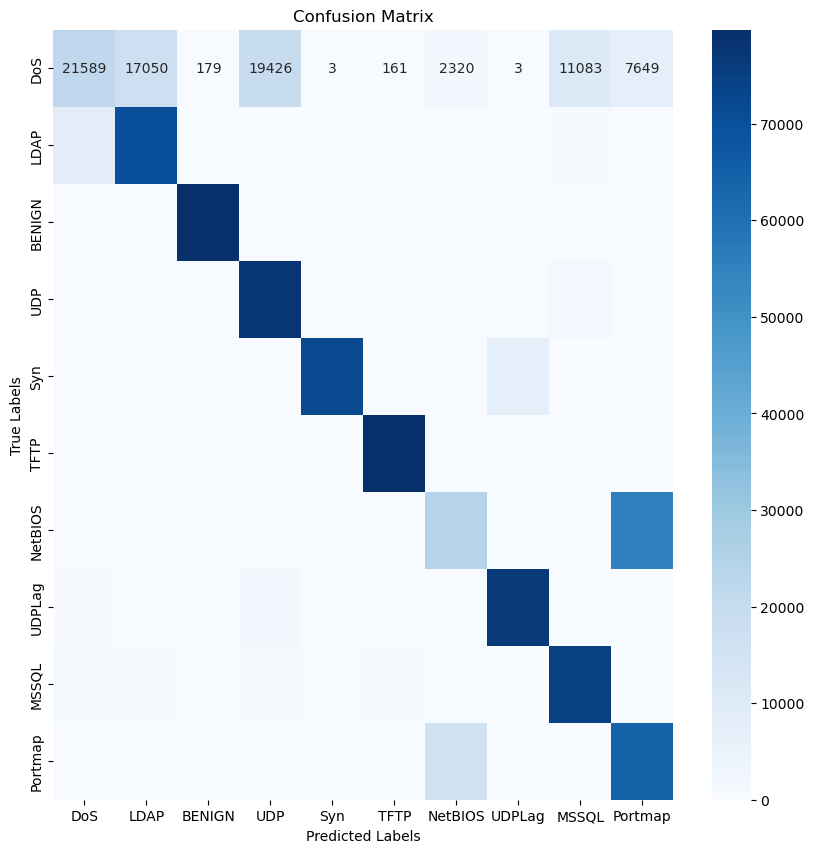

In [31]:
# Celda de evaluación del modelo REDUCIDO

# Import necessary libraries
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Separar las características y las etiquetas del dataset reducido
X_train_reduced = reduced_dataset.drop(columns=['Label'])
Y_train_reduced = reduced_dataset['Label']

# Convert data to numpy arrays if not already
X_trainArr = X_train_reduced.to_numpy()
X_trainArr = X_trainArr.astype(np.float64)

# Fit the model with training data
model.fit(X_trainArr, Y_train_reduced)

# Predict using the model
Y_pred = model.predict(X_trainArr)

# Convert unique labels to a numpy array
LabelsArr = np.array(unique_labels)

# Create a mapping from label names to indices
label_to_index = {label: index for index, label in enumerate(LabelsArr)}

# Map the labels in Y_train_reduced and Y_pred using the mapping dictionary
Y_train_mapped = [mapping.get(label, label) for label in Y_train_reduced]
Y_pred_mapped = [mapping.get(label, label) for label in Y_pred]

# Convert string labels in Y_train_mapped and Y_pred_mapped to integer indices
Y_train_indices = np.array([label_to_index[label] for label in Y_train_mapped])
Y_pred_indices = np.array([label_to_index[label] for label in Y_pred_mapped])

# Map the numeric predictions to their corresponding label names
y_train_text = [LabelsArr[i] for i in Y_train_indices]
y_pred_text = [LabelsArr[i] for i in Y_pred_indices]

# Compute the confusion matrix
cm = confusion_matrix(y_train_text, y_pred_text, labels=LabelsArr)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LabelsArr, yticklabels=LabelsArr)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
#DATASET DOS BALANCEADO
from sklearn.metrics import classification_report

print(classification_report(y_train_text, y_pred_text, digits=8, zero_division=0))

              precision    recall  f1-score   support

      BENIGN  0.99605237 0.99946098 0.99775377     79775
         DoS  0.66743956 0.27168619 0.38617643     79463
        LDAP  0.79546864 0.88358721 0.83721565     79828
       MSSQL  0.84580317 0.94051423 0.89064789     79498
     NetBIOS  0.57896745 0.30471397 0.39928297     79678
     Portmap  0.50387340 0.80379548 0.61943993     79463
         Syn  0.99952963 0.90613791 0.95054533     79734
        TFTP  0.98099566 0.99895901 0.98989585     79732
         UDP  0.77309772 0.97543420 0.86255898     79745
      UDPLag  0.91158634 0.96497531 0.93752136     79601

    accuracy                      0.80509769    796517
   macro avg  0.80528139 0.80492645 0.78710382    796517
weighted avg  0.80542477 0.80509769 0.78728603    796517



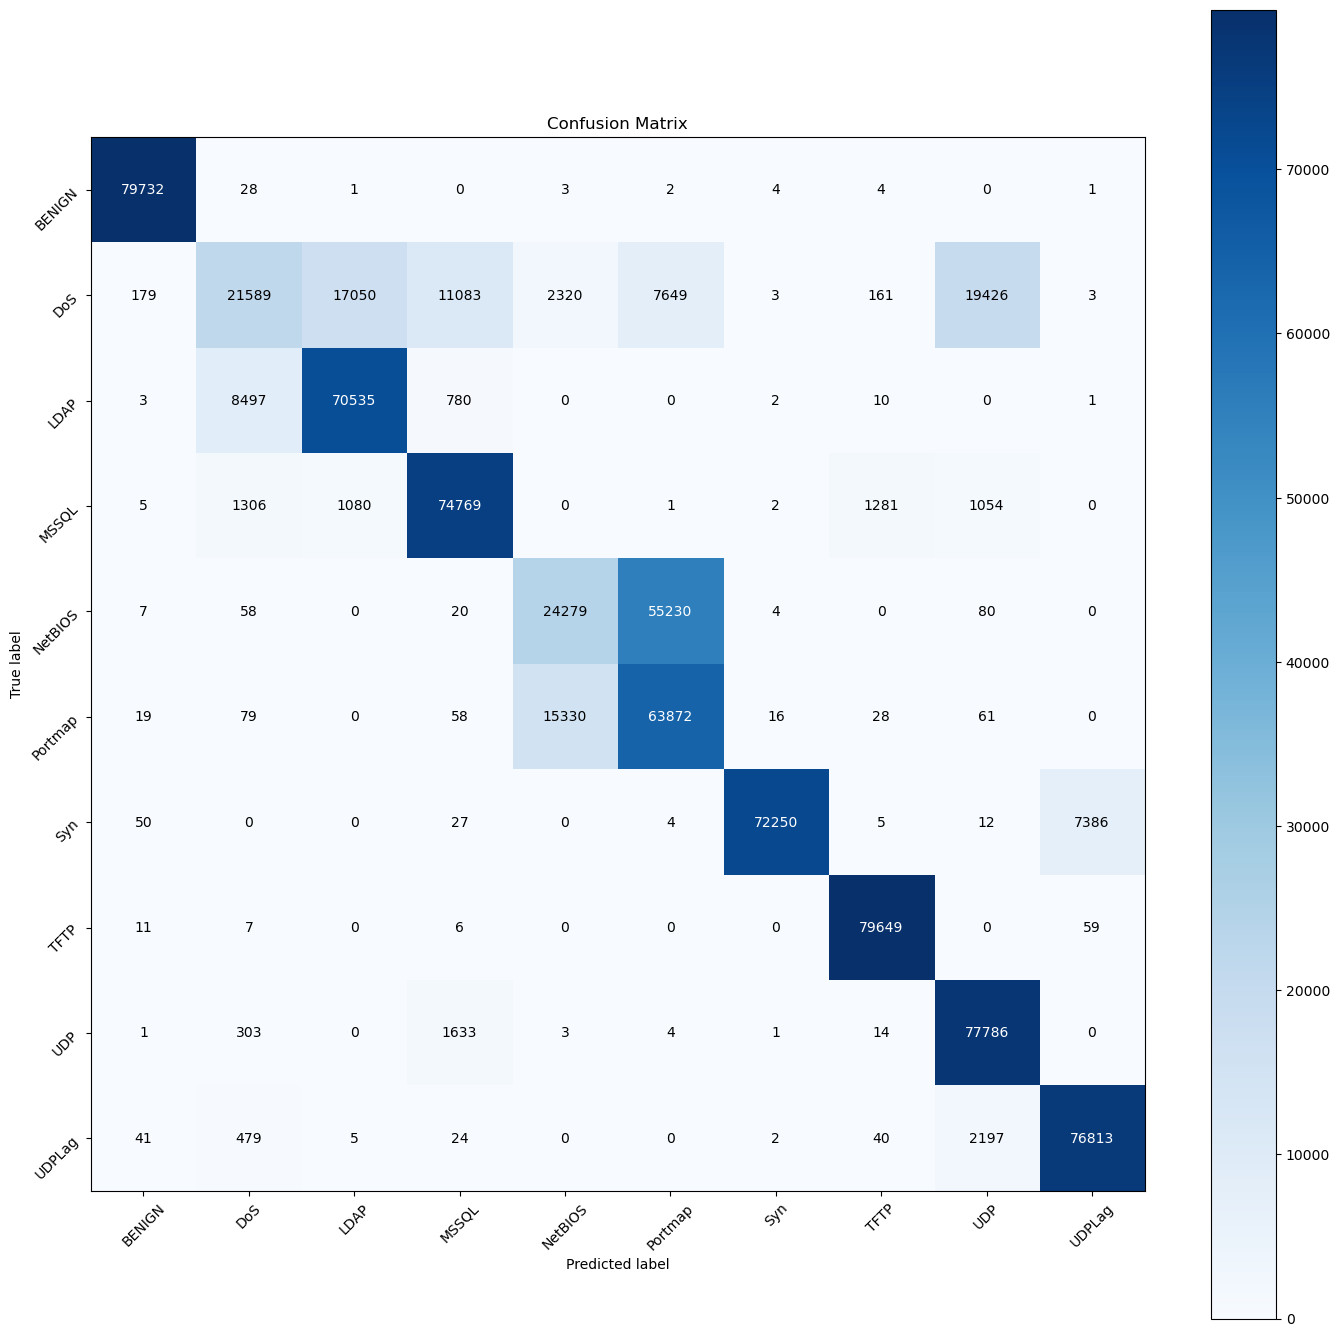

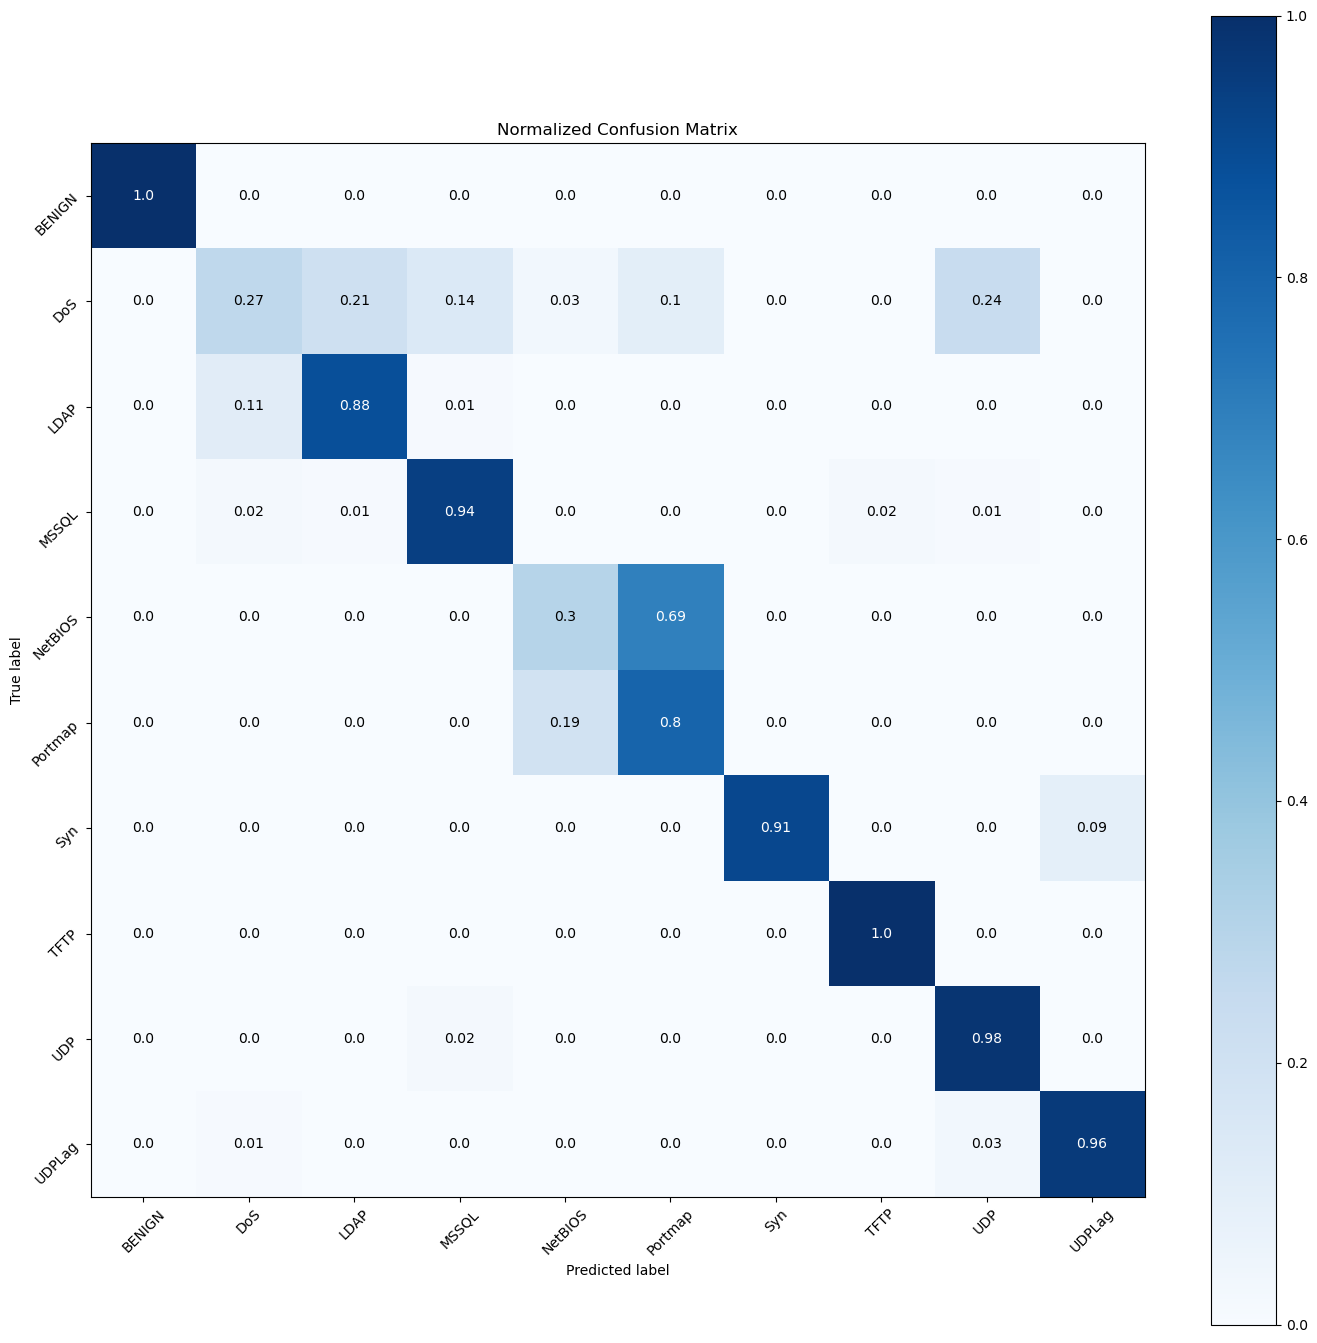

In [33]:
import scikitplot as skplt
# Modified import
from numpy import interp

skplt.metrics.plot_confusion_matrix(y_train_text, y_pred_text, figsize= (17,17))
# Rotate x-axis and y-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
skplt.metrics.plot_confusion_matrix(y_train_text, y_pred_text, normalize= True, figsize= (17,17))
# Rotate x-axis and y-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [34]:
model_reduce = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(16,12), activation='relu', max_iter=1200, random_state=0))
])
model_reduce.fit(X_train_reduced, Y_train_reduced)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(16, 12), max_iter=1200,
                               random_state=0))])

In [35]:
#PARA EVITAR PROBLEMAS REDUCIMOS EL DATASET POST ENTRENAMIENTO PARA REPRODUCCION DE LOS RESULTADOS

# Paso 1: Total de muestras en el dataset original
total_samples = reduced_dataset.shape[0]  # total_samples = 796,517

# Paso 2: Proporción de cada clase en el dataset original
class_counts = reduced_dataset['Label'].value_counts()
class_proportions = class_counts / total_samples

# Paso 3: Número de muestras objetivo por clase
target_total_samples = 420910
target_class_counts = (class_proportions * target_total_samples).round().astype(int)

# Ajustar para que la suma total sea exactamente 420,910
difference = target_total_samples - target_class_counts.sum()
if difference != 0:
    # Ajustar la clase con mayor número de muestras
    max_class = target_class_counts.idxmax()
    target_class_counts[max_class] += difference

# Paso 4: Muestrear cada clase
sampled_dfs = []

for label in class_counts.index:
    class_data = reduced_dataset[reduced_dataset['Label'] == label]
    n_samples = target_class_counts[label]
    # Asegurarse de no pedir más muestras de las disponibles
    n_samples = min(n_samples, len(class_data))
    # Muestrear sin reemplazo
    sampled_class_data = class_data.sample(n=n_samples, random_state=42)
    sampled_dfs.append(sampled_class_data)

# Paso 5: Combinar los DataFrames muestreados
reduced_proportional_dataset = pd.concat(sampled_dfs, ignore_index=True)

# Paso 6: Verificar el nuevo conteo de clases y tamaño total
new_class_counts = reduced_proportional_dataset['Label'].value_counts()
print("Conteo de clases en el dataset reducido:")
print(new_class_counts)
print("Tamaño total del dataset reducido:", reduced_proportional_dataset.shape[0])

Conteo de clases en el dataset reducido:
Label
LDAP       42186
BENIGN     42156
UDP        42140
Syn        42134
TFTP       42133
NetBIOS    42105
UDPLag     42064
MSSQL      42010
DoS        41991
Portmap    41991
Name: count, dtype: int64
Tamaño total del dataset reducido: 420910


In [37]:
# Separar las características y las etiquetas del dataset reducido
X_test_reduced = reduced_proportional_dataset.drop(columns=['Label'])
Y_test_reduced = reduced_proportional_dataset['Label']

# Convert data to numpy arrays if not already
X_testArr = X_test_reduced.to_numpy()
X_testArr = X_testArr.astype(np.float64)

# Predict using the model
Y_pred = model_reduce.predict(X_testArr)

# Convert unique labels to a numpy array
LabelsArr1 = np.array(unique_labels)

# Create a mapping from label names to indices
label_to_index = {label: index for index, label in enumerate(LabelsArr1)}

# CORRECCIÓN: Usar Y_test_reduced en lugar de Y_test
Y_test_mapped = [mapping.get(label, label) for label in Y_test_reduced]  # CAMBIADO AQUÍ
Y_pred_mapped = [mapping.get(label, label) for label in Y_pred]

print("Verificación de longitudes:")
print(f"Y_test_reduced: {len(Y_test_reduced)}")
print(f"Y_pred: {len(Y_pred)}")
print(f"Y_test_mapped: {len(Y_test_mapped)}")
print(f"Y_pred_mapped: {len(Y_pred_mapped)}")

# Convert string labels to integer indices
Y_test_indices = np.array([label_to_index[label] for label in Y_test_mapped])
Y_pred_indices = np.array([label_to_index[label] for label in Y_pred_mapped])

# Map the numeric predictions to their corresponding label names
y_test_text = [LabelsArr1[i] for i in Y_test_indices]
y_pred_text = [LabelsArr1[i] for i in Y_pred_indices]

print("\nVerificación final de longitudes:")
print(f"y_test_text: {len(y_test_text)}")
print(f"y_pred_text: {len(y_pred_text)}")

# Ahora debería funcionar sin error
print(classification_report(y_test_text, y_pred_text, digits=8, zero_division="warn"))

from collections import Counter

print("Distribución de clases en y_test_text:")
print(Counter(y_test_text))

print("\nDistribución de clases en y_pred_text:")
print(Counter(y_pred_text))

c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Verificación de longitudes:
Y_test_reduced: 420910
Y_pred: 420910
Y_test_mapped: 420910
Y_pred_mapped: 420910

Verificación final de longitudes:
y_test_text: 420910
y_pred_text: 420910
              precision    recall  f1-score   support

      BENIGN  0.99579226 0.99926464 0.99752543     42156
         DoS  0.66918703 0.27189160 0.38667615     41991
        LDAP  0.79481609 0.88462997 0.83732149     42186
       MSSQL  0.84709821 0.93949060 0.89090540     42010
     NetBIOS  0.57779980 0.30461940 0.39892384     42105
     Portmap  0.50284485 0.80188612 0.61809571     41991
         Syn  0.99952888 0.90637015 0.95067276     42134
        TFTP  0.98125612 0.99897942 0.99003846     42133
         UDP  0.77188767 0.97579497 0.86194609     42140
      UDPLag  0.91159736 0.96367440 0.93691278     42064

    accuracy                      0.80483239    420910
   macro avg  0.80518083 0.80466013 0.78690181    420910
weighted avg  0.80532316 0.80483239 0.78708410    420910

Distribución de cla

<Figure size 1700x1700 with 0 Axes>

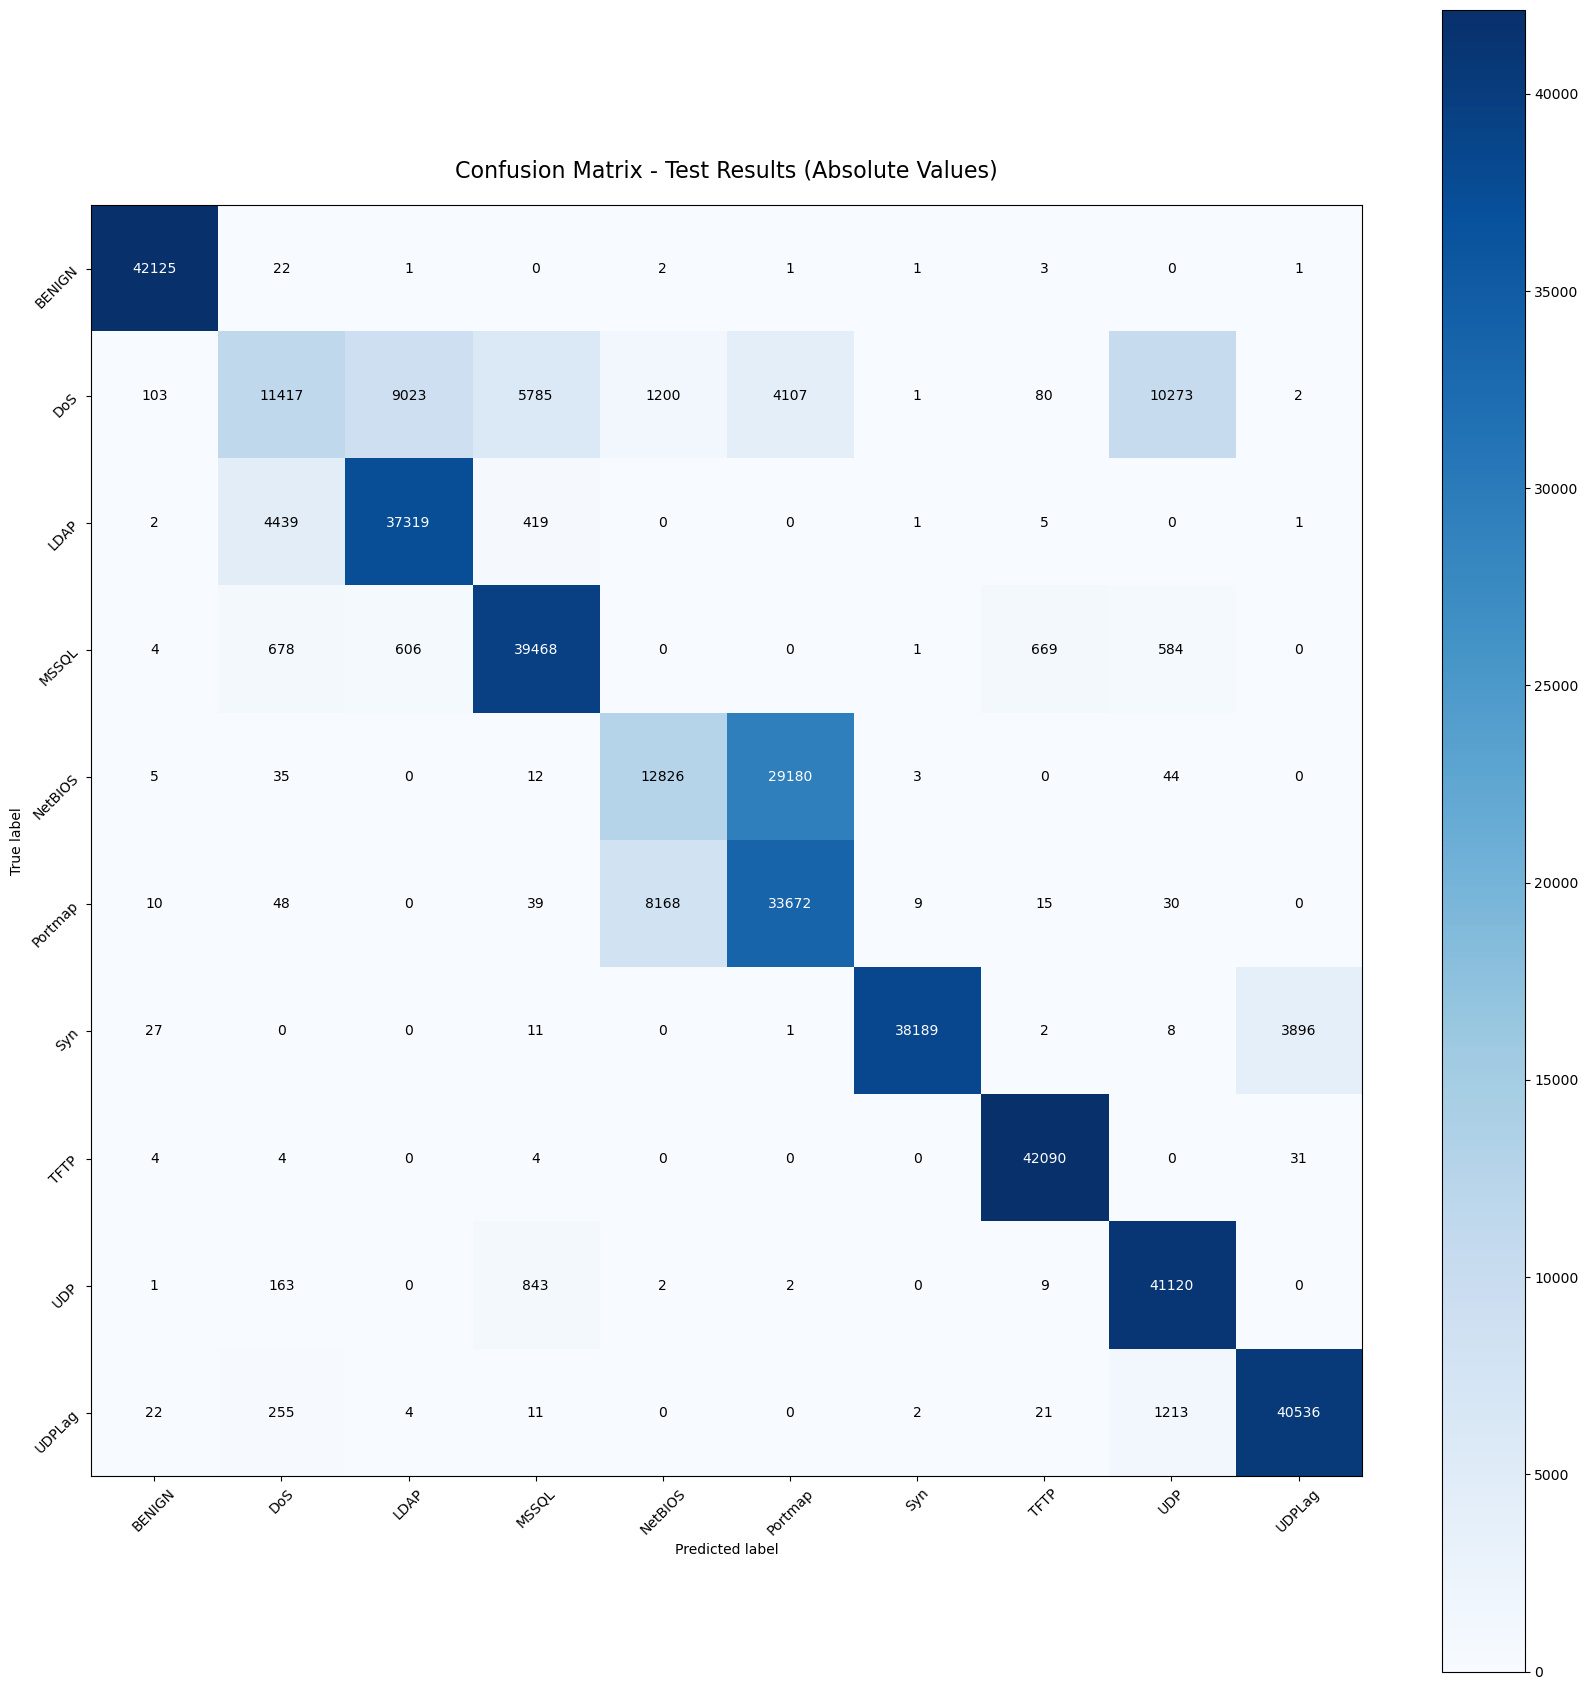

<Figure size 1700x1700 with 0 Axes>

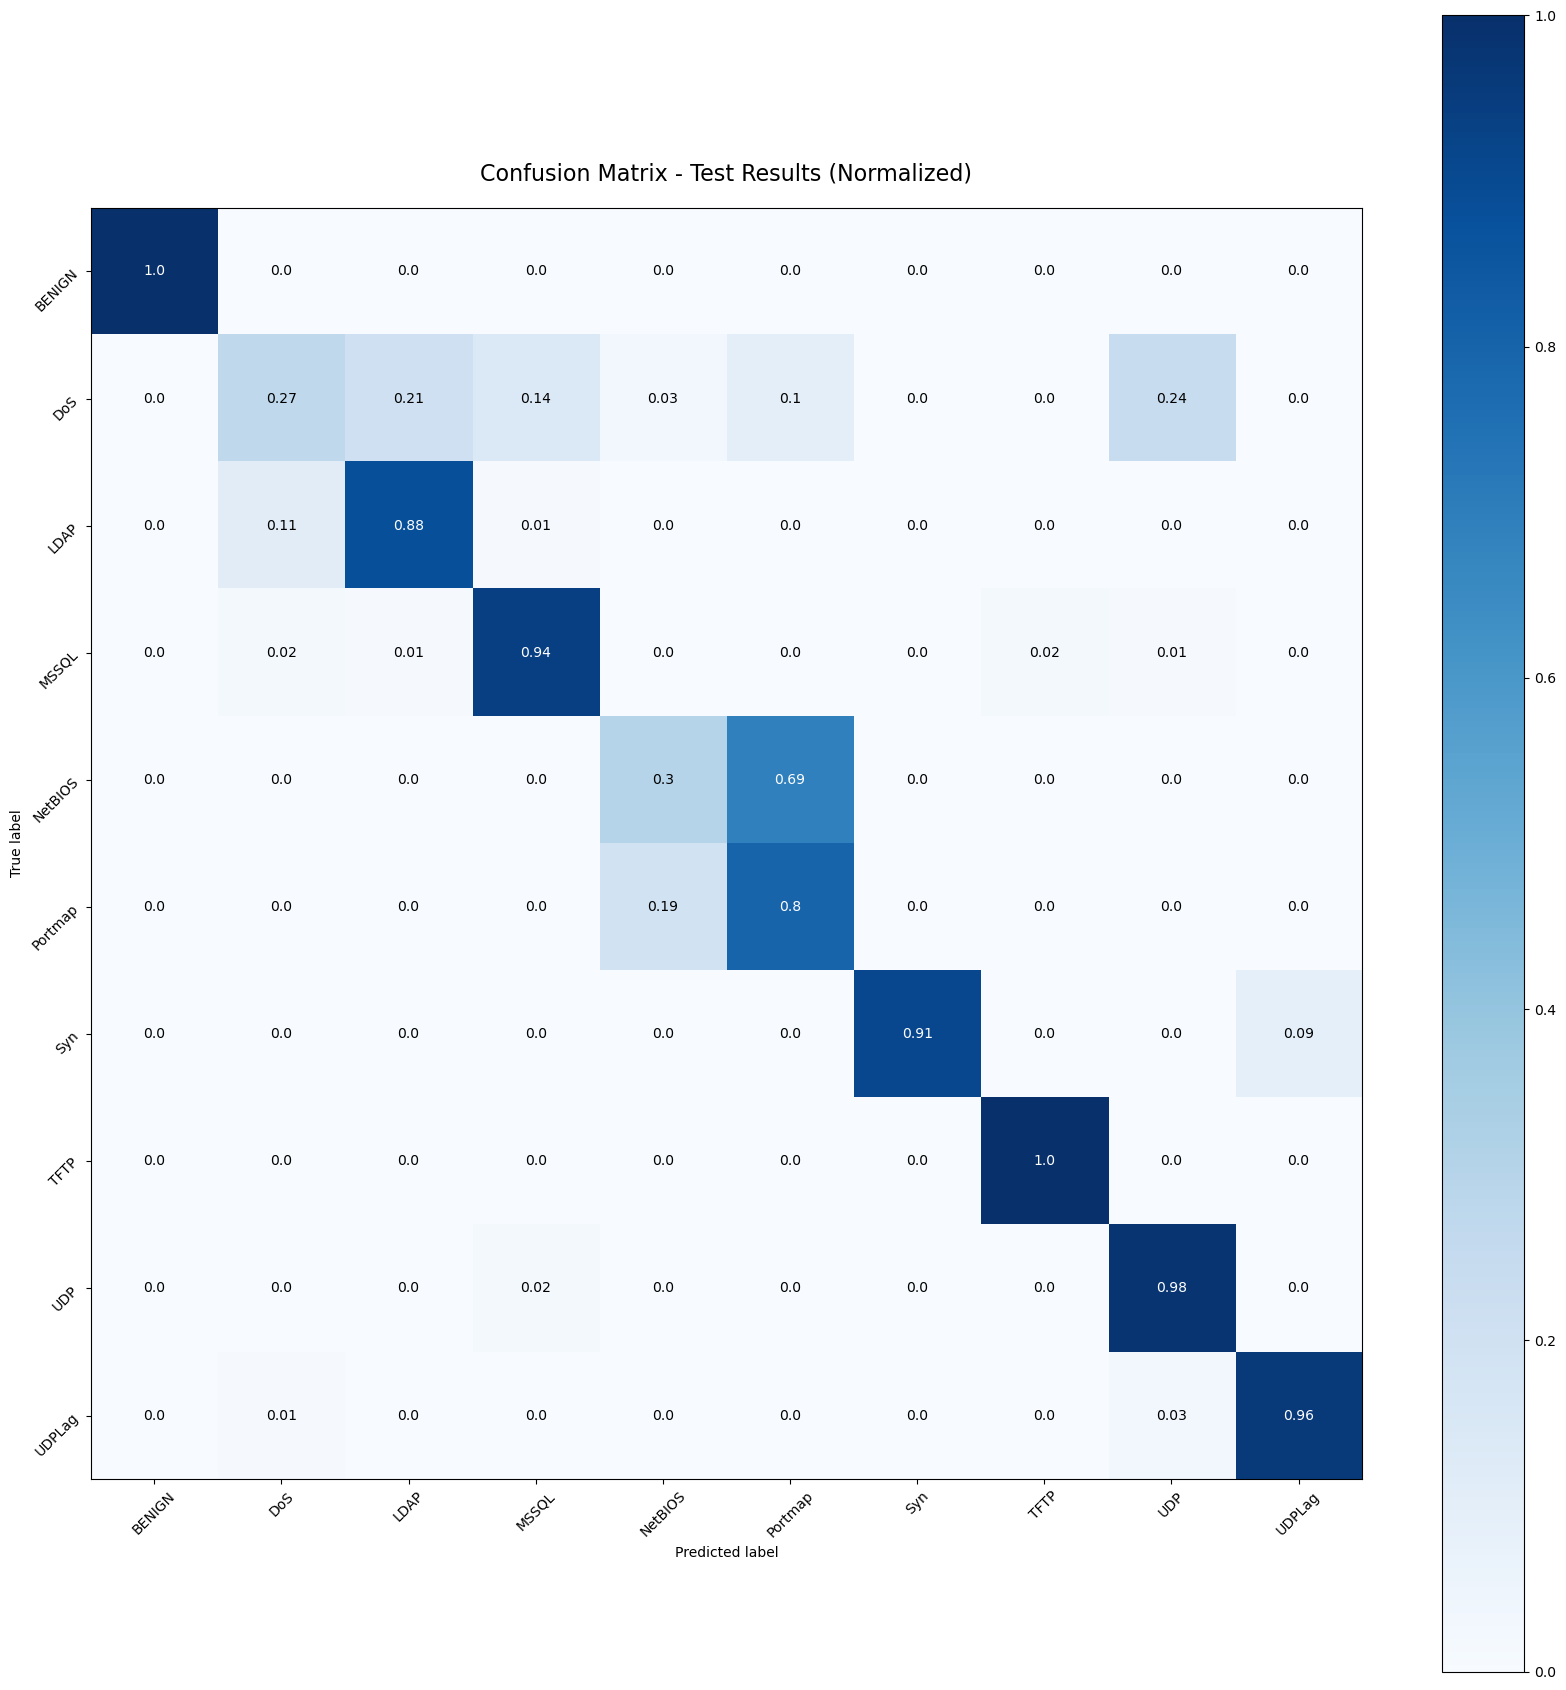

=== ANÁLISIS DE MATRICES DE CONFUSIÓN ===
Total de muestras evaluadas: 420910
Número de clases: 10

=== DISTRIBUCIÓN DE CLASES ===
Clases reales:
  LDAP: 42186 (10.02%)
  BENIGN: 42156 (10.02%)
  UDP: 42140 (10.01%)
  Syn: 42134 (10.01%)
  TFTP: 42133 (10.01%)
  NetBIOS: 42105 (10.00%)
  UDPLag: 42064 (9.99%)
  MSSQL: 42010 (9.98%)
  DoS: 41991 (9.98%)
  Portmap: 41991 (9.98%)

Clases predichas:
  Portmap: 66963 (15.91%)
  UDP: 53272 (12.66%)
  LDAP: 46953 (11.16%)
  MSSQL: 46592 (11.07%)
  UDPLag: 44467 (10.56%)
  TFTP: 42894 (10.19%)
  BENIGN: 42303 (10.05%)
  Syn: 38207 (9.08%)
  NetBIOS: 22198 (5.27%)
  DoS: 17061 (4.05%)

Accuracy calculada manualmente: 0.804832 (80.48%)


In [38]:
# Generar matrices de confusión para la evaluación en datos de test
import scikitplot as skplt
import matplotlib.pyplot as plt
from numpy import interp

# Matriz de confusión sin normalizar
plt.figure(figsize=(17, 17))
skplt.metrics.plot_confusion_matrix(y_test_text, y_pred_text, figsize=(17, 17))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion Matrix - Test Results (Absolute Values)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Matriz de confusión normalizada
plt.figure(figsize=(17, 17))
skplt.metrics.plot_confusion_matrix(y_test_text, y_pred_text, normalize=True, figsize=(17, 17))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion Matrix - Test Results (Normalized)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Información adicional sobre los resultados
print("=== ANÁLISIS DE MATRICES DE CONFUSIÓN ===")
print(f"Total de muestras evaluadas: {len(y_test_text)}")
print(f"Número de clases: {len(set(y_test_text))}")

# Mostrar distribución de clases predichas vs reales
from collections import Counter
print("\n=== DISTRIBUCIÓN DE CLASES ===")
print("Clases reales:")
real_dist = Counter(y_test_text)
for clase, count in real_dist.most_common():
    print(f"  {clase}: {count} ({count/len(y_test_text)*100:.2f}%)")

print("\nClases predichas:")
pred_dist = Counter(y_pred_text)
for clase, count in pred_dist.most_common():
    print(f"  {clase}: {count} ({count/len(y_pred_text)*100:.2f}%)")

# Calcular accuracy manualmente
correct_predictions = sum(1 for real, pred in zip(y_test_text, y_pred_text) if real == pred)
accuracy = correct_predictions / len(y_test_text)
print(f"\nAccuracy calculada manualmente: {accuracy:.6f} ({accuracy*100:.2f}%)")

=== DIAGNÓSTICO DEL PROBLEMA ===
Clases en ENTRENAMIENTO (train_data2.csv):
{'Portmap', 'LDAP', 'NetBIOS', 'BENIGN', 'TFTP', 'UDP', 'Syn', 'MSSQL', 'DoS', 'UDPLag'}
Total clases entrenamiento: 10

Clases en TEST REAL (test_data1.csv):
{'SSH-Bruteforce', 'FTP-BruteForce', 'DoS', 'BENIGN'}
Total clases test: 4

Clases COMUNES (que el modelo puede predecir bien):
{'BENIGN', 'DoS'}

Clases NUEVAS en test (que el modelo NO conoce):
{'SSH-Bruteforce', 'FTP-BruteForce'}

=== EVALUACIÓN REALISTA ===
Muestras de test con clases conocidas: 74889
Distribución en clases conocidas:
Label
DoS       42498
BENIGN    32391
Name: count, dtype: int64

=== RESULTADOS EN CLASES CONOCIDAS ===


c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      BENIGN  0.42196441 0.91065419 0.57670463     32391
         DoS  0.95000000 0.00089416 0.00178664     42498
         Syn  0.00000000 0.00000000 0.00000000         0
        TFTP  0.00000000 0.00000000 0.00000000         0
         UDP  0.00000000 0.00000000 0.00000000         0
      UDPLag  0.00000000 0.00000000 0.00000000         0

    accuracy                      0.39438369     74889
   macro avg  0.22866073 0.15192473 0.09641521     74889
weighted avg  0.72161398 0.39438369 0.25045024     74889



<Figure size 1200x800 with 0 Axes>

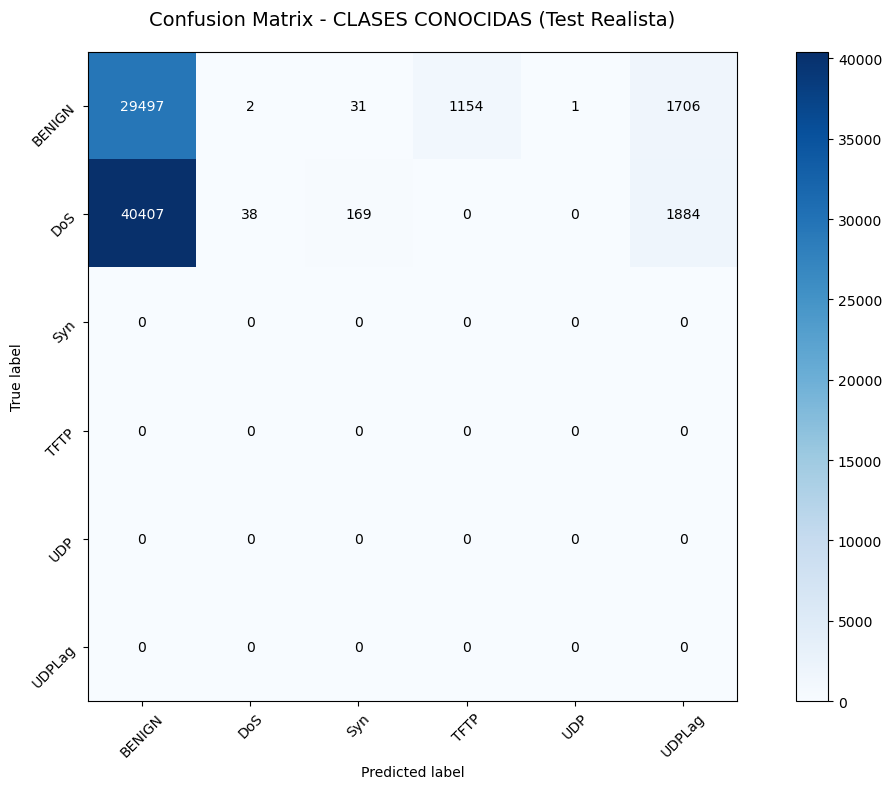


=== RECOMENDACIONES ===
1. Para evaluar correctamente, usar solo clases comunes
2. Para detectar clases nuevas, implementar detección de anomalías
3. Para clasificar clases nuevas, reentrenar con datos mixtos


In [39]:
# ANÁLISIS DEL PROBLEMA REAL
print("=== DIAGNÓSTICO DEL PROBLEMA ===")
print("Clases en ENTRENAMIENTO (train_data2.csv):")
print(set(Y_train))
print(f"Total clases entrenamiento: {len(set(Y_train))}")

print("\nClases en TEST REAL (test_data1.csv):")
print(set(dataset1['Label']))
print(f"Total clases test: {len(set(dataset1['Label']))}")

print("\nClases COMUNES (que el modelo puede predecir bien):")
common_classes = set(Y_train) & set(dataset1['Label'])
print(common_classes)

print("\nClases NUEVAS en test (que el modelo NO conoce):")
new_classes = set(dataset1['Label']) - set(Y_train)
print(new_classes)

print("\n=== EVALUACIÓN REALISTA ===")
# Evaluar solo en las clases que el modelo conoce
test_data_common = dataset1[dataset1['Label'].isin(common_classes)]
print(f"Muestras de test con clases conocidas: {len(test_data_common)}")
print("Distribución en clases conocidas:")
print(test_data_common['Label'].value_counts())

if len(test_data_common) > 0:
    X_test_common = test_data_common.drop(columns=['Label'])
    Y_test_common = test_data_common['Label']
    
    # Ajustar dimensiones
    common_cols = list(set(X_train.columns) & set(X_test_common.columns))
    X_train_common = X_train[common_cols]
    X_test_common = X_test_common[common_cols]
    
    # Reentrenar modelo con características comunes
    model_realistic = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', MLPClassifier(hidden_layer_sizes=(16,12), activation='relu', max_iter=1200, random_state=0))
    ])
    
    model_realistic.fit(X_train_common, Y_train)
    Y_pred_realistic = model_realistic.predict(X_test_common)
    
    print("\n=== RESULTADOS EN CLASES CONOCIDAS ===")
    print(classification_report(Y_test_common, Y_pred_realistic, digits=8, zero_division="warn"))
    
    # Matrices de confusión para clases conocidas
    plt.figure(figsize=(12, 8))
    skplt.metrics.plot_confusion_matrix(Y_test_common, Y_pred_realistic, figsize=(12, 8))
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Confusion Matrix - CLASES CONOCIDAS (Test Realista)', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

print("\n=== RECOMENDACIONES ===")
print("1. Para evaluar correctamente, usar solo clases comunes")
print("2. Para detectar clases nuevas, implementar detección de anomalías")
print("3. Para clasificar clases nuevas, reentrenar con datos mixtos")

=== EVALUACIÓN CORREGIDA ===
=== RESULTADOS EN TEST REAL ===


c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ecaba\anaconda3

                precision    recall  f1-score   support

        BENIGN  0.45576463 0.27069248 0.33965407     32391
           DoS  1.00000000 0.00037649 0.00075269     42498
FTP-BruteForce  0.00000000 0.00000000 0.00000000     15138
       Portmap  0.00000000 0.00000000 0.00000000         0
SSH-Bruteforce  0.00000000 0.00000000 0.00000000     11965
           Syn  0.00000000 0.00000000 0.00000000         0
        UDPLag  0.00000000 0.00000000 0.00000000         0

      accuracy                      0.08612440    101992
     macro avg  0.20796638 0.03872414 0.04862954    101992
  weighted avg  0.56142317 0.08612440 0.10818224    101992



<Figure size 1200x800 with 0 Axes>

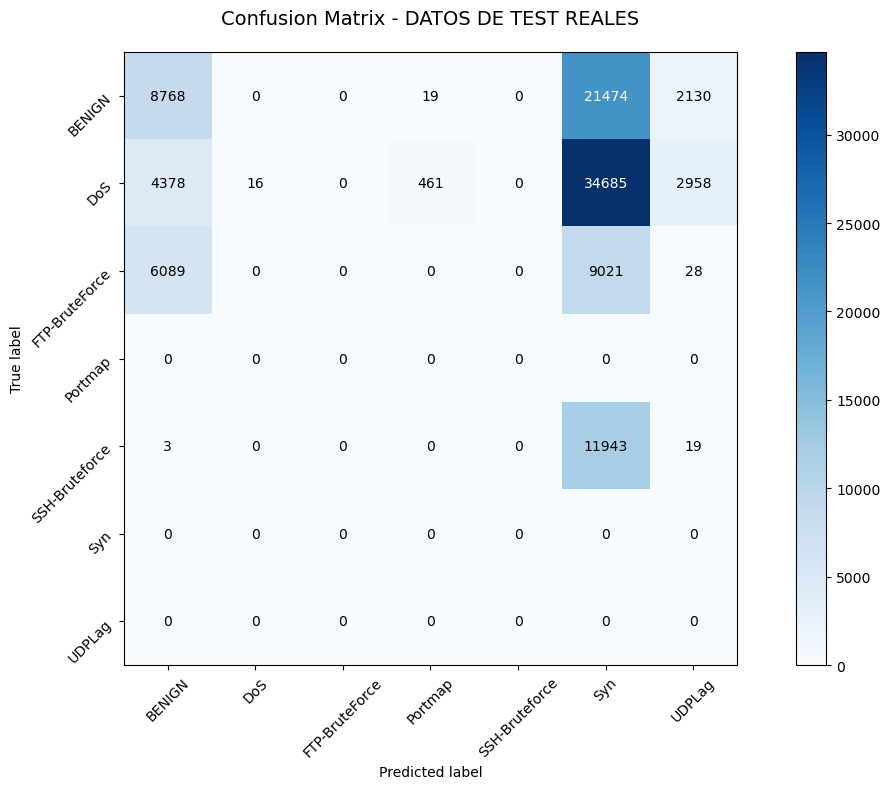

c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\scikitplot\metrics.py:124: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1200x800 with 0 Axes>

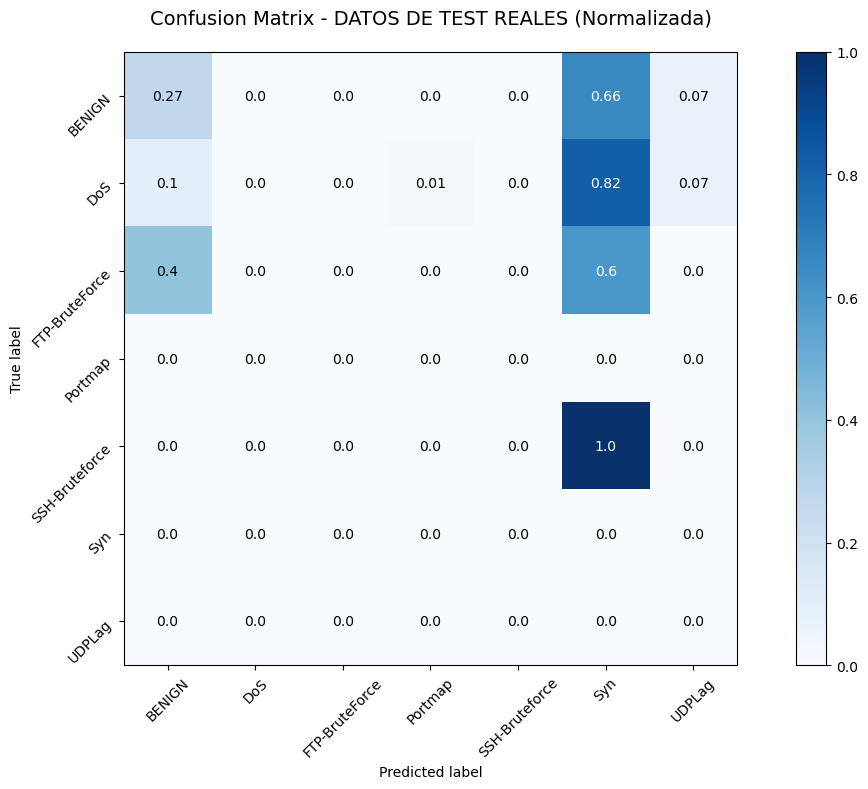


=== DISTRIBUCIÓN REAL ===
Clases reales en test:
  DoS: 42498 (41.67%)
  BENIGN: 32391 (31.76%)
  FTP-BruteForce: 15138 (14.84%)
  SSH-Bruteforce: 11965 (11.73%)

Clases predichas:
  Syn: 77123 (75.62%)
  BENIGN: 19238 (18.86%)
  UDPLag: 5135 (5.03%)
  Portmap: 480 (0.47%)
  DoS: 16 (0.02%)

Accuracy REAL: 0.086124 (8.61%)


In [40]:
# SOLUCIÓN: EVALUACIÓN CON DATOS DE TEST REALES
print("=== EVALUACIÓN CORREGIDA ===")

# 1. Usar los datos de test REALES (dataset1)
X_test_real = dataset1.drop(columns=['Label'])
Y_test_real = dataset1['Label']

# 2. Ajustar dimensiones si es necesario
common_cols = list(set(X_train_reduced.columns) & set(X_test_real.columns))
X_train_final = X_train_reduced[common_cols]
X_test_final = X_test_real[common_cols]

# 3. Entrenar modelo con datos balanceados
model_final = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(16,12), activation='relu', max_iter=1200, random_state=0))
])

model_final.fit(X_train_final, Y_train_reduced)

# 4. Predecir en datos de test REALES
Y_pred_real = model_final.predict(X_test_final)

print("=== RESULTADOS EN TEST REAL ===")
print(classification_report(Y_test_real, Y_pred_real, digits=8, zero_division="warn"))

# Matrices de confusión correctas
plt.figure(figsize=(12, 8))
skplt.metrics.plot_confusion_matrix(Y_test_real, Y_pred_real, figsize=(12, 8))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion Matrix - DATOS DE TEST REALES', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
skplt.metrics.plot_confusion_matrix(Y_test_real, Y_pred_real, normalize=True, figsize=(12, 8))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion Matrix - DATOS DE TEST REALES (Normalizada)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Análisis de distribuciones
from collections import Counter
print("\n=== DISTRIBUCIÓN REAL ===")
print("Clases reales en test:")
real_dist = Counter(Y_test_real)
for clase, count in real_dist.most_common():
    print(f"  {clase}: {count} ({count/len(Y_test_real)*100:.2f}%)")

print("\nClases predichas:")
pred_dist = Counter(Y_pred_real)
for clase, count in pred_dist.most_common():
    print(f"  {clase}: {count} ({count/len(Y_pred_real)*100:.2f}%)")

# Accuracy real
accuracy_real = sum(1 for real, pred in zip(Y_test_real, Y_pred_real) if real == pred) / len(Y_test_real)
print(f"\nAccuracy REAL: {accuracy_real:.6f} ({accuracy_real*100:.2f}%)")

=== CLASIFICACIÓN BINARIA (BENIGN vs ATTACK) ===
=== RESULTADOS BINARIOS ===
              precision    recall  f1-score   support

      ATTACK  0.71401996 0.84375224 0.77348401     69601
      BENIGN  0.44922765 0.27384150 0.34026393     32391

    accuracy                      0.66275786    101992
   macro avg  0.58162381 0.55879687 0.55687397    101992
weighted avg  0.62992623 0.66275786 0.63590036    101992



<Figure size 800x600 with 0 Axes>

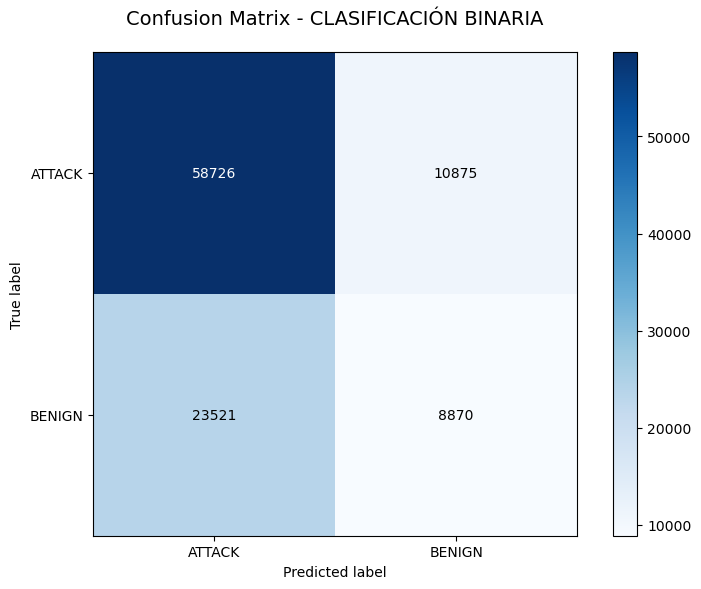


Accuracy BINARIO: 0.662758 (66.28%)


In [41]:
# OPCIÓN ALTERNATIVA: CLASIFICACIÓN BINARIA
print("=== CLASIFICACIÓN BINARIA (BENIGN vs ATTACK) ===")

# Función para mapear a binario
def to_binary(label):
    return 'BENIGN' if label == 'BENIGN' else 'ATTACK'

# Aplicar mapeo binario
Y_train_binary = [to_binary(label) for label in Y_train_reduced]
Y_test_binary = [to_binary(label) for label in Y_test_real]

# Entrenar modelo binario
model_binary = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(16,12), activation='relu', max_iter=1200, random_state=0))
])

model_binary.fit(X_train_final, Y_train_binary)
Y_pred_binary = model_binary.predict(X_test_final)

print("=== RESULTADOS BINARIOS ===")
print(classification_report(Y_test_binary, Y_pred_binary, digits=8, zero_division="warn"))

# Matriz de confusión binaria
plt.figure(figsize=(8, 6))
skplt.metrics.plot_confusion_matrix(Y_test_binary, Y_pred_binary, figsize=(8, 6))
plt.title('Confusion Matrix - CLASIFICACIÓN BINARIA', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

accuracy_binary = sum(1 for real, pred in zip(Y_test_binary, Y_pred_binary) if real == pred) / len(Y_test_binary)
print(f"\nAccuracy BINARIO: {accuracy_binary:.6f} ({accuracy_binary*100:.2f}%)")

=== CLASIFICACIÓN BINARIA CON BALANCEO MANUAL CORREGIDA ===
Distribución TRAINING binario:
  ATTACK: 716742 (89.98%)
  BENIGN: 79775 (10.02%)

Distribución TEST binario:
  ATTACK: 69601 (68.24%)
  BENIGN: 32391 (31.76%)

Antes del balanceo:
ATTACK: 716742
BENIGN: 79775

Después del balanceo:
ATTACK: 79775
BENIGN: 79775
Total: 159550

=== RESULTADOS BINARIOS BALANCEADOS (CORREGIDOS) ===
              precision    recall  f1-score   support

      ATTACK   0.731712  0.729357  0.730533     69601
      BENIGN   0.422444  0.425365  0.423899     32391

    accuracy                       0.632814    101992
   macro avg   0.577078  0.577361  0.577216    101992
weighted avg   0.633494  0.632814  0.633151    101992



<Figure size 800x600 with 0 Axes>

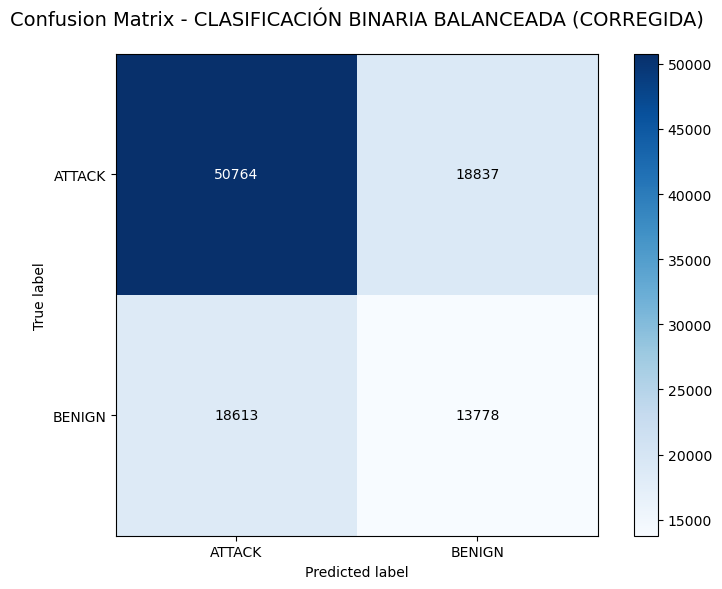


Matriz de confusión (ORDEN CORRECTO):
           ATTACK  BENIGN
ATTACK      50764   18837
BENIGN      18613   13778

=== MÉTRICAS CALCULADAS MANUALMENTE ===
ATTACK:
  Precision: 0.731712
  Recall: 0.729357
  F1-Score: 0.730533

BENIGN:
  Precision: 0.422444
  Recall: 0.425365
  F1-Score: 0.423899

Accuracy total: 0.632814 (63.28%)

=== DISTRIBUCIÓN DE PREDICCIONES ===
  BENIGN: 32615 (31.98%)
  ATTACK: 69377 (68.02%)


In [42]:
# CORRECCIÓN: ORDEN CORRECTO DE ETIQUETAS
print("=== CLASIFICACIÓN BINARIA CON BALANCEO MANUAL CORREGIDA ===")

# Función para mapear a binario
def to_binary(label):
    return 'BENIGN' if label == 'BENIGN' else 'ATTACK'

# Aplicar mapeo binario CORRECTAMENTE
Y_train_binary = [to_binary(label) for label in Y_train_reduced]
Y_test_binary = [to_binary(label) for label in Y_test_real]

# VERIFICAR las distribuciones binarias
from collections import Counter
print("Distribución TRAINING binario:")
train_dist = Counter(Y_train_binary)
for clase, count in train_dist.items():
    print(f"  {clase}: {count} ({count/len(Y_train_binary)*100:.2f}%)")

print("\nDistribución TEST binario:")
test_dist = Counter(Y_test_binary)
for clase, count in test_dist.items():
    print(f"  {clase}: {count} ({count/len(Y_test_binary)*100:.2f}%)")

# BALANCEO MANUAL: Undersample la clase mayoritaria
import pandas as pd

# Crear DataFrame para manejar fácilmente
df_train = pd.DataFrame(X_train_final)
df_train['Label'] = Y_train_binary

# Separar por clases
attack_samples = df_train[df_train['Label'] == 'ATTACK']
benign_samples = df_train[df_train['Label'] == 'BENIGN']

print(f"\nAntes del balanceo:")
print(f"ATTACK: {len(attack_samples)}")
print(f"BENIGN: {len(benign_samples)}")

# Tomar el mínimo entre las dos clases
min_samples = min(len(attack_samples), len(benign_samples))

# Hacer undersample de ambas clases al mínimo
attack_balanced = attack_samples.sample(n=min_samples, random_state=42)
benign_balanced = benign_samples.sample(n=min_samples, random_state=42)

# Combinar datasets balanceados
df_balanced = pd.concat([attack_balanced, benign_balanced], ignore_index=True)

# Shuffle el dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separar características y etiquetas balanceadas
X_train_balanced = df_balanced.drop('Label', axis=1)
Y_train_balanced = df_balanced['Label']

print(f"\nDespués del balanceo:")
print(f"ATTACK: {len(Y_train_balanced[Y_train_balanced == 'ATTACK'])}")
print(f"BENIGN: {len(Y_train_balanced[Y_train_balanced == 'BENIGN'])}")
print(f"Total: {len(Y_train_balanced)}")

# Entrenar modelo con datos balanceados
model_binary_balanced = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(32, 16), 
        activation='relu', 
        max_iter=1500, 
        random_state=0,
        learning_rate_init=0.001
    ))
])

model_binary_balanced.fit(X_train_balanced, Y_train_balanced)
Y_pred_binary_balanced = model_binary_balanced.predict(X_test_final)

print("\n=== RESULTADOS BINARIOS BALANCEADOS (CORREGIDOS) ===")
# FORZAR EL ORDEN CORRECTO DE ETIQUETAS
print(classification_report(Y_test_binary, Y_pred_binary_balanced, 
                           labels=['ATTACK', 'BENIGN'],  # ¡ORDEN CORRECTO!
                           digits=6))

# Matriz de confusión corregida CON ORDEN EXPLÍCITO
plt.figure(figsize=(8, 6))
skplt.metrics.plot_confusion_matrix(Y_test_binary, Y_pred_binary_balanced, 
                                   labels=['ATTACK', 'BENIGN'],  # ¡ORDEN CORRECTO!
                                   figsize=(8, 6))
plt.title('Confusion Matrix - CLASIFICACIÓN BINARIA BALANCEADA (CORREGIDA)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Calcular métricas manualmente para verificar CON ORDEN CORRECTO
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_binary, Y_pred_binary_balanced, labels=['ATTACK', 'BENIGN'])
print(f"\nMatriz de confusión (ORDEN CORRECTO):")
print(f"           ATTACK  BENIGN")
print(f"ATTACK     {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"BENIGN     {cm[1,0]:6d}  {cm[1,1]:6d}")

# Calcular métricas para ATTACK (primera clase)
tn, fp, fn, tp = cm[1,1], cm[1,0], cm[0,1], cm[0,0]  # Para clase ATTACK
precision_attack = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_attack = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_attack = 2 * (precision_attack * recall_attack) / (precision_attack + recall_attack) if (precision_attack + recall_attack) > 0 else 0

# Calcular métricas para BENIGN (segunda clase)
tn_benign, fp_benign, fn_benign, tp_benign = cm[0,0], cm[0,1], cm[1,0], cm[1,1]  # Para clase BENIGN
precision_benign = tp_benign / (tp_benign + fp_benign) if (tp_benign + fp_benign) > 0 else 0
recall_benign = tp_benign / (tp_benign + fn_benign) if (tp_benign + fn_benign) > 0 else 0
f1_benign = 2 * (precision_benign * recall_benign) / (precision_benign + recall_benign) if (precision_benign + recall_benign) > 0 else 0

print(f"\n=== MÉTRICAS CALCULADAS MANUALMENTE ===")
print(f"ATTACK:")
print(f"  Precision: {precision_attack:.6f}")
print(f"  Recall: {recall_attack:.6f}")
print(f"  F1-Score: {f1_attack:.6f}")

print(f"\nBENIGN:")
print(f"  Precision: {precision_benign:.6f}")
print(f"  Recall: {recall_benign:.6f}")
print(f"  F1-Score: {f1_benign:.6f}")

# Accuracy total
accuracy_total = (cm[0,0] + cm[1,1]) / cm.sum()
print(f"\nAccuracy total: {accuracy_total:.6f} ({accuracy_total*100:.2f}%)")

# Análisis de la distribución de predicciones
pred_dist = Counter(Y_pred_binary_balanced)
print(f"\n=== DISTRIBUCIÓN DE PREDICCIONES ===")
for clase, count in pred_dist.items():
    print(f"  {clase}: {count} ({count/len(Y_pred_binary_balanced)*100:.2f}%)")

In [43]:

#expected_value = explainer.expected_value

# Calculate SHAP values
#size=200
#data=shap.sample(X_trainArr, size)
#explainer = shap.KernelExplainer(model.predict_proba,data)
#expected_value = explainer.expected_value
#data1=shap.sample(X_testArr, size)
#shap_values = explainer.shap_values(data1, nsamples=size)
print(f"Características en X_trainArr: {X_trainArr.shape[1]}")
print(f"Características en X_testArr: {X_testArr.shape[1]}")

# Calculate SHAP values
size = 200
data = shap.sample(X_trainArr, size)
explainer = shap.KernelExplainer(model.predict_proba, data)
expected_value = explainer.expected_value

# Asegúrate de que X_test es un numpy array
#X_testArr = X_test.to_numpy()

data1 = shap.sample(X_testArr, size)
shap_values = explainer.shap_values(data1, nsamples=size)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Características en X_trainArr: 64
Características en X_testArr: 64


  0%|          | 0/200 [00:00<?, ?it/s]

Shape of shap_values: (200, 64, 10)
Shape of data1: (200, 64)
Number of features: 64
Shape of shap_values_mean: (200, 64)


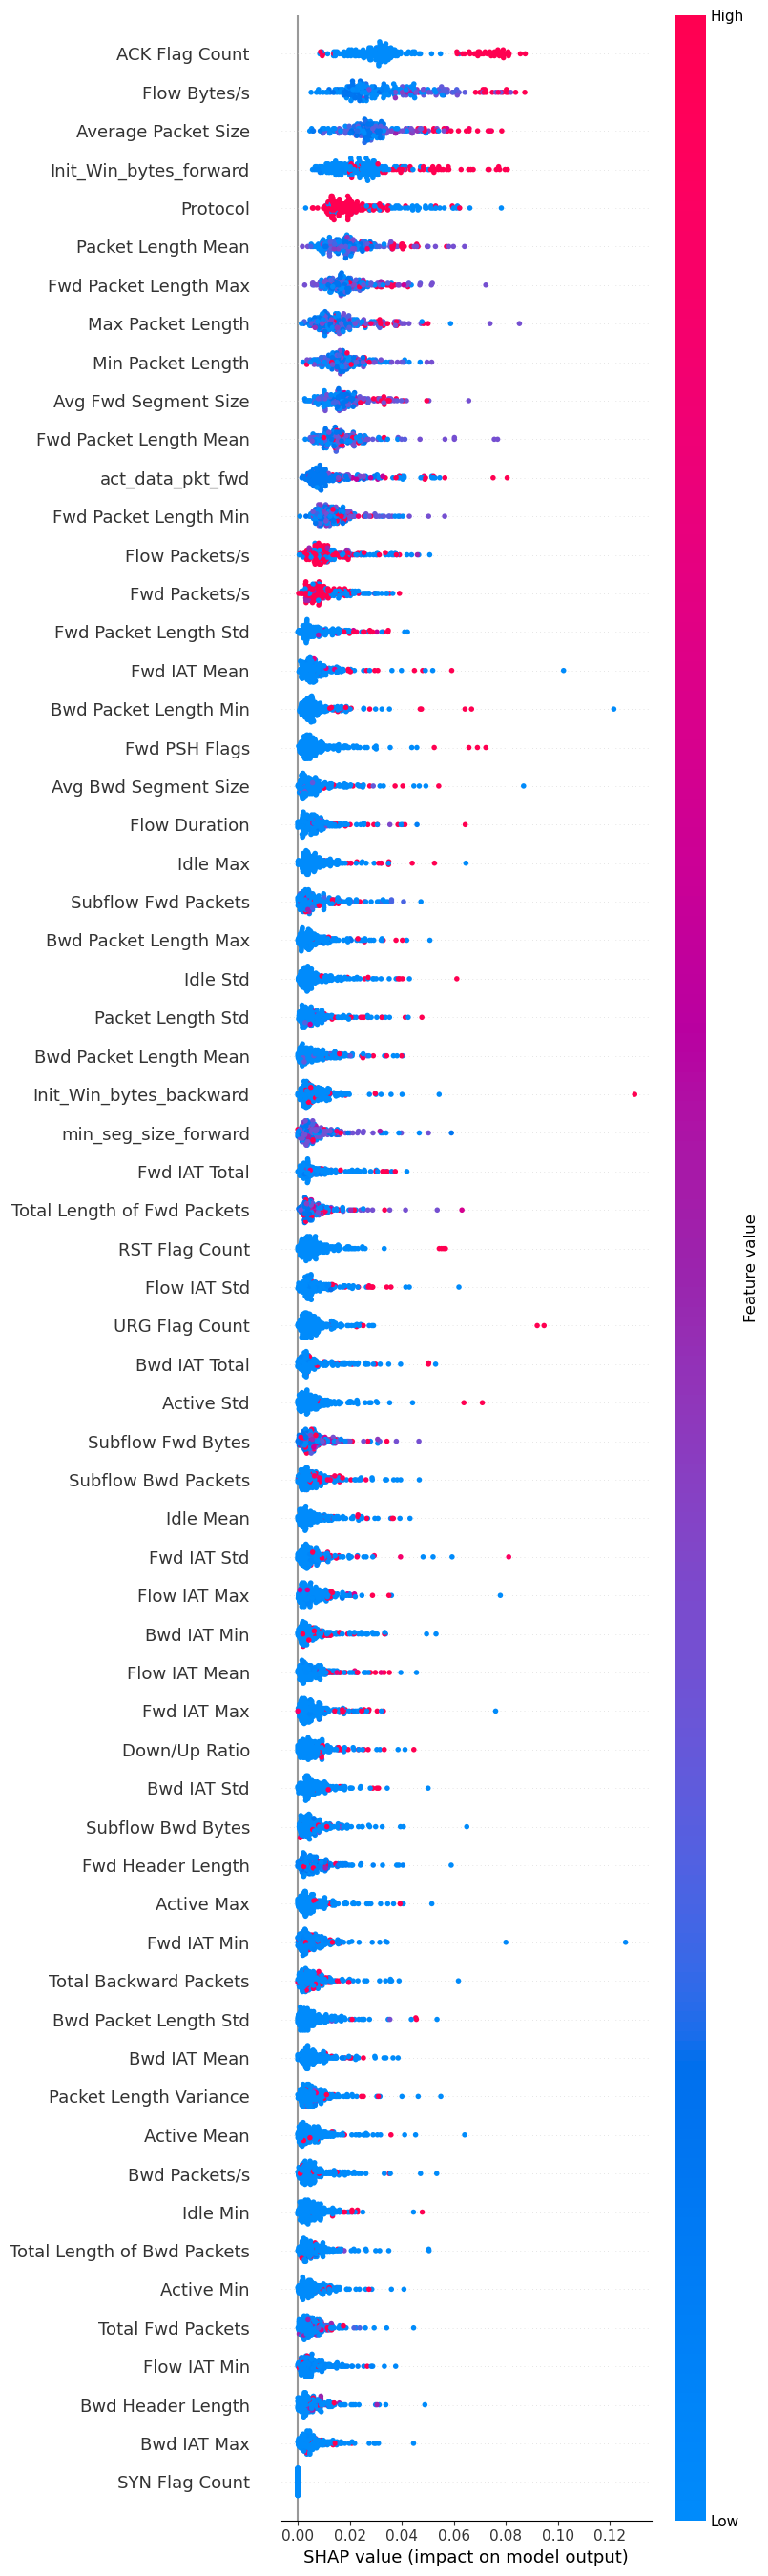

Plotting SHAP values for class 0


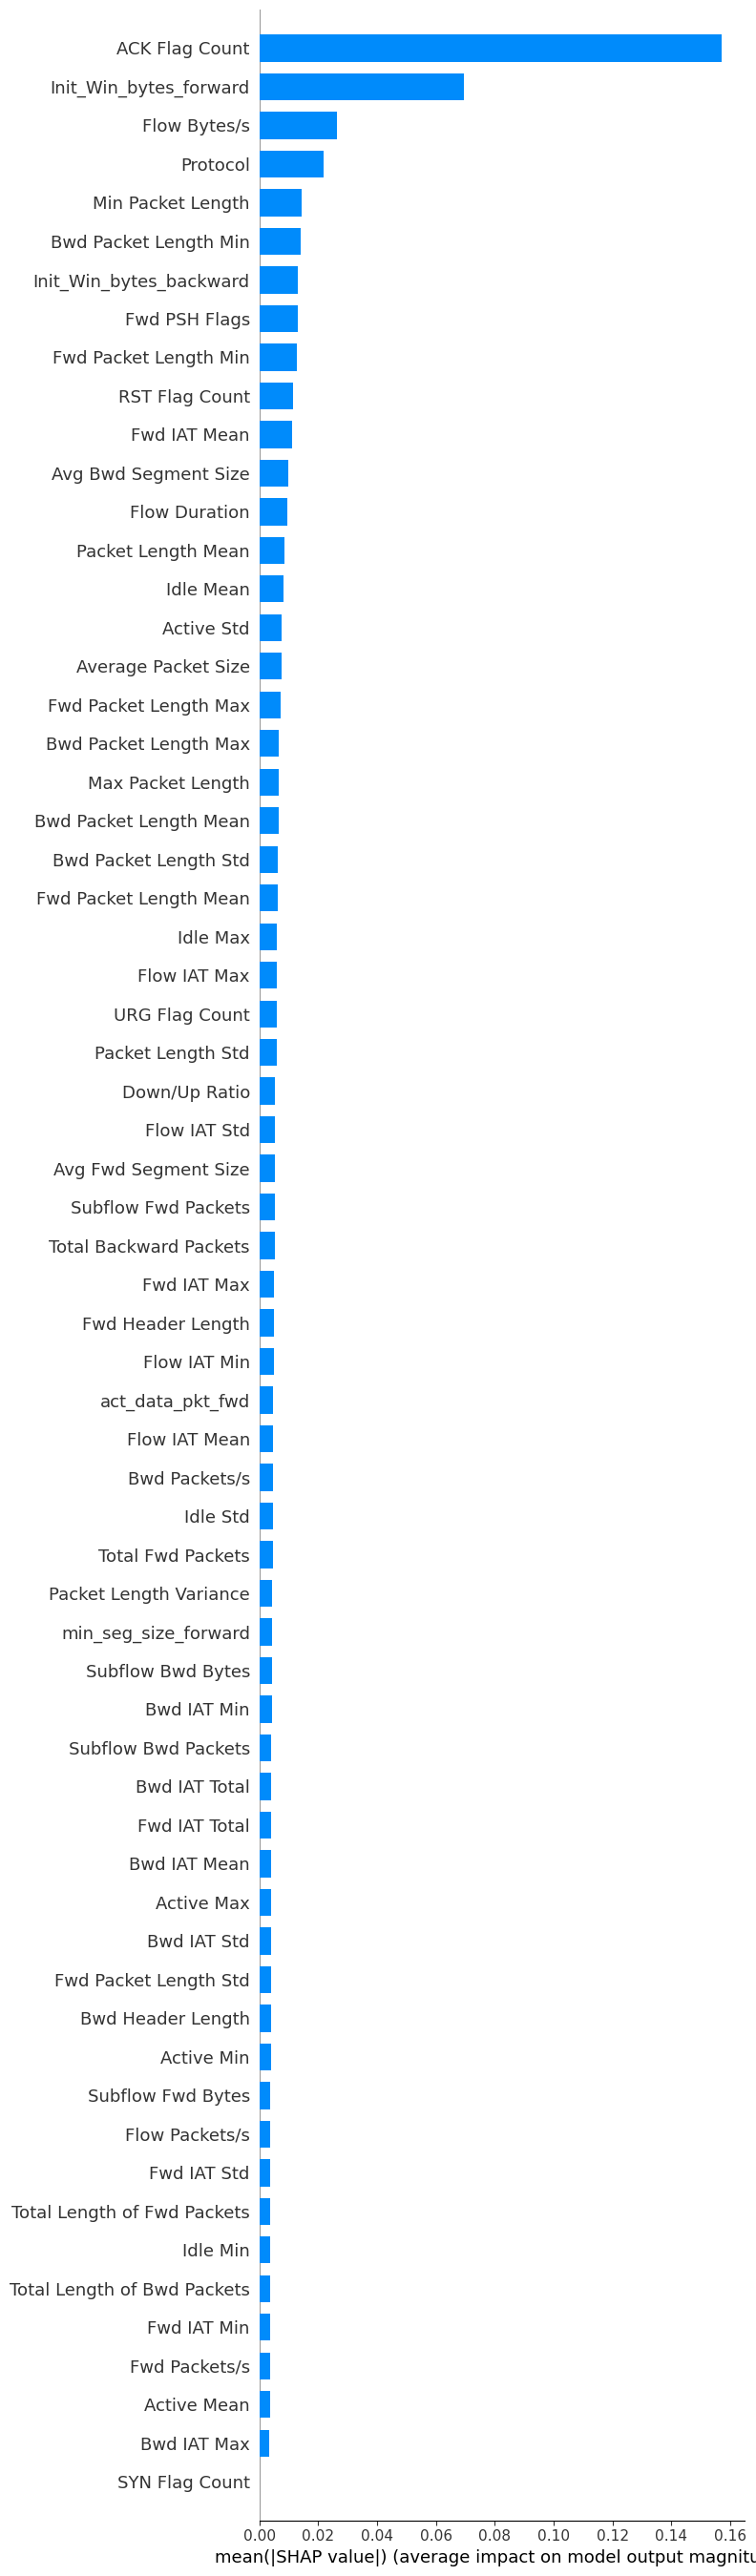

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 1


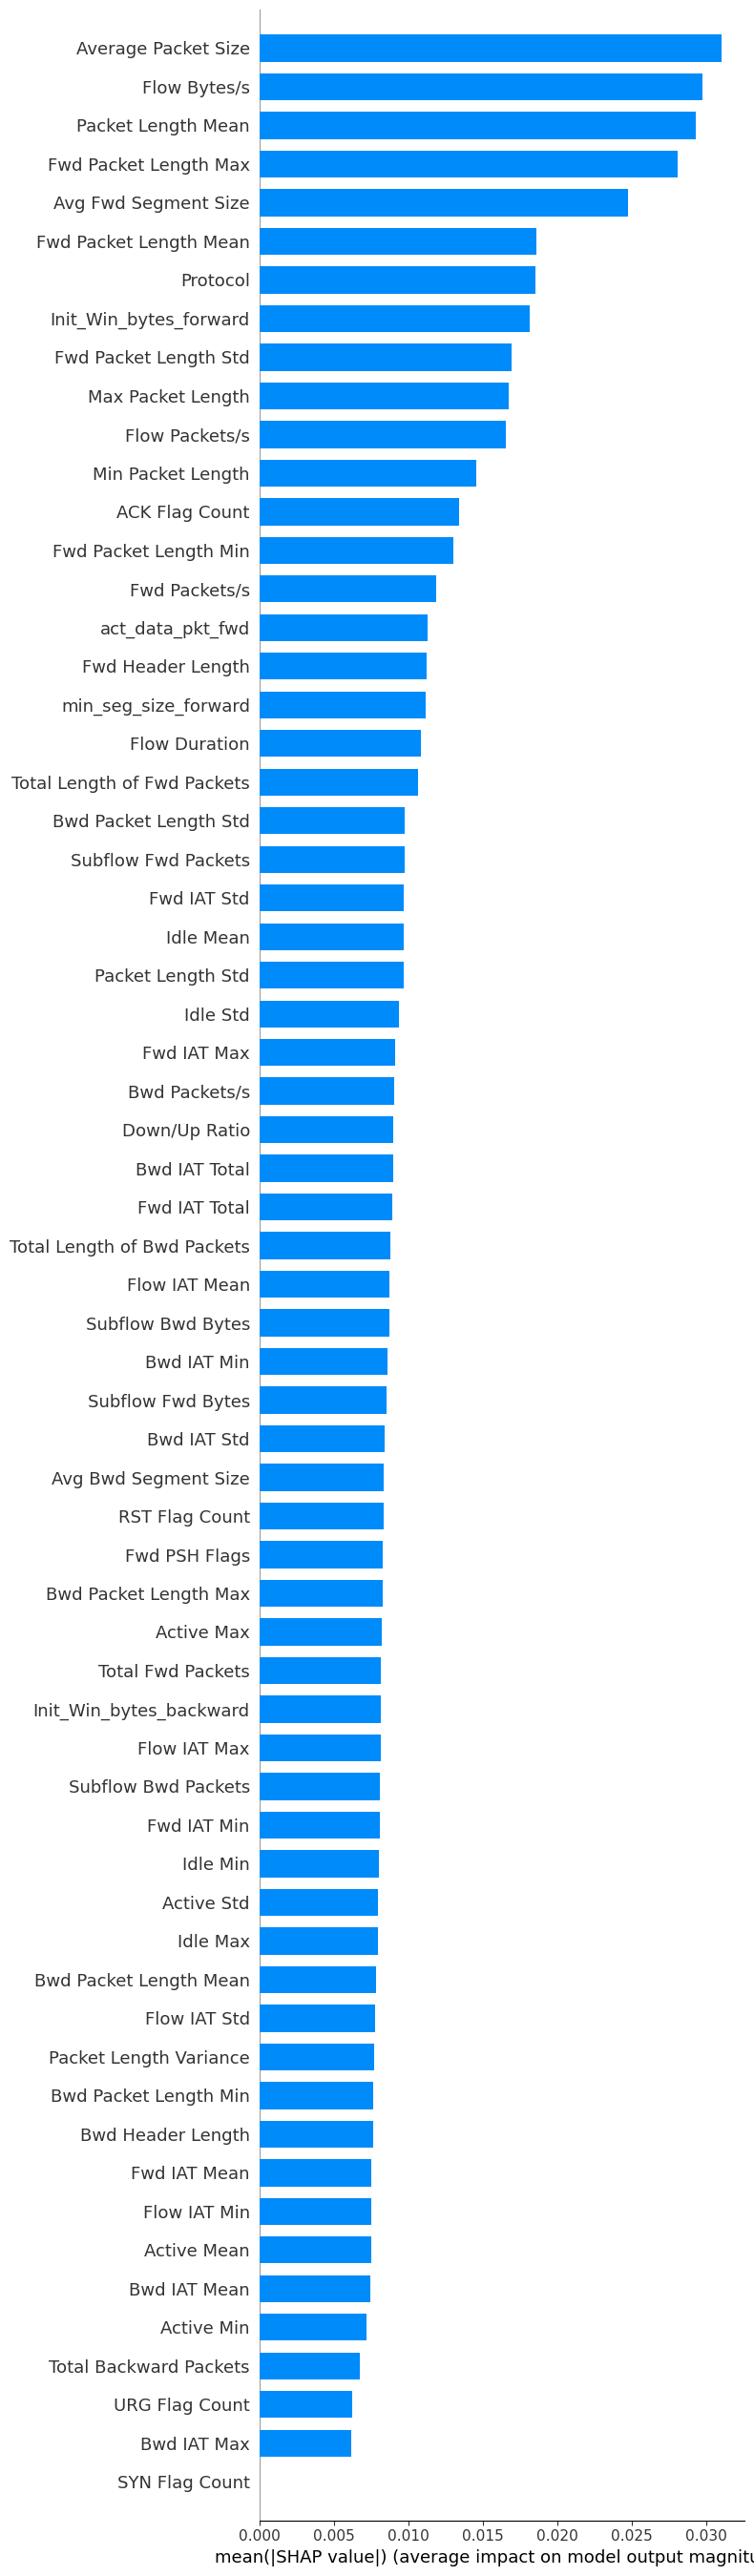

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 2


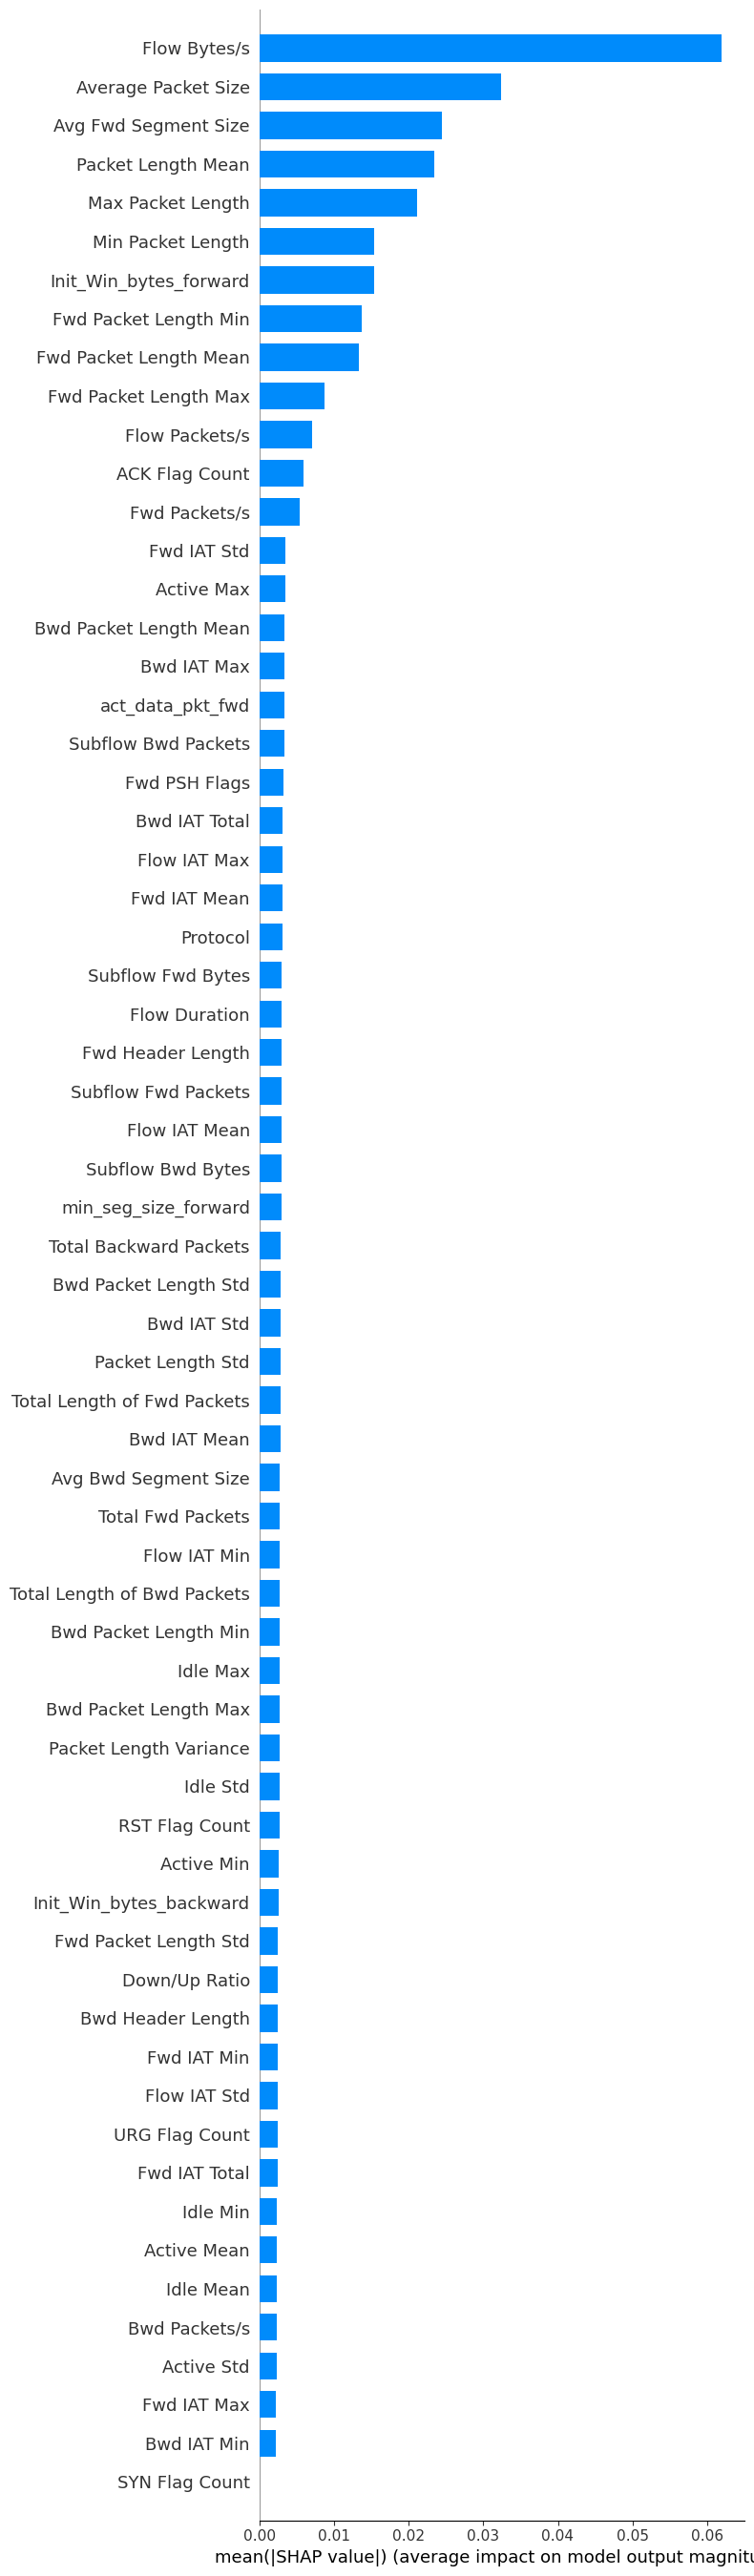

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 3


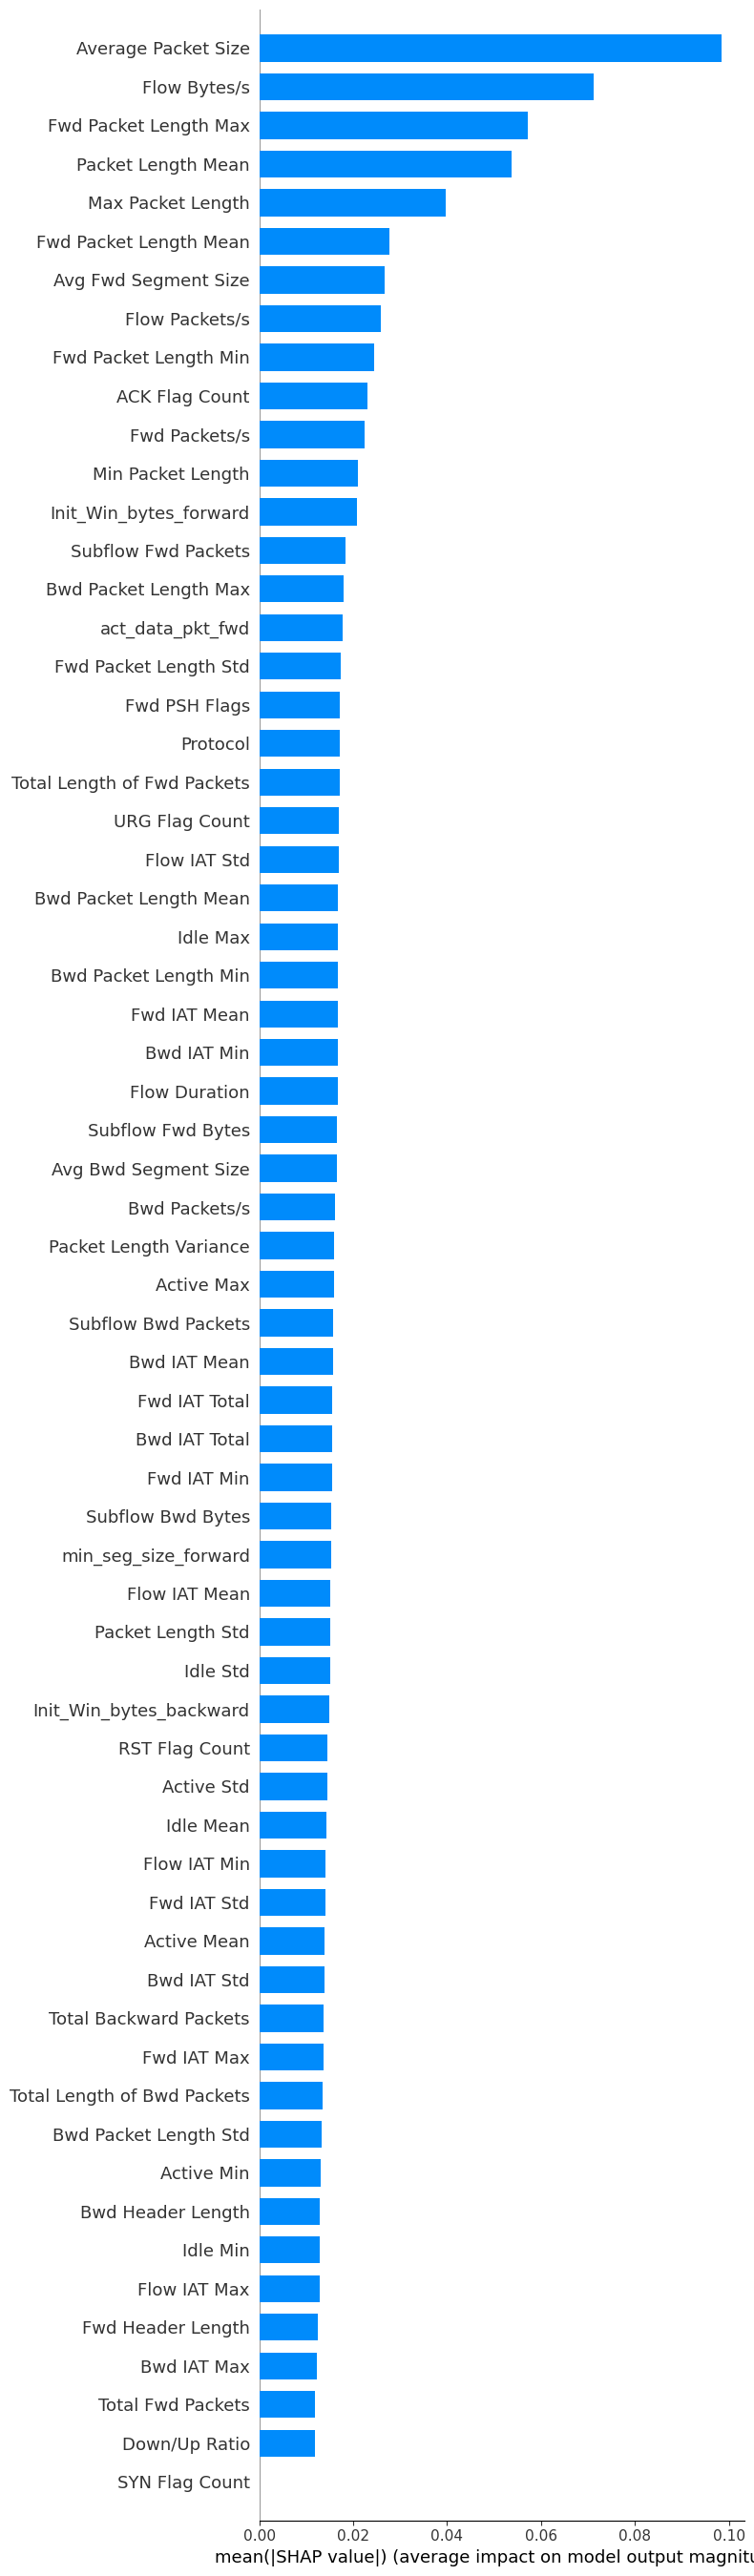

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 4


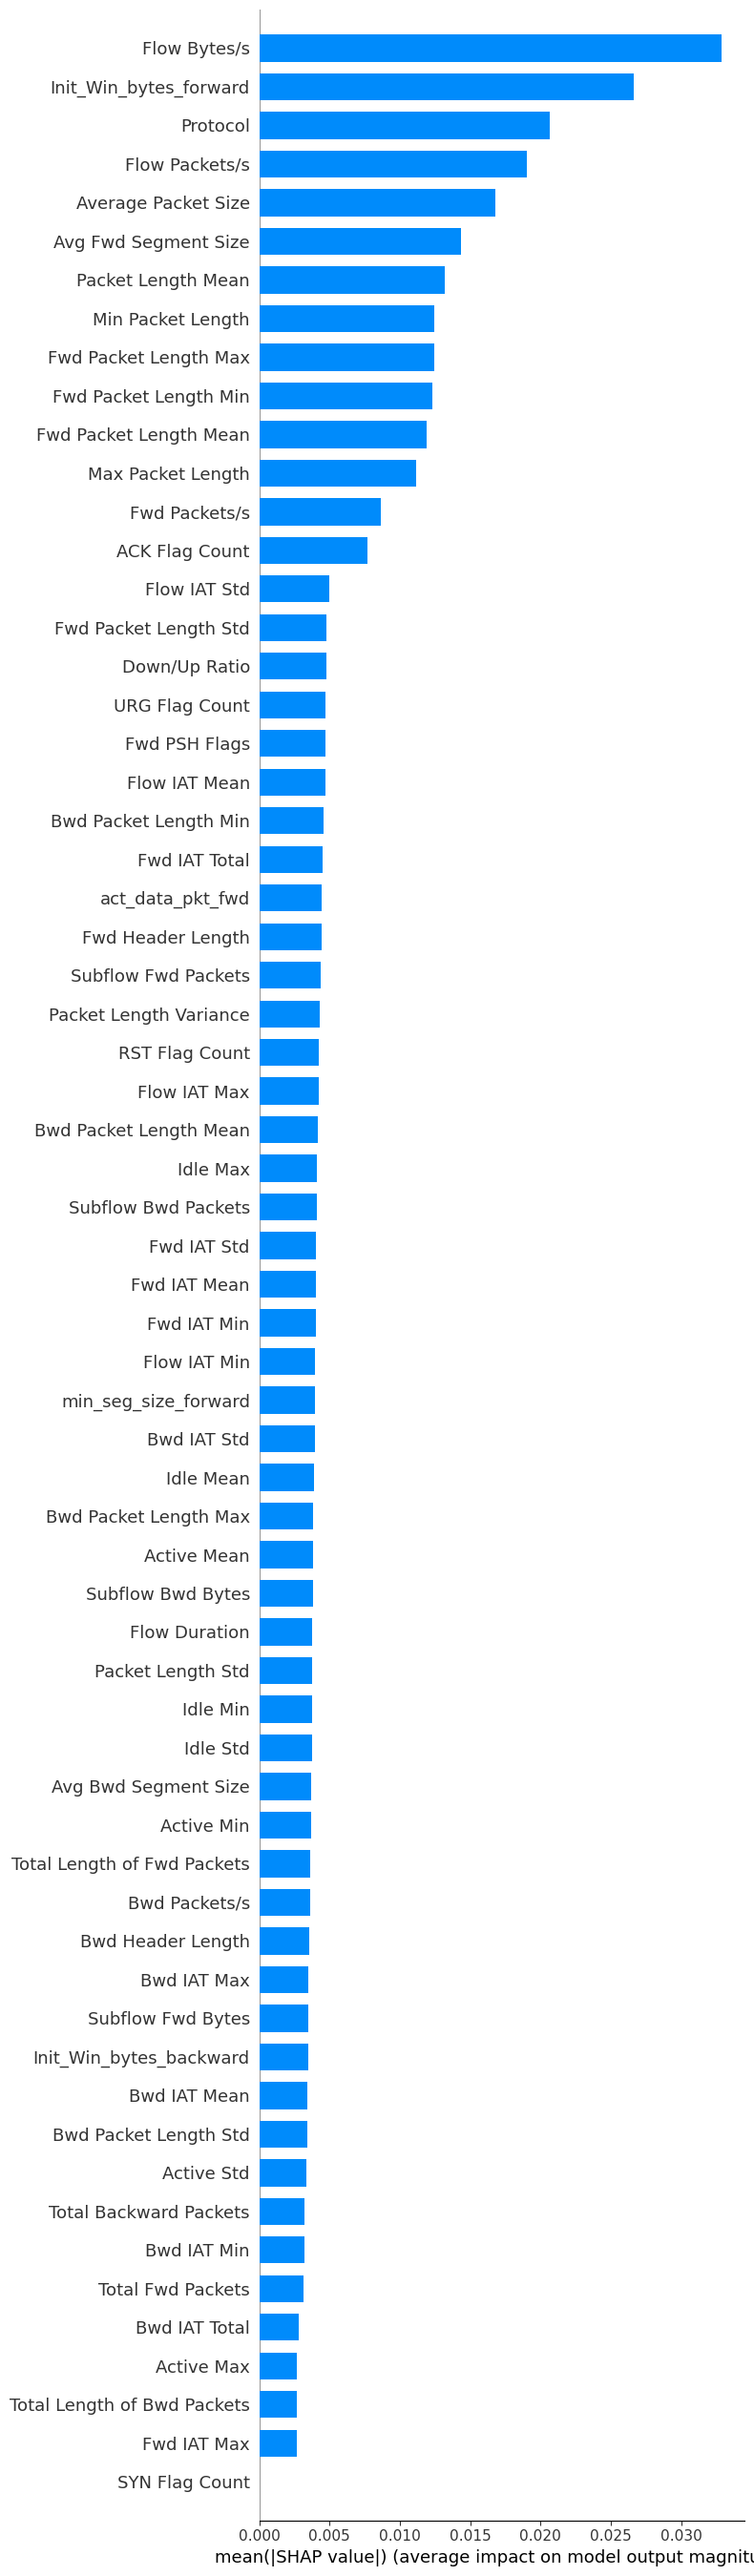

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 5


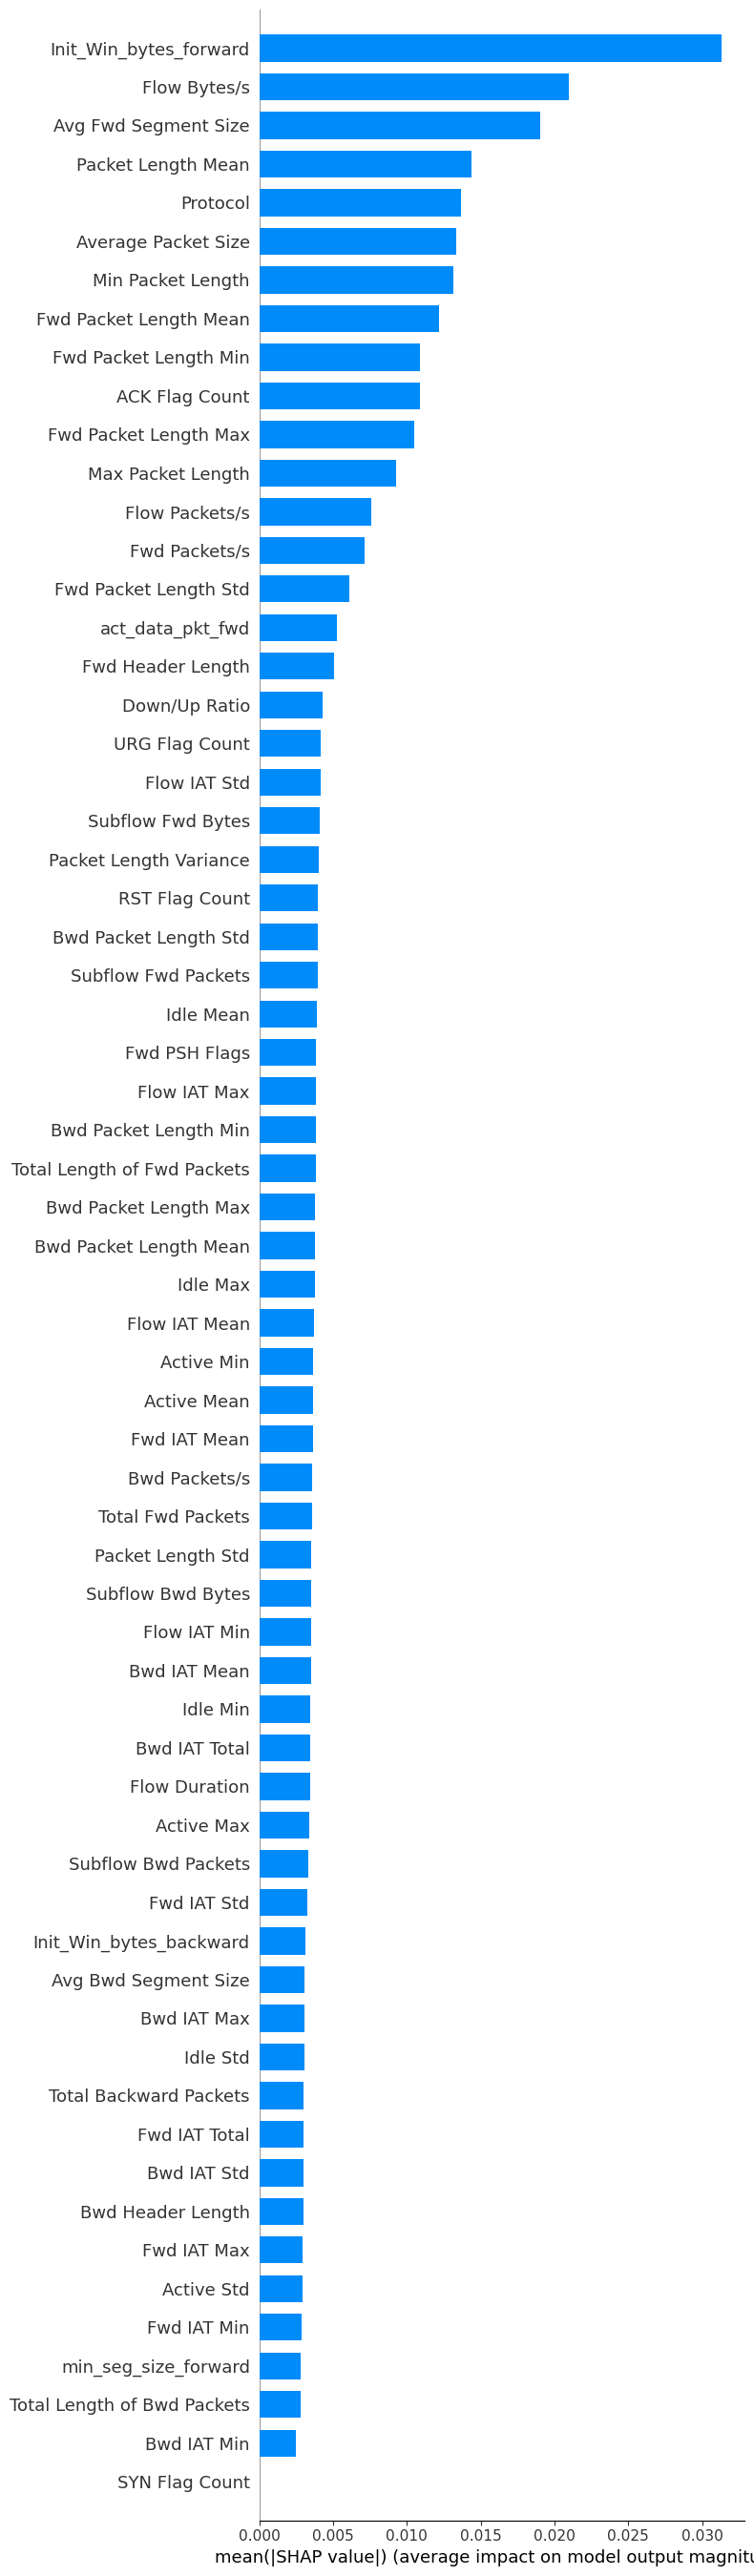

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 6


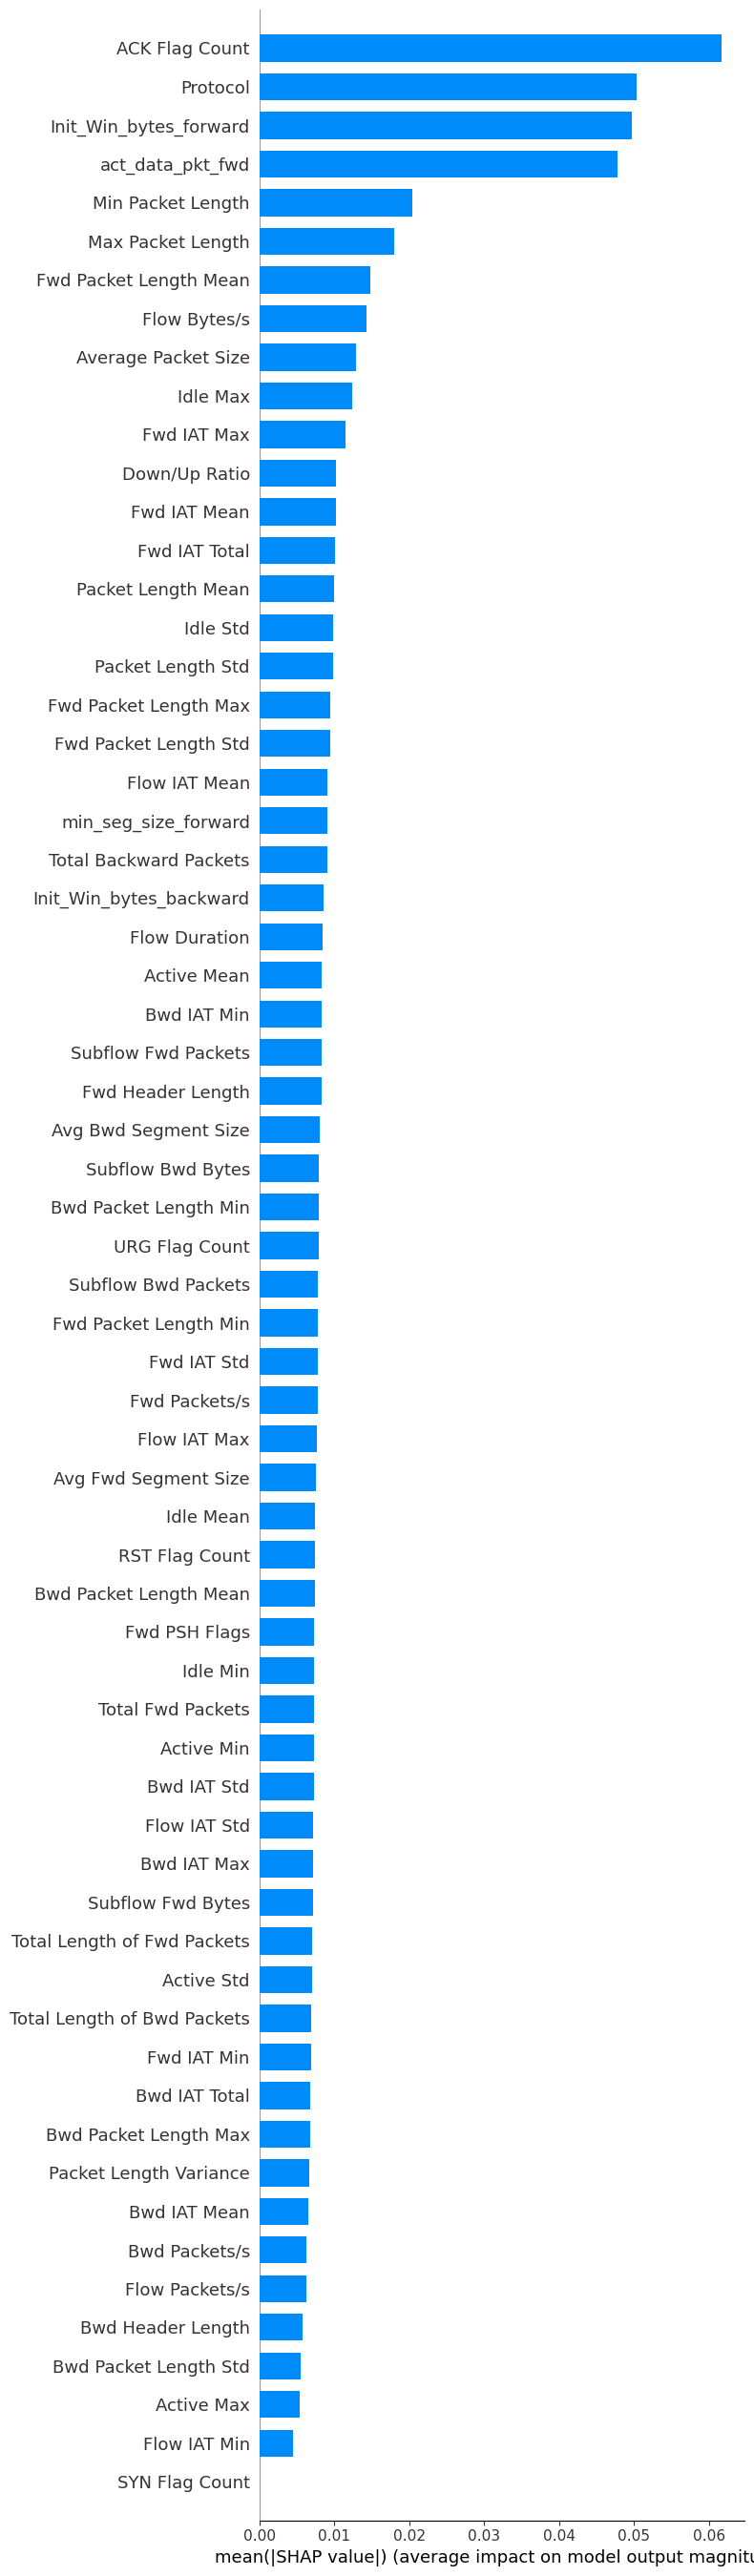

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 7


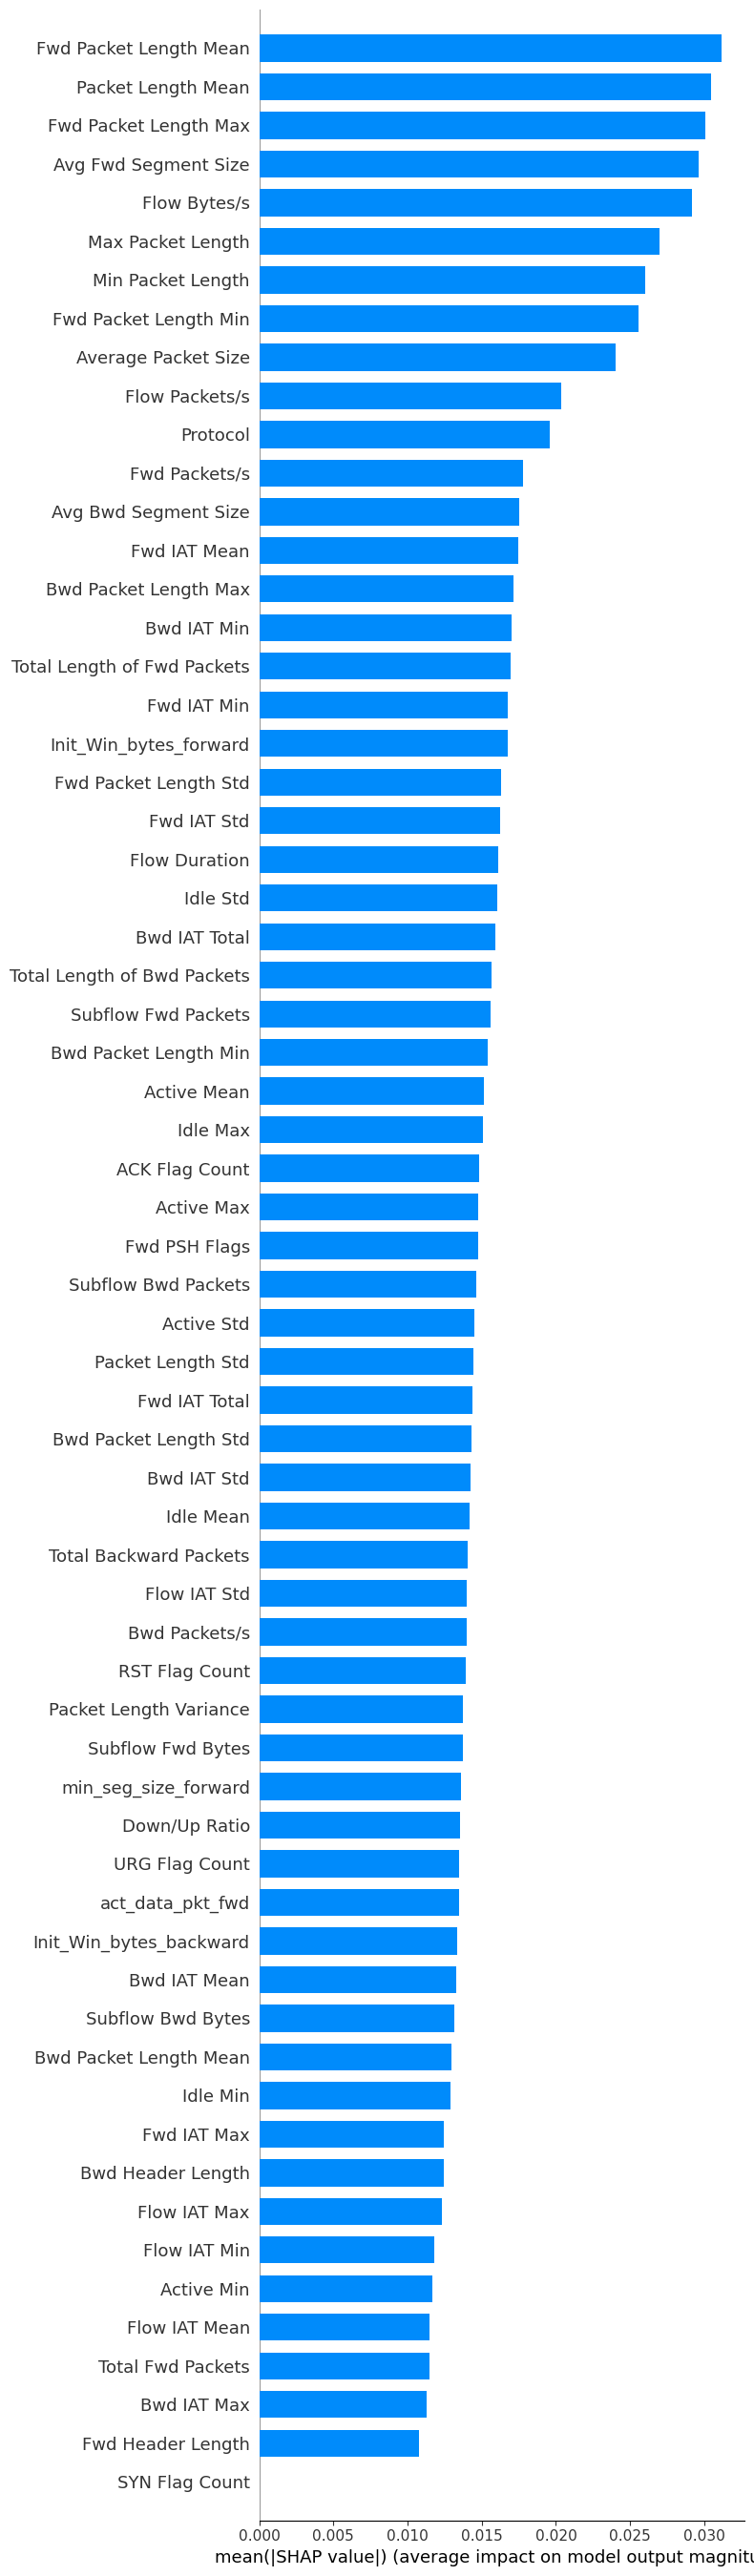

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 8


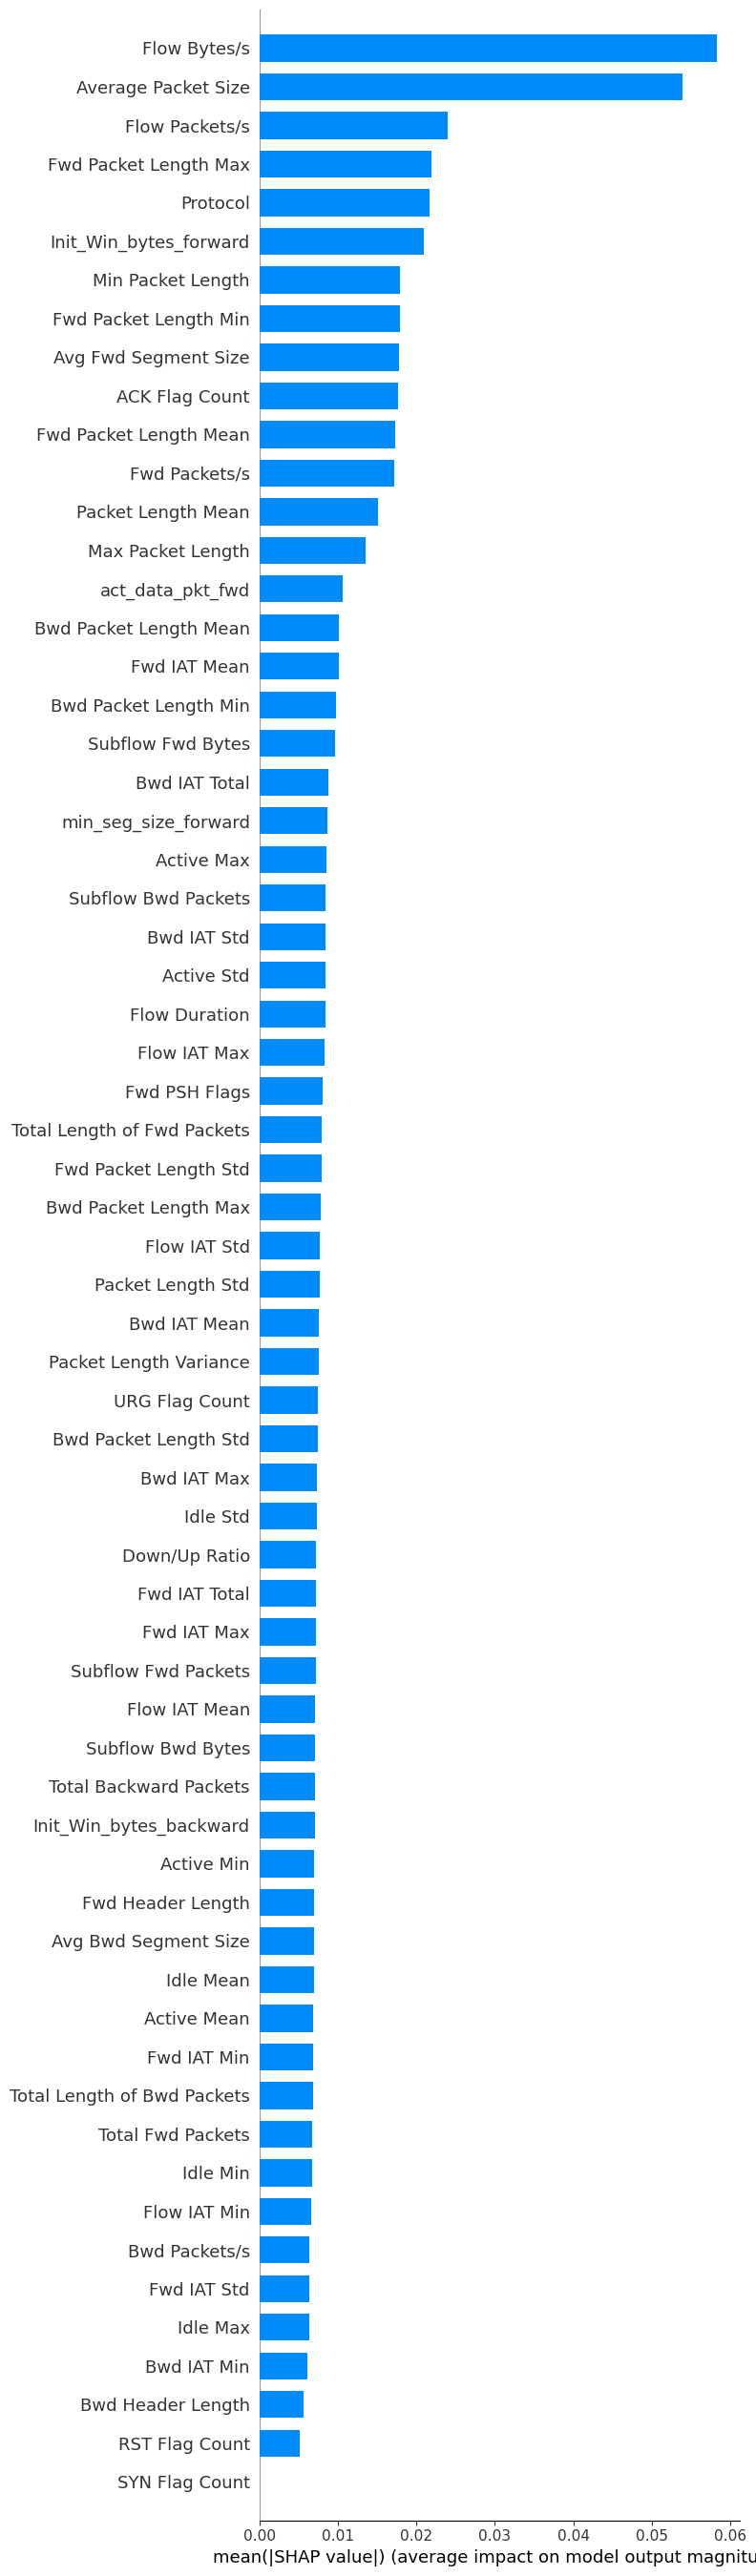

<Figure size 640x480 with 0 Axes>

Plotting SHAP values for class 9


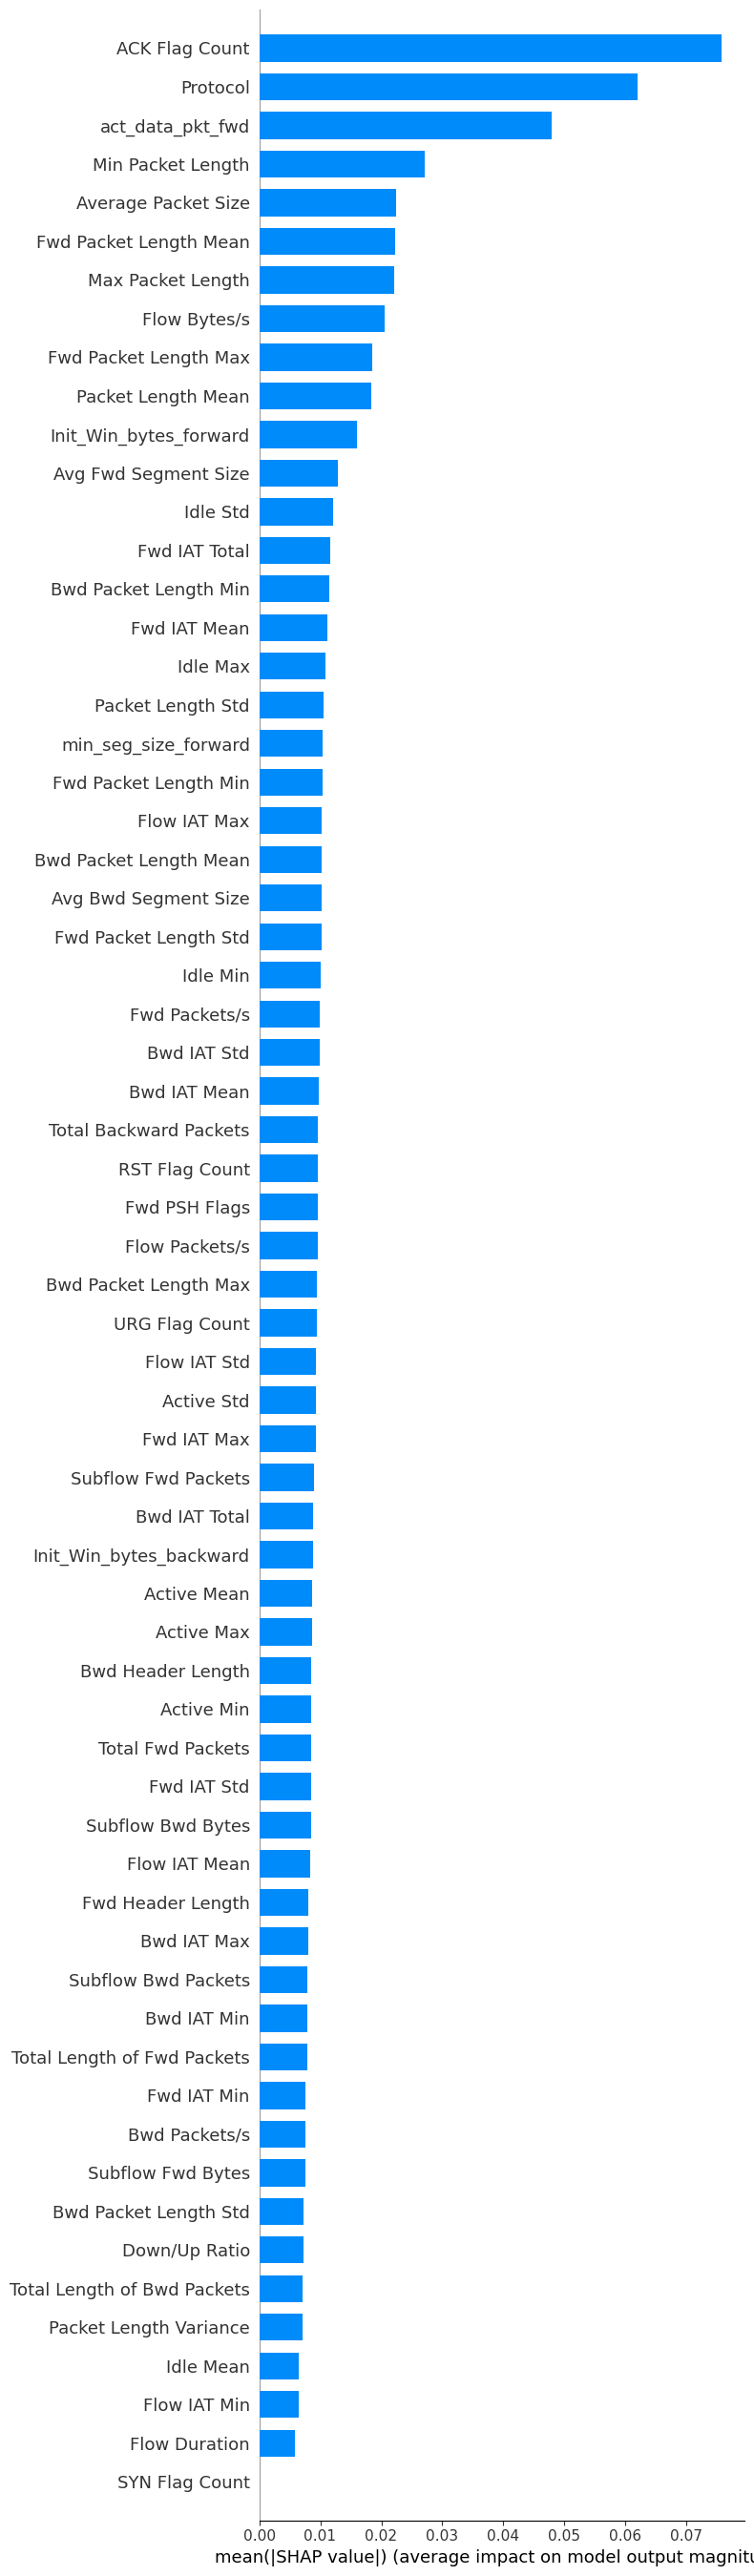

<Figure size 640x480 with 0 Axes>

In [44]:
#np.savetxt('testV3.1.txt',shap_values)


#shap_values = np.loadtxt('testV3.1.txt')
#print(shap_values.shape)

# Save SHAP values to a file
np.save('test1.npy', shap_values)

# Load SHAP values from the file
shap_values = np.load('test1.npy', allow_pickle=True)

# Inspect the shape of shap_values and data1
print(f"Shape of shap_values: {shap_values.shape}")
print(f"Shape of data1: {data1.shape}")

# Verify the number of features
features = features[:X_trainArr.shape[1]]
print(f"Number of features: {len(features)}")

# Calculate the mean absolute SHAP values across all classes
shap_values_mean = np.abs(shap_values).mean(axis=2)

print(f"Shape of shap_values_mean: {shap_values_mean.shape}")

# Plot the mean SHAP values
shap.summary_plot(shap_values_mean, data1, feature_names=features, max_display=75)

# If you want to see SHAP values for each class individually:
for i in range(shap_values.shape[2]):
    print(f"Plotting SHAP values for class {i}")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values[:, :, i], 
        data1, 
        feature_names=features, 
        max_display=75, 
        plot_type="bar", 
        title=f"SHAP values for class {i}"
    )
    plt.tight_layout()
    plt.show()


    

Top 15 features by mean absolute SHAP value across all classes:
 1. ACK Flag Count                 = 0.038785
 2. Flow Bytes/s                   = 0.036520
 3. Average Packet Size            = 0.031282
 4. Init_Win_bytes_forward         = 0.028540
 5. Protocol                       = 0.024861
 6. Packet Length Mean             = 0.021661
 7. Fwd Packet Length Max          = 0.020446
 8. Max Packet Length              = 0.018538
 9. Min Packet Length              = 0.018252
10. Avg Fwd Segment Size           = 0.018243
11. Fwd Packet Length Mean         = 0.017548
12. act_data_pkt_fwd               = 0.016663
13. Fwd Packet Length Min          = 0.014898
14. Flow Packets/s                 = 0.013982
15. Fwd Packets/s                  = 0.011168


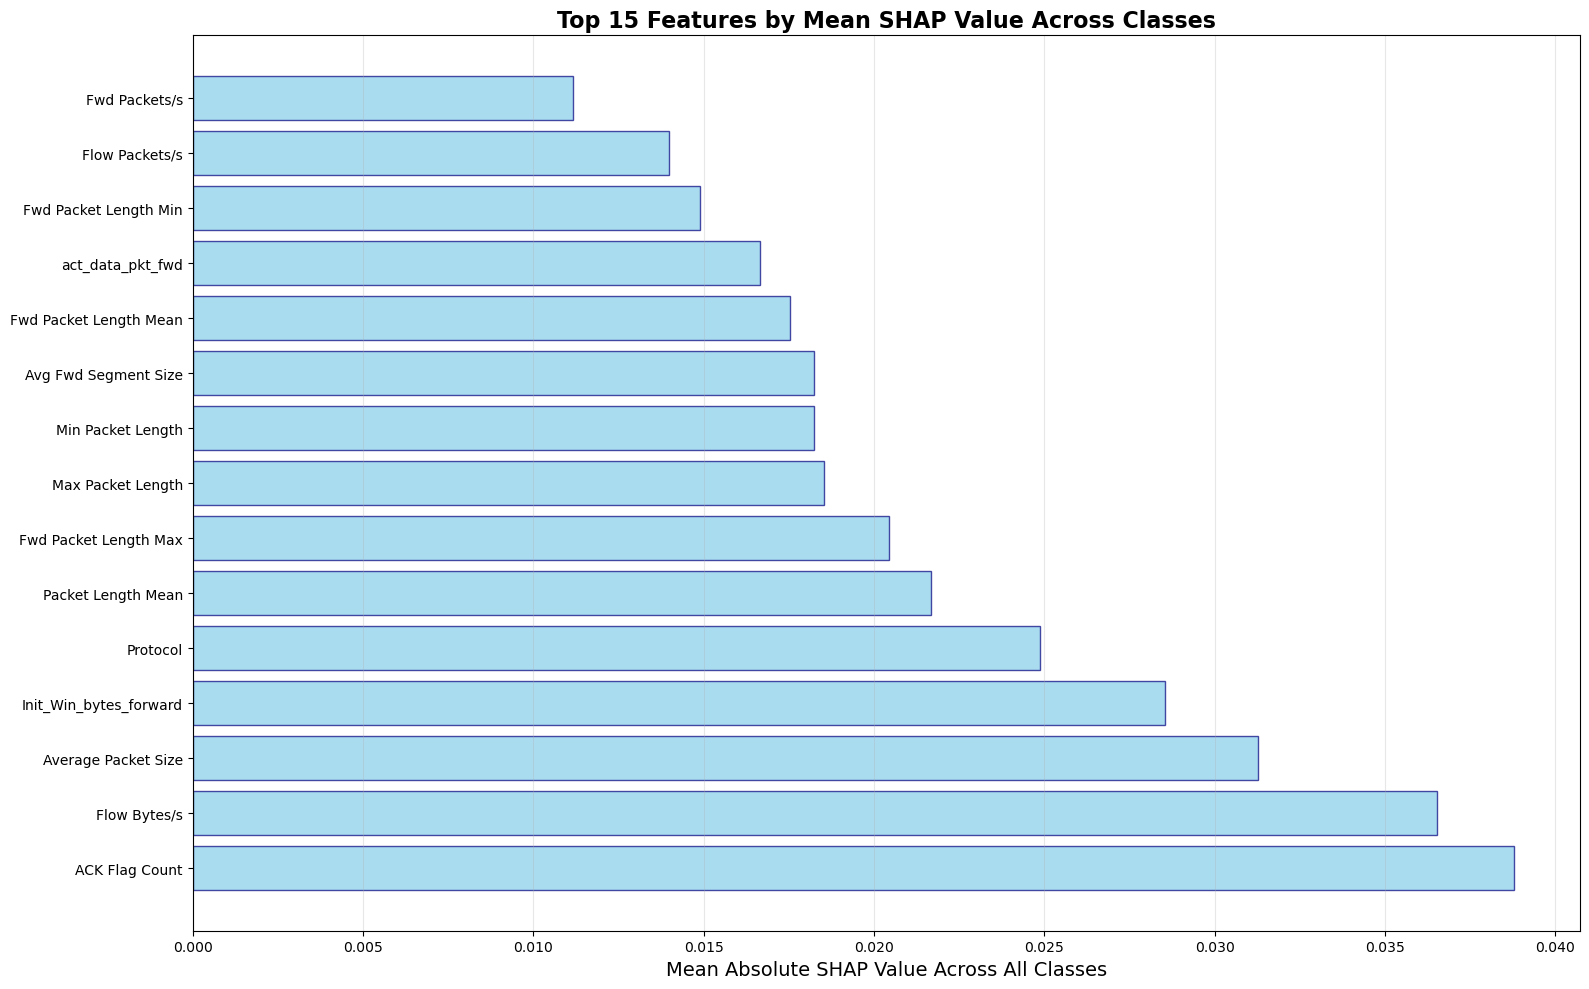

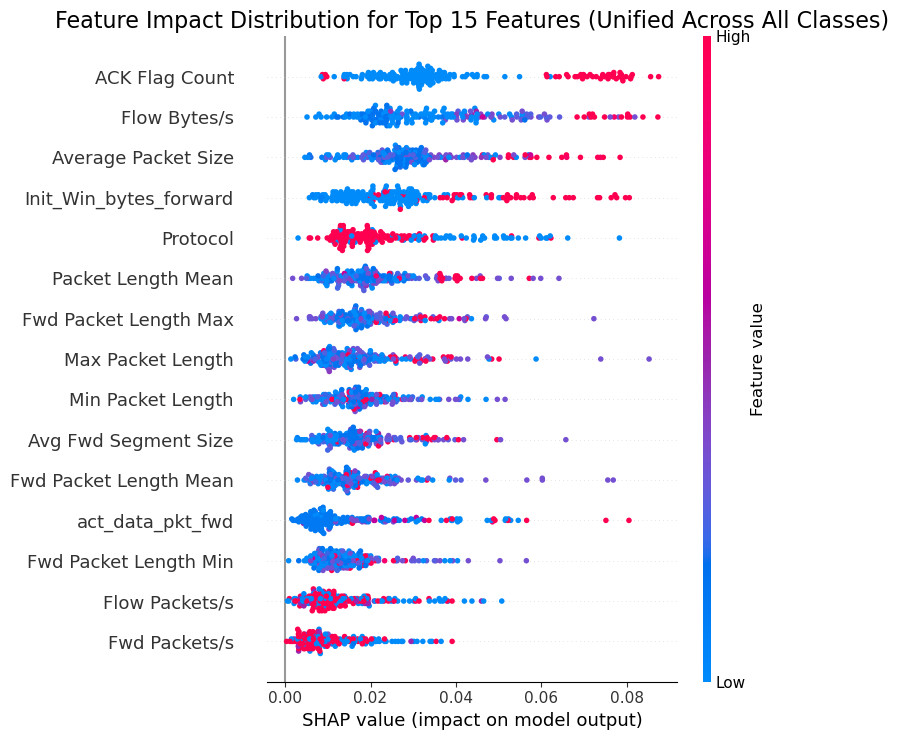

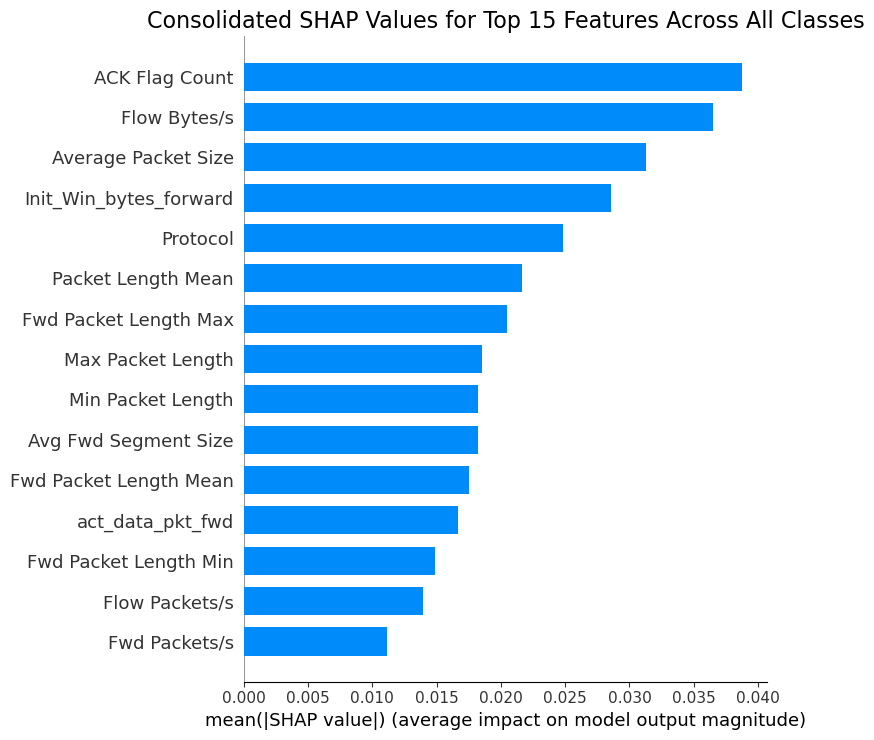


Mean absolute SHAP values by class for top 10 features:

1. ACK Flag Count:
   DoS            : 0.156959
   LDAP           : 0.013422
   BENIGN         : 0.005964
   UDP            : 0.022992
   Syn            : 0.007723
   TFTP           : 0.010874
   NetBIOS        : 0.061647
   UDPLag         : 0.014853
   MSSQL          : 0.017712
   Portmap        : 0.075704

2. Flow Bytes/s:
   DoS            : 0.026330
   LDAP           : 0.029723
   BENIGN         : 0.061896
   UDP            : 0.071203
   Syn            : 0.032850
   TFTP           : 0.020961
   NetBIOS        : 0.014289
   UDPLag         : 0.029167
   MSSQL          : 0.058305
   Portmap        : 0.020473

3. Average Packet Size:
   DoS            : 0.007612
   LDAP           : 0.031018
   BENIGN         : 0.032407
   UDP            : 0.098379
   Syn            : 0.016768
   TFTP           : 0.013316
   NetBIOS        : 0.012918
   UDPLag         : 0.023998
   MSSQL          : 0.053914
   Portmap        : 0.022489

4. Init_W

<Figure size 1600x1000 with 0 Axes>

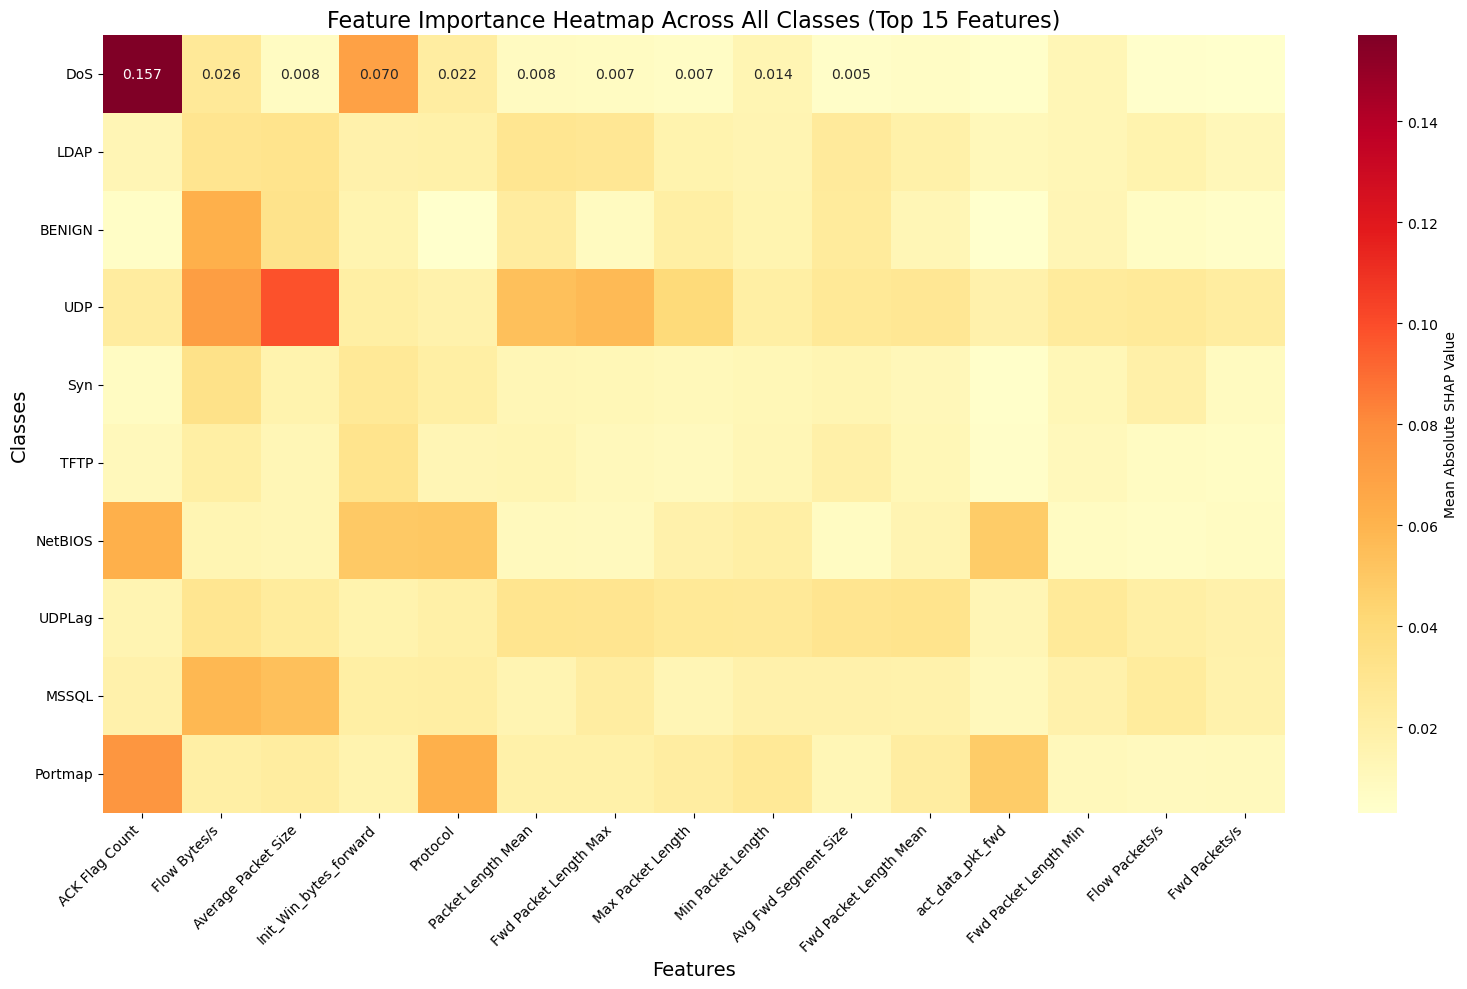


Generating bar charts for top 15 features...
Calculating limits for top 15 features...
Drawing bar charts for top 15 features...


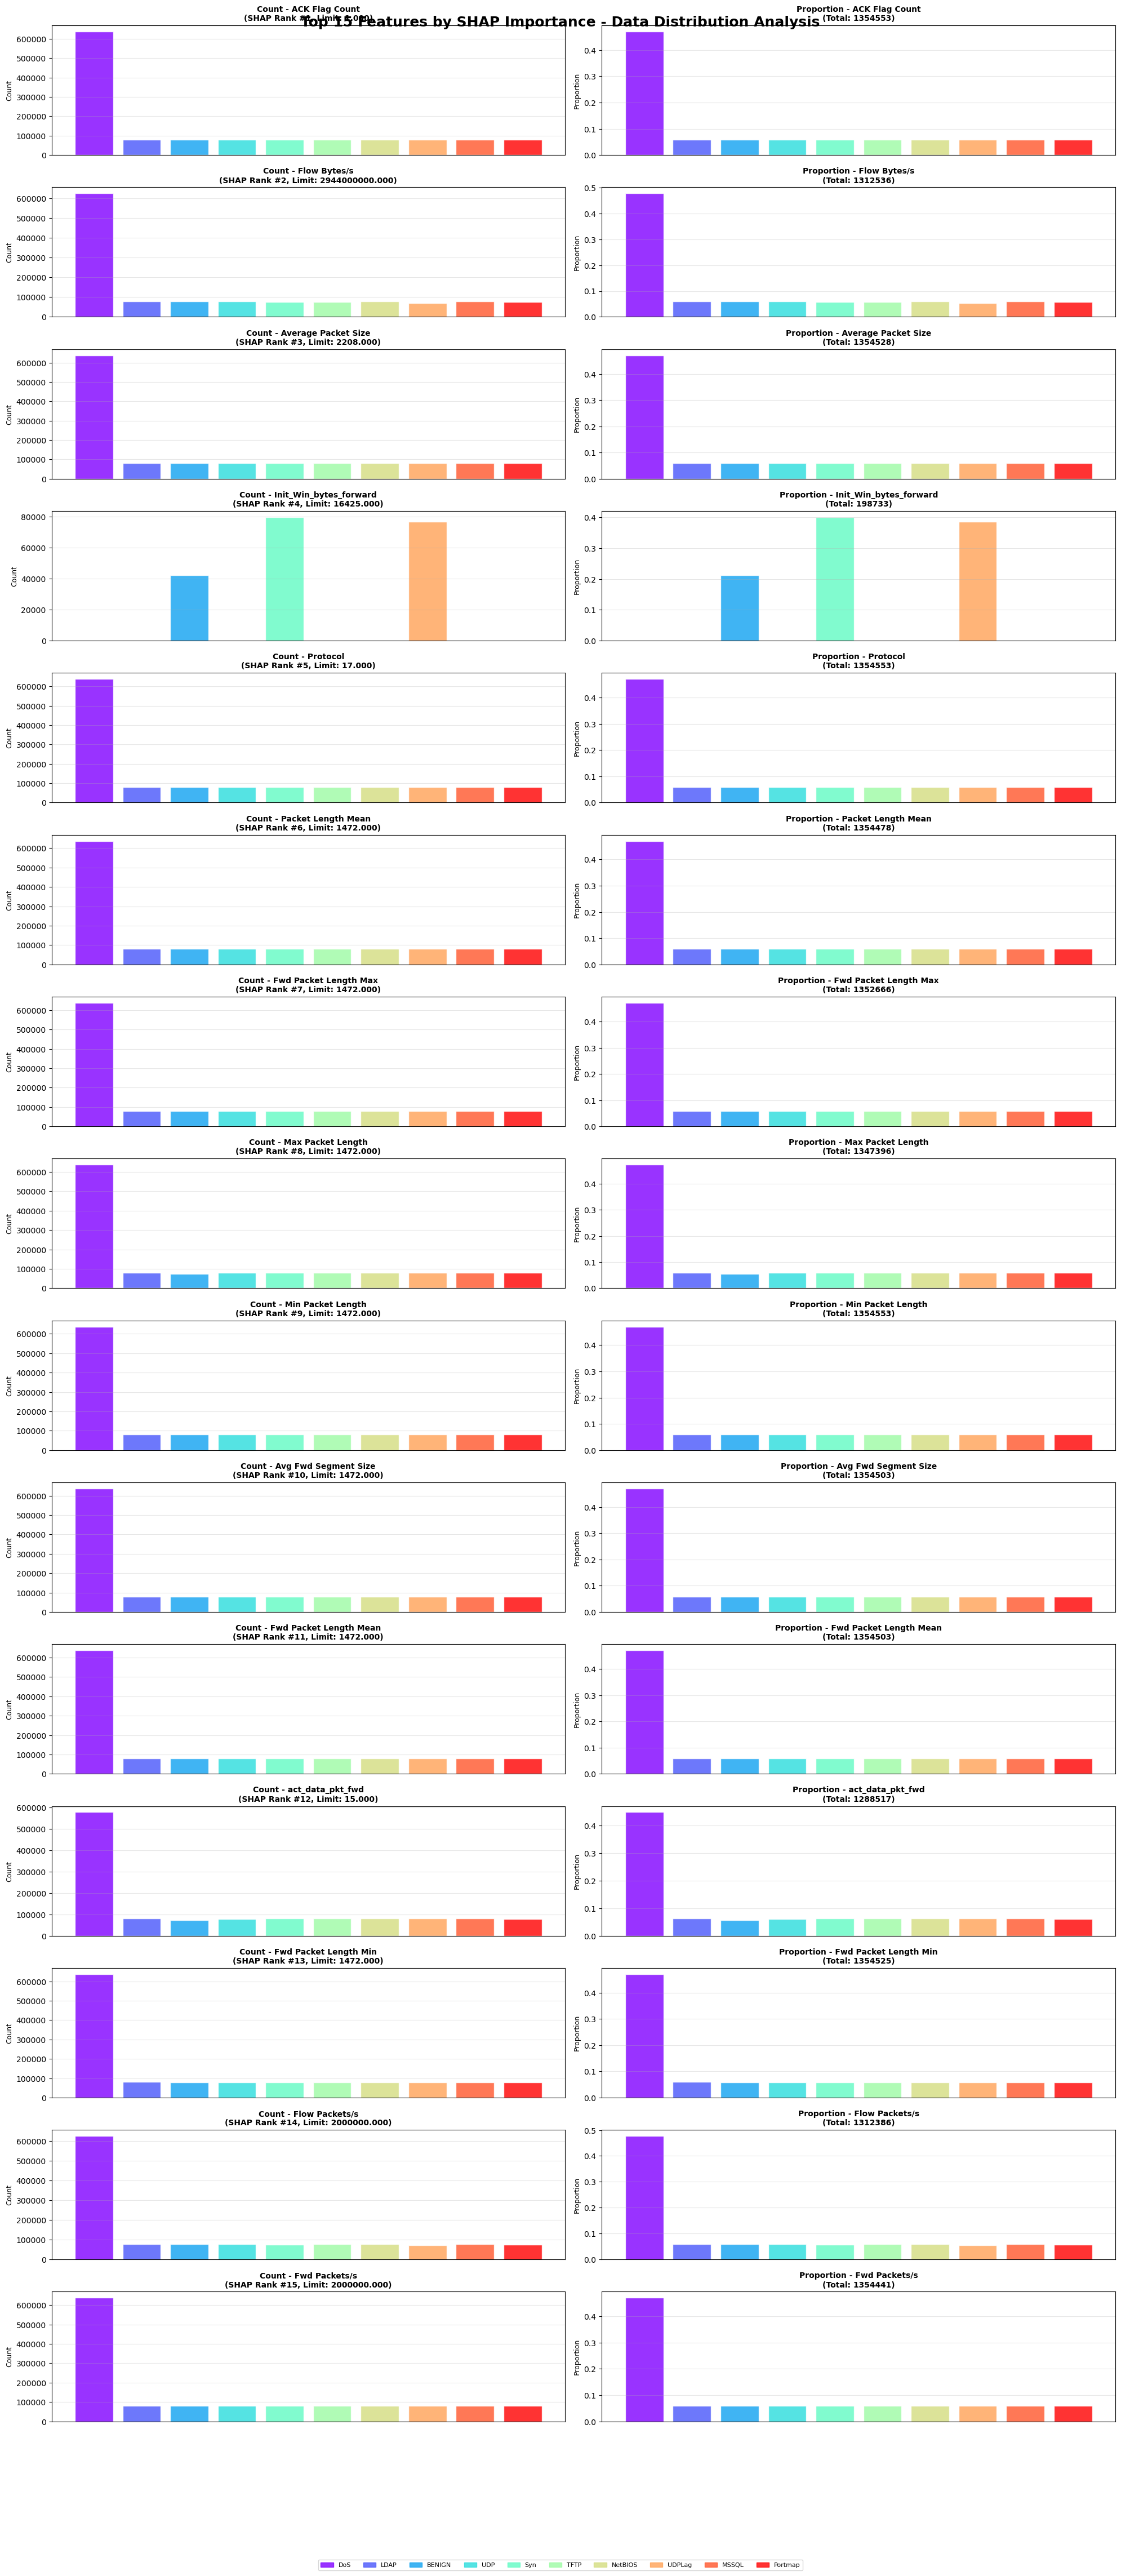


Visualization completed for top 15 features considering the DoS unified labeling.


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import pandas as pd

# Calculate mean absolute SHAP values across all classes and samples for each feature
# Shape of shap_values is (samples, features, classes)
mean_abs_shap_per_feature = np.mean(np.abs(shap_values), axis=(0, 2))

# Get the indices of features sorted by their mean absolute SHAP values (descending)
sorted_indices = np.argsort(mean_abs_shap_per_feature)[::-1]

# Select top 15 features
top_n = 15
top_indices = sorted_indices[:top_n]

# Get the feature names and their corresponding mean SHAP values
top_feature_names = [features[i] for i in top_indices]
top_feature_values = mean_abs_shap_per_feature[top_indices]

print(f"Top {top_n} features by mean absolute SHAP value across all classes:")
for i, (name, value) in enumerate(zip(top_feature_names, top_feature_values)):
    print(f"{i+1:2d}. {name:<30} = {value:.6f}")

# Create consolidated SHAP values for visualization
# Calculate mean absolute SHAP values across all classes for each sample and feature
consolidated_shap = np.zeros((shap_values.shape[0], len(top_indices)))

for i, idx in enumerate(top_indices):
    # Take absolute values and average across all classes for this feature
    consolidated_shap[:, i] = np.mean(np.abs(shap_values[:, idx, :]), axis=1)

# Create a subset of data1 with top 15 features
data1_subset = data1[:, top_indices]

# Create a custom dataframe for better visualization
df_plot = pd.DataFrame(data1_subset, columns=top_feature_names)

# Create the main bar plot showing mean SHAP values for top 15 features
plt.figure(figsize=(16, 10))
y_pos = np.arange(len(top_feature_names))
plt.barh(y_pos, top_feature_values, color='skyblue', edgecolor='navy', alpha=0.7)
plt.yticks(y_pos, top_feature_names, fontsize=10)
plt.xlabel('Mean Absolute SHAP Value Across All Classes', fontsize=14)
plt.title(f'Top {top_n} Features by Mean SHAP Value Across Classes', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Create the consolidated SHAP summary plot (beeswarm style) for top 15 features
plt.figure(figsize=(14, 10))
shap.summary_plot(
    consolidated_shap, 
    df_plot,
    plot_type="dot",
    feature_names=top_feature_names,
    show=False,
    max_display=len(top_indices)
)
plt.title(f"Feature Impact Distribution for Top {top_n} Features (Unified Across All Classes)", fontsize=16)
plt.tight_layout()
plt.show()

# Create a bar plot version as well for top 15 features
plt.figure(figsize=(14, 10))
shap.summary_plot(
    consolidated_shap, 
    df_plot,
    plot_type="bar",
    feature_names=top_feature_names,
    show=False,
    max_display=len(top_indices)
)
plt.title(f"Consolidated SHAP Values for Top {top_n} Features Across All Classes", fontsize=16)
plt.tight_layout()
plt.show()

# Additional analysis: Show SHAP value contribution by class for top 10 features
print(f"\nMean absolute SHAP values by class for top 10 features:")
top_10_indices = sorted_indices[:10]
for i, feature_idx in enumerate(top_10_indices):
    feature_name = features[feature_idx]
    print(f"\n{i+1}. {feature_name}:")
    class_contributions = np.mean(np.abs(shap_values[:, feature_idx, :]), axis=0)
    for class_idx, contribution in enumerate(class_contributions):
        # Usar las clases de tu contexto
        class_name = unique_labels[class_idx] if class_idx < len(unique_labels) else f"Class_{class_idx}"
        print(f"   {class_name:<15}: {contribution:.6f}")

# Create a heatmap showing feature importance across all classes for top 15 features
plt.figure(figsize=(16, 10))
class_feature_matrix = np.zeros((len(unique_labels), len(top_indices)))

for i, feature_idx in enumerate(top_indices):
    class_contributions = np.mean(np.abs(shap_values[:, feature_idx, :]), axis=0)
    class_feature_matrix[:, i] = class_contributions

# Create heatmap
import seaborn as sns
plt.figure(figsize=(16, 10))
sns.heatmap(class_feature_matrix, 
            xticklabels=top_feature_names,
            yticklabels=unique_labels,  # Usar unique_labels de tu contexto
            annot=True,  # Enable annotations for top 15 features
            fmt='.3f', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Mean Absolute SHAP Value'})
plt.title(f'Feature Importance Heatmap Across All Classes (Top {top_n} Features)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Classes', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Generate bar charts for top 15 features
print(f"\nGenerating bar charts for top {top_n} features...")

# Define labels for your context (simplified with DoS mapping)
labels_mapped = unique_labels  # Using your unified labels
colors = plt.cm.rainbow(np.linspace(0, 1, len(labels_mapped)))

# Function to calculate smart limits based on percentiles
def calculate_smart_limit(feature_name, percentile=95):
    """Calculate smart limit based on percentiles to avoid extreme outliers"""
    if feature_name in dataset.columns:
        all_data = dataset[feature_name]
        all_data = all_data[(all_data != -1) & (all_data != np.inf) & (~np.isnan(all_data))]
        if len(all_data) > 0:
            limit = np.percentile(all_data, percentile)
            if limit <= 0:
                limit = np.percentile(all_data[all_data > 0], percentile) if np.any(all_data > 0) else 1
            return limit
    return 1

# Calculate limits automatically for top 15 features
print("Calculating limits for top 15 features...")
all_limits = []
for feature in top_feature_names:
    limit = calculate_smart_limit(feature, percentile=95)
    all_limits.append(limit)

# Create figure for top 15 features
rows = len(top_feature_names)
fig, axs = plt.subplots(rows, 2, figsize=(20, rows * 3))

# Function to calculate bar data
def calculate_bar_data(feature, limit):
    data = []
    for label in labels_mapped:
        if feature in dataset.columns:
            feature_data = dataset[dataset['Label'] == label][feature]
            feature_data = feature_data[(feature_data != -1) & 
                                      (feature_data != np.inf) & 
                                      (~np.isnan(feature_data)) & 
                                      (feature_data <= limit)]
            data.append(len(feature_data))
        else:
            data.append(0)
    return data

# Draw bar charts for each feature
print("Drawing bar charts for top 15 features...")
for i, (feature, limit) in enumerate(zip(top_feature_names, all_limits)):
    # Calculate bar data
    data = calculate_bar_data(feature, limit)
    
    # Count bar chart
    axs[i, 0].bar(range(len(labels_mapped)), data, color=colors, edgecolor='white', alpha=0.8)
    axs[i, 0].set_title(f'Count - {feature}\n(SHAP Rank #{i+1}, Limit: {limit:.3f})', fontsize=10, fontweight='bold')
    axs[i, 0].set_ylabel('Count', fontsize=9)
    axs[i, 0].set_xticks([])
    axs[i, 0].grid(axis='y', alpha=0.3)
    
    # Normalized bar chart
    total_samples = sum(data)
    if total_samples > 0:
        data_normalized = np.array(data) / total_samples
    else:
        data_normalized = np.zeros_like(data)
    
    axs[i, 1].bar(range(len(labels_mapped)), data_normalized, color=colors, edgecolor='white', alpha=0.8)
    axs[i, 1].set_title(f'Proportion - {feature}\n(Total: {total_samples})', fontsize=10, fontweight='bold')
    axs[i, 1].set_ylabel('Proportion', fontsize=9)
    axs[i, 1].set_xticks([])
    axs[i, 1].grid(axis='y', alpha=0.3)

# Add common legend
handles = [plt.Rectangle((0,0),1,1, color=color, alpha=0.8) for color in colors]
fig.legend(handles, labels_mapped, loc='lower center', ncol=len(labels_mapped), bbox_to_anchor=(0.5, -0.01), fontsize=8)

# Add general title
fig.suptitle(f'Top {top_n} Features by SHAP Importance - Data Distribution Analysis', fontsize=18, fontweight='bold', y=0.999)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.05, top=0.995)
plt.show()

print(f"\nVisualization completed for top {top_n} features considering the DoS unified labeling.")

#### DECISION TREE

In [46]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import tree


# Assuming X_train, X_test, Y_train, Labels are already defined
# Convert pandas dataframes to numpy arrays if necessary
X_trainArr = X_train.to_numpy() if not isinstance(X_train, np.ndarray) else X_train
X_testArr = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test

X_trainArr = X_trainArr[:, :64]
X_testArr = X_testArr[:, :64]

# Use LabelEncoder to convert string labels to integers
label_encoder = LabelEncoder()
Y_trainArr = label_encoder.fit_transform(Y_train)

LabelsArr = label_encoder.classes_

# Check if Y_trainArr and LabelsArr are integer arrays and within range
assert np.issubdtype(Y_trainArr.dtype, np.integer), "Y_trainArr must be an integer array"
assert Y_trainArr.min() >= 0 and Y_trainArr.max() < len(LabelsArr), "Y_trainArr values must be within the range of LabelsArr"

# Train the model
n_estimators = 500 #200
clf = RandomForestClassifier(random_state=0, n_estimators=n_estimators, max_depth=6)
clf = clf.fit(X_trainArr, Y_trainArr)

# Predict on the training data
Y_pred = clf.predict(X_trainArr)

# Mapping numerical labels to class labels
y_testree1 = [LabelsArr[i] for i in Y_trainArr]
y_predtree1 = [LabelsArr[i] for i in Y_pred]

# Verify that the lists are not empty
if not y_testree1:
    print("y_testree1 is empty!")
if not y_predtree1:
    print("y_predtree1 is empty!")

# Generate and print the classification report
print(classification_report(y_testree1, y_predtree1, digits=8, zero_division="warn"))

# Print accuracy
accuracy_modelo = accuracy_score(Y_trainArr, Y_pred)
print(accuracy_modelo)

c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      BENIGN  0.99629829 0.99527421 0.99578599     79775
         DoS  0.68972700 0.91461947 0.78641086    637499
        LDAP  0.00000000 0.00000000 0.00000000     79828
       MSSQL  0.00000000 0.00000000 0.00000000     79498
     NetBIOS  0.45535217 0.26662316 0.33632017     79678
     Portmap  0.40246625 0.78490618 0.53209632     79463
         Syn  0.99934634 0.90119648 0.94773703     79734
        TFTP  0.99772405 0.89069633 0.94117725     79732
         UDP  0.00000000 0.00000000 0.00000000     79745
      UDPLag  0.90559028 0.96462356 0.93417523     79601

    accuracy                      0.71295844   1354553
   macro avg  0.54465044 0.57179394 0.54737028   1354553
weighted avg  0.60445107 0.71295844 0.64583988   1354553

0.7129584445938992


c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ecaba\anaconda3\envs\tfm2025\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      BENIGN  0.99629829 0.99527421 0.99578599     79775
         DoS  0.68972700 0.91461947 0.78641086    637499
        LDAP  0.00000000 0.00000000 0.00000000     79828
       MSSQL  0.00000000 0.00000000 0.00000000     79498
     NetBIOS  0.45535217 0.26662316 0.33632017     79678
     Portmap  0.40246625 0.78490618 0.53209632     79463
         Syn  0.99934634 0.90119648 0.94773703     79734
        TFTP  0.99772405 0.89069633 0.94117725     79732
         UDP  0.00000000 0.00000000 0.00000000     79745
      UDPLag  0.90559028 0.96462356 0.93417523     79601

    accuracy                      0.71295844   1354553
   macro avg  0.54465044 0.57179394 0.54737028   1354553
weighted avg  0.60445107 0.71295844 0.64583988   1354553

0.7129584445938992


100%|██████████| 500/500 [03:31<00:00,  2.36it/s]


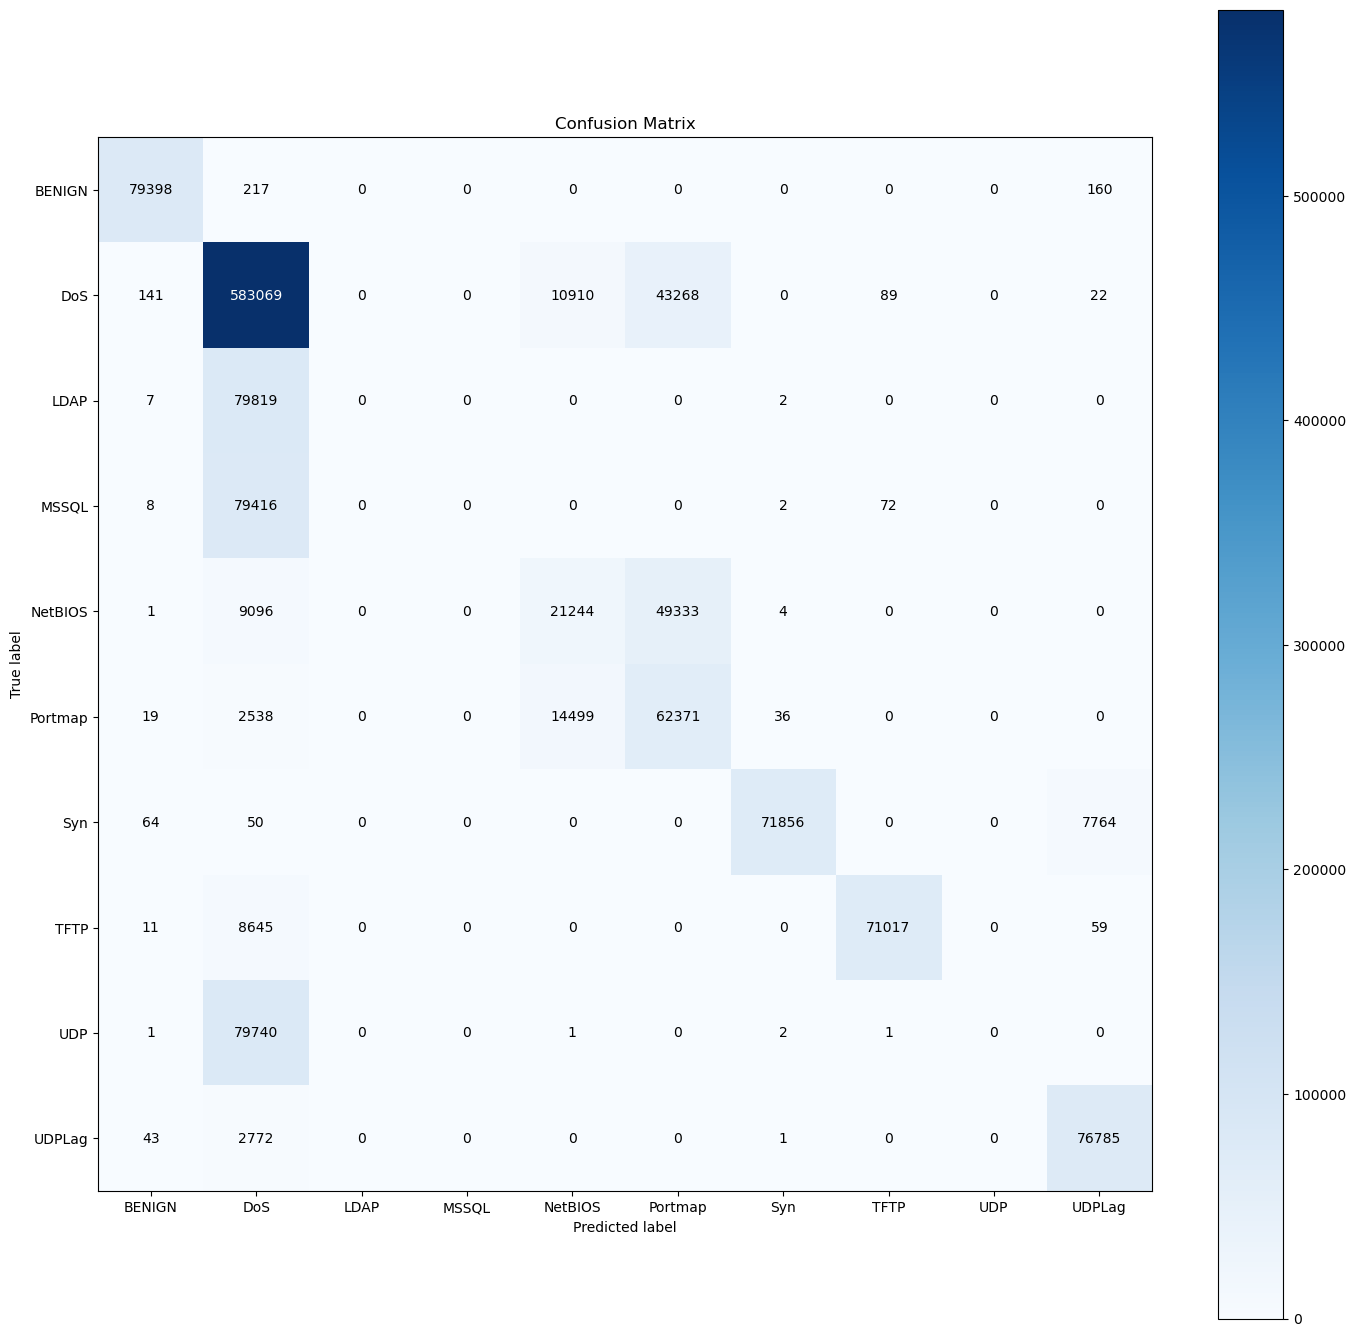

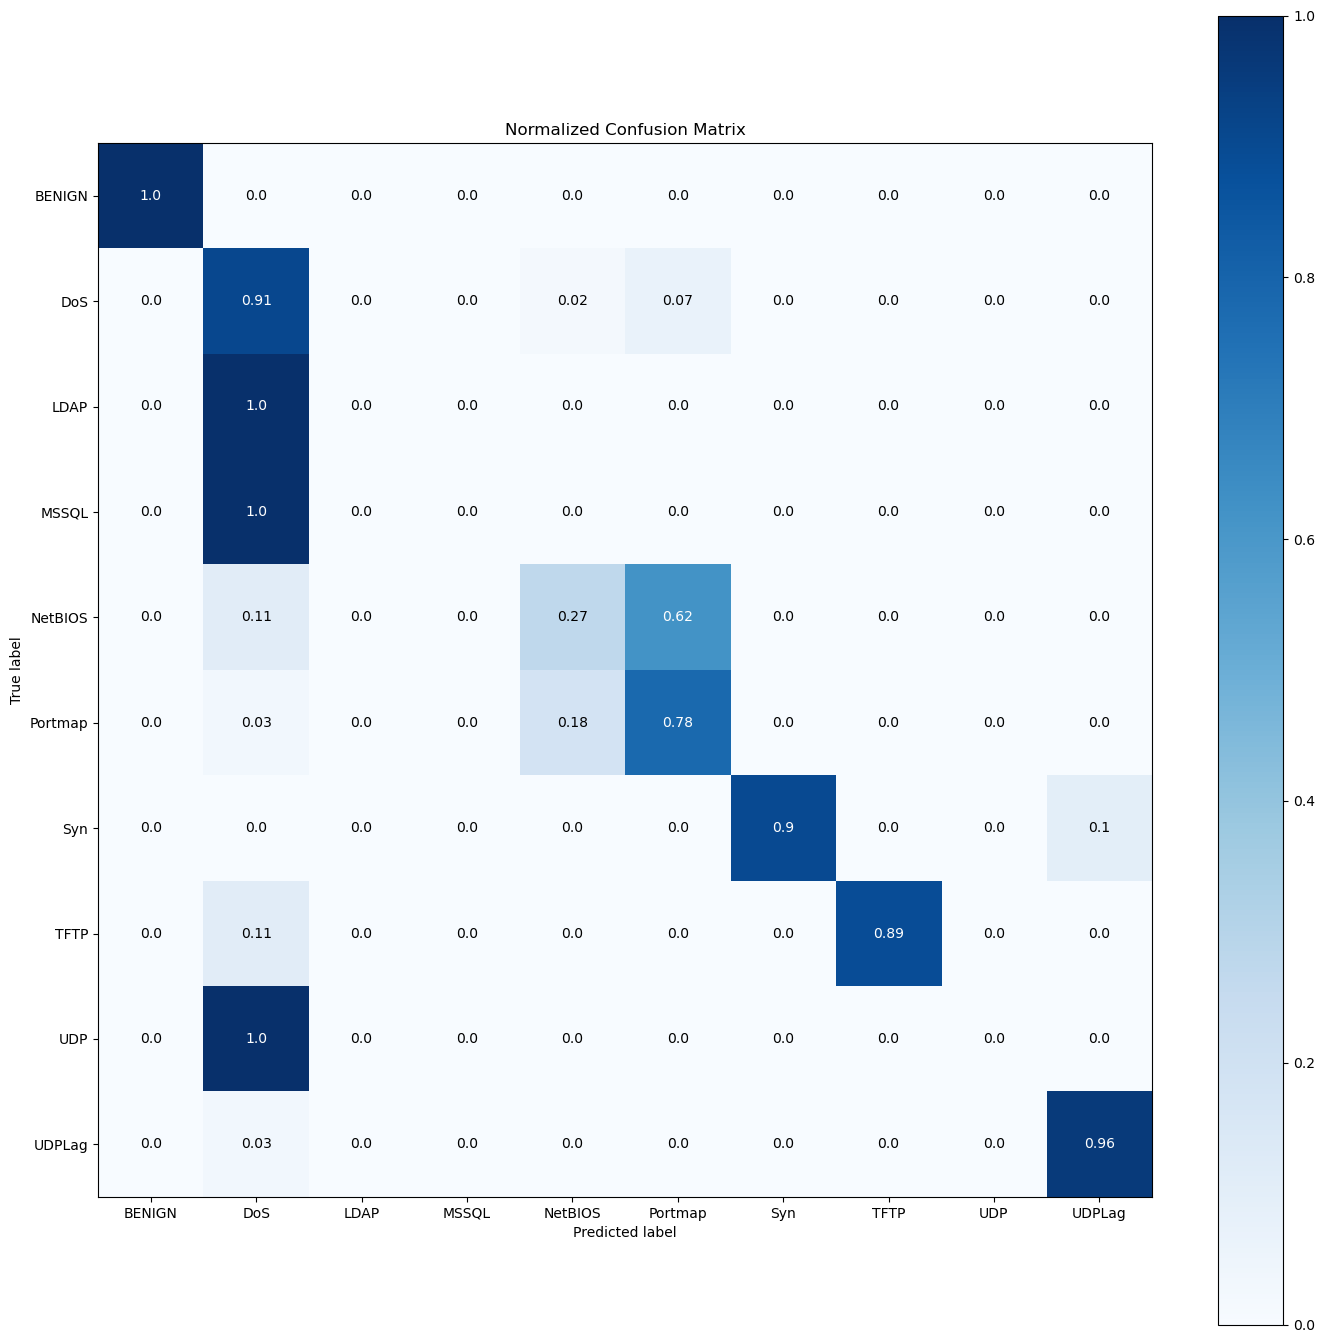

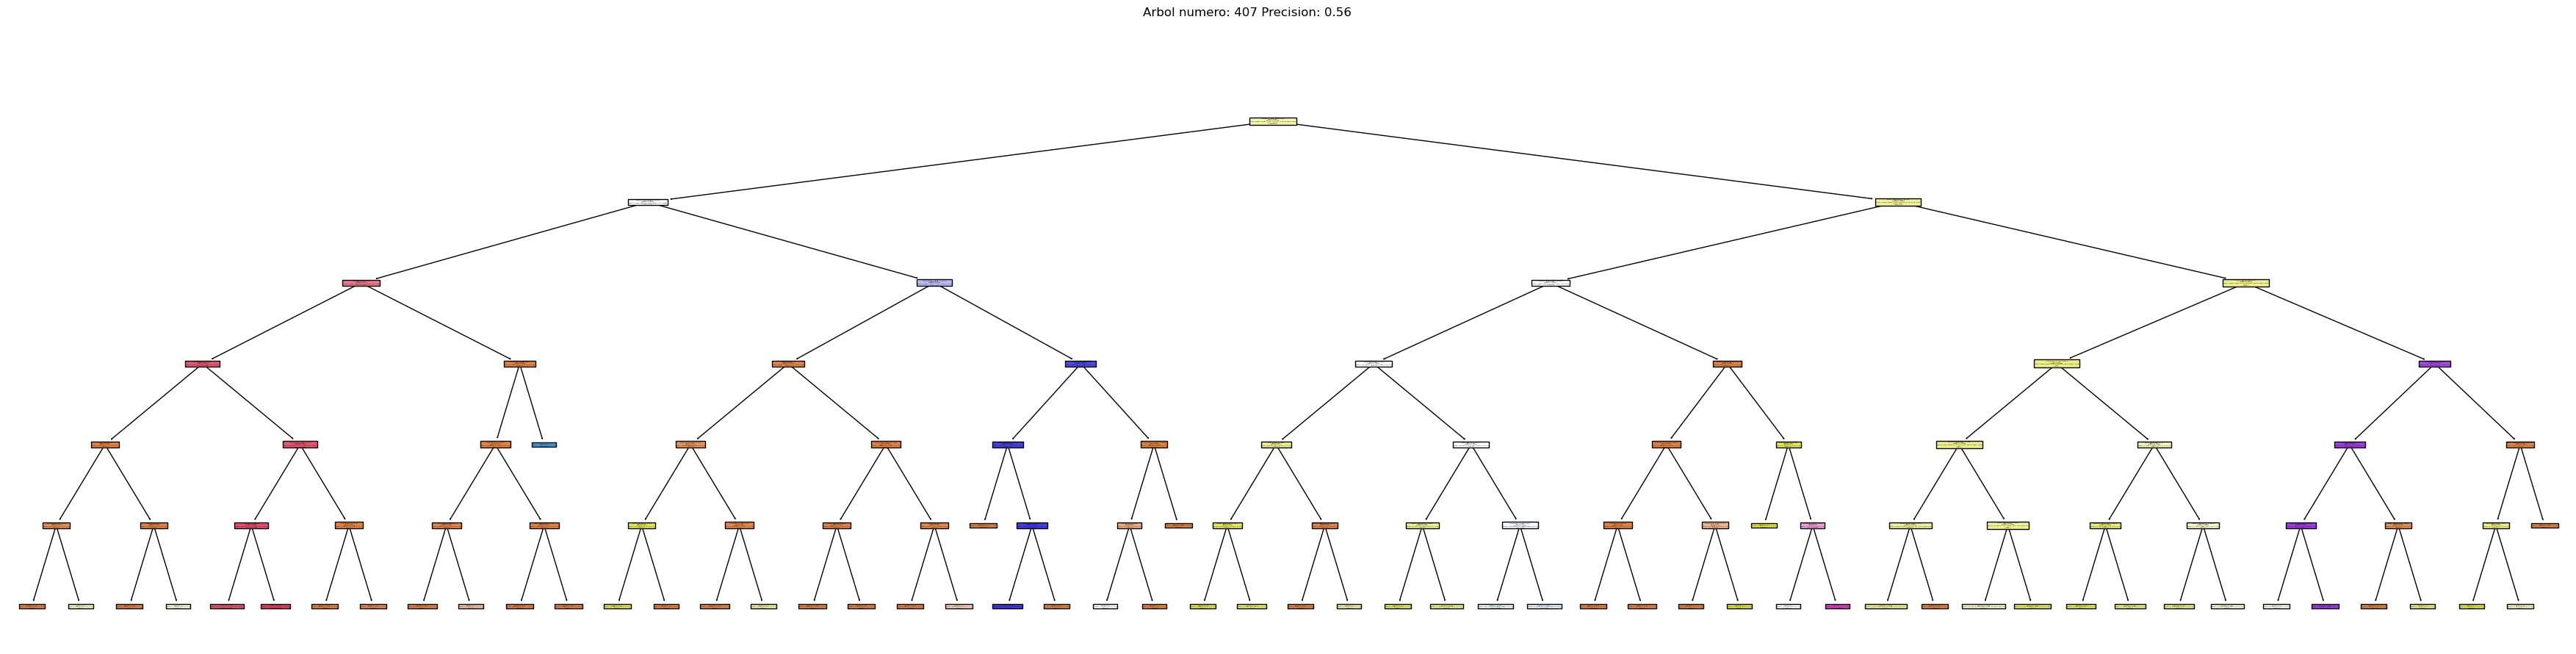

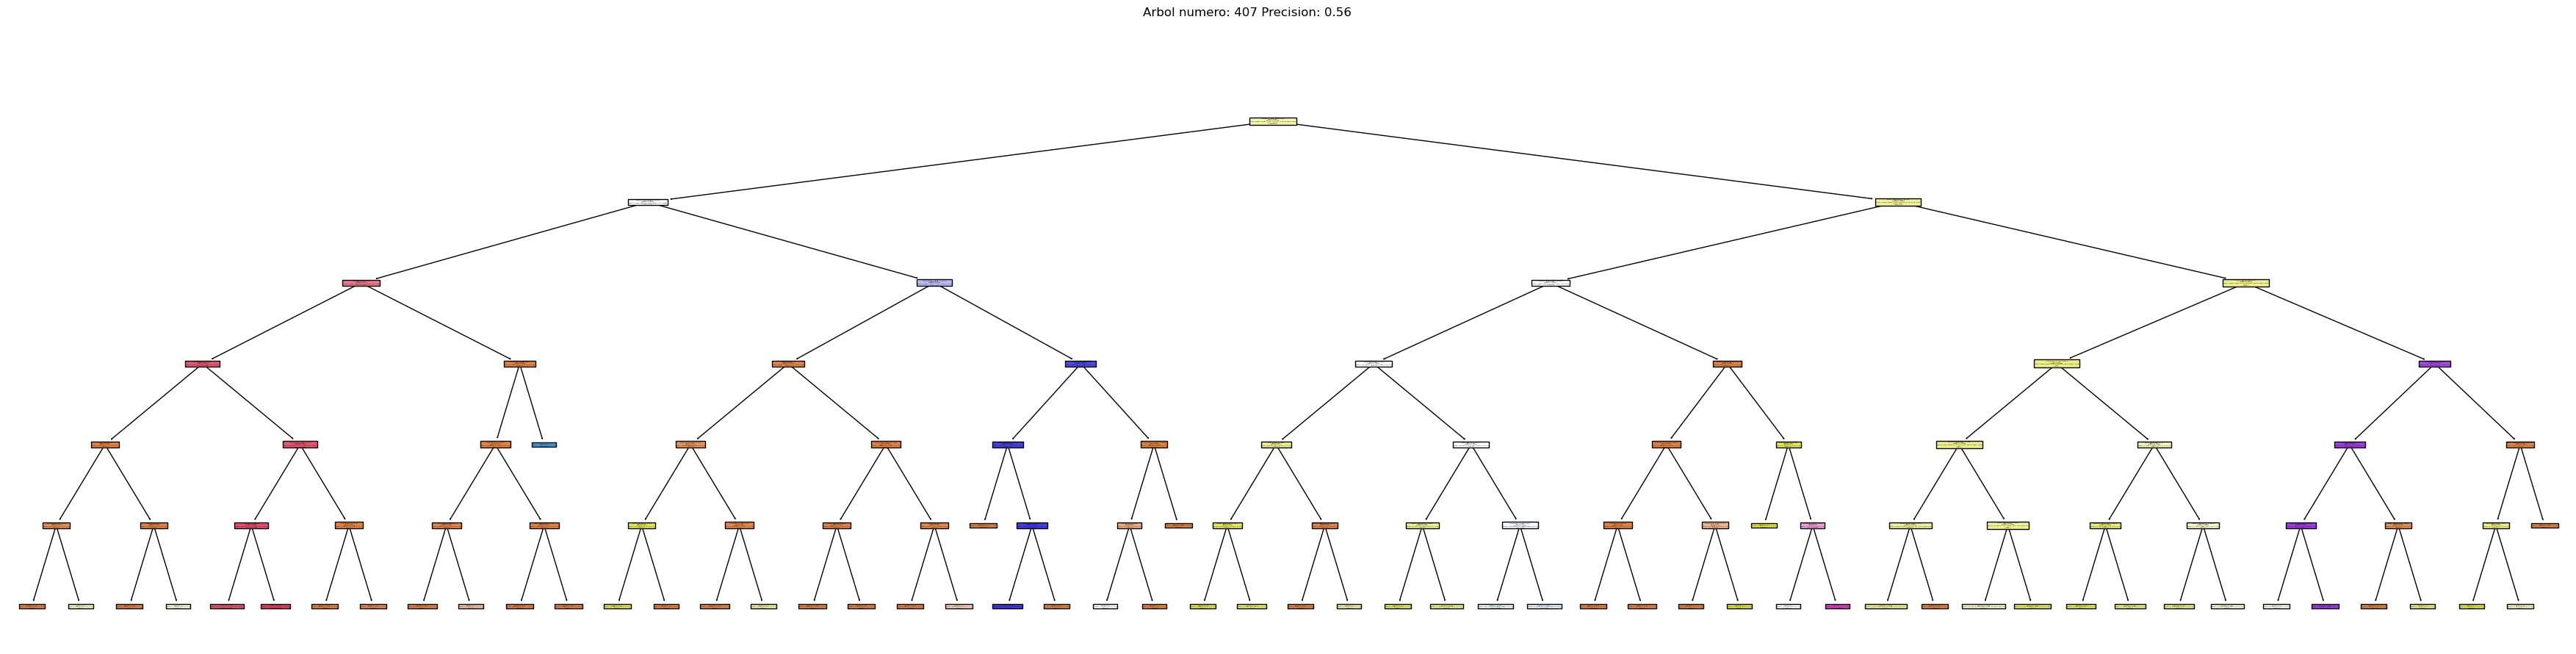

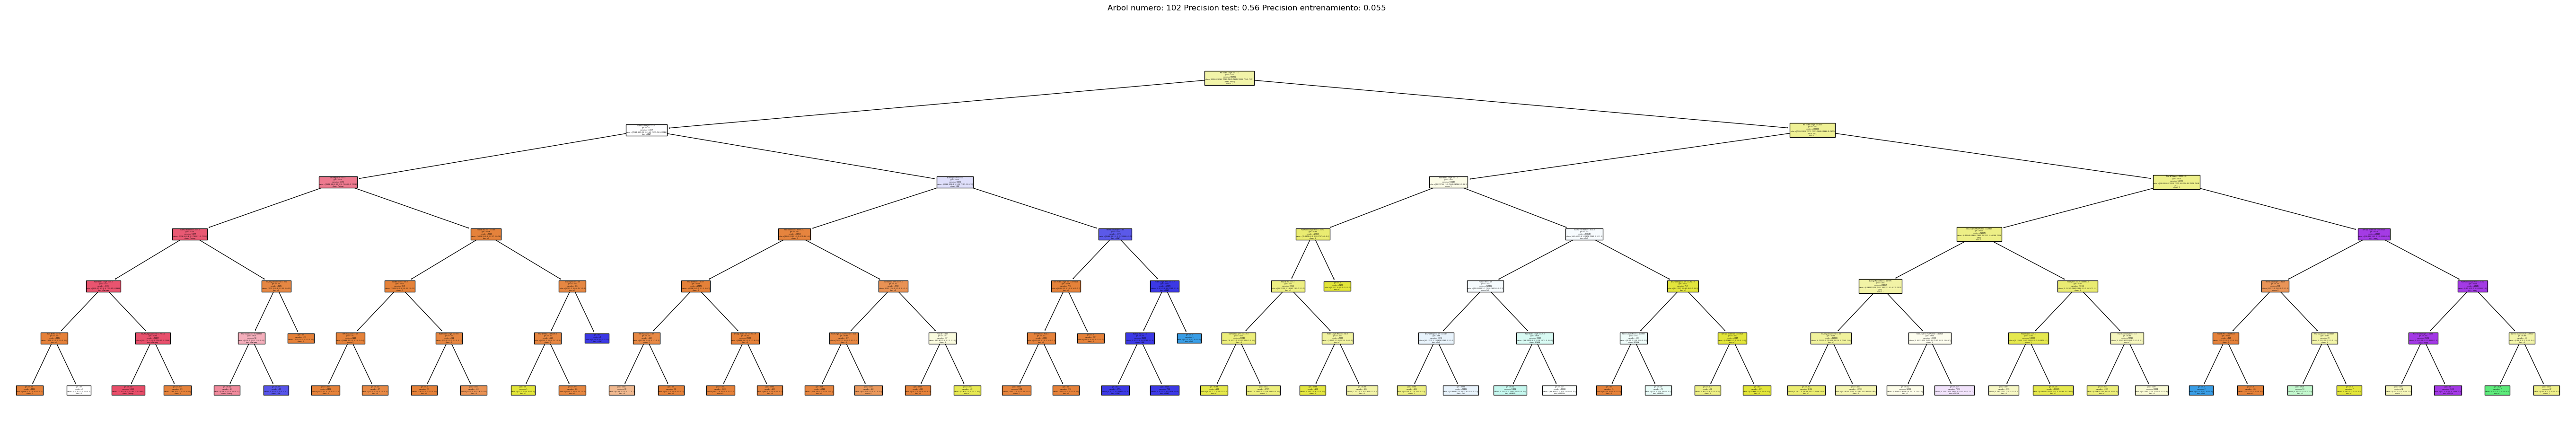

In [47]:
#skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1,figsize= (17,17))
#skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True,figsize= (17,17))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import scikitplot as skplt
from tqdm import tqdm

# Assuming X_train, X_test, Y_train, Y_test, Labels, and features are already defined
# Convert pandas dataframes to numpy arrays if necessary
X_trainArr = X_train.to_numpy() if not isinstance(X_train, np.ndarray) else X_train
X_testArr = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test

# Convert Y_train and Y_test to strings
Y_train = Y_train.astype(str)
Y_test = Y_test.astype(str)

# Concatenate Y_train and Y_test to fit the LabelEncoder on both
Y_all = np.concatenate((Y_train, Y_test), axis=0)
label_encoder = LabelEncoder()
Y_all_encoded = label_encoder.fit_transform(Y_all)

# Split Y_all_encoded back into Y_trainArr and Y_testArr
Y_trainArr = Y_all_encoded[:len(Y_train)]
Y_testArr = Y_all_encoded[len(Y_train):]

LabelsArr = label_encoder.classes_.tolist()

# Check if Y_trainArr and LabelsArr are integer arrays and within range
assert np.issubdtype(Y_trainArr.dtype, np.integer), "Y_trainArr must be an integer array"
assert Y_trainArr.min() >= 0 and Y_trainArr.max() < len(LabelsArr), "Y_trainArr values must be within the range of LabelsArr"

# Train the model
n_estimators = 500 #200
clf = RandomForestClassifier(random_state=0, n_estimators=n_estimators, max_depth=6)
clf = clf.fit(X_trainArr, Y_trainArr)

# Predict on the training data
Y_pred = clf.predict(X_trainArr)

# Mapping numerical labels to class labels
y_testree1 = [LabelsArr[i] for i in Y_trainArr]
y_predtree1 = [LabelsArr[i] for i in Y_pred]

# Verify that the lists are not empty
if not y_testree1:
    print("y_testree1 is empty!")
if not y_predtree1:
    print("y_predtree1 is empty!")

# Generate and print the classification report
print(classification_report(y_testree1, y_predtree1, digits=8, zero_division="warn"))

# Print accuracy
accuracy_modelo = accuracy_score(Y_trainArr, Y_pred)
print(accuracy_modelo)

# Plot confusion matrices
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, figsize=(17, 17))
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize=True, figsize=(17, 17))

# Find the best, median, and "pon" estimators
accuracy_ant = 0
accuracy_med = 0
accuracy_pon = 0
accuracy_pon_ant = 0
best = 0
dist_ant = 1000

for i in tqdm(range(n_estimators)):
    aux_clf = clf.estimators_[i]
    y_pred_train = aux_clf.predict(X_trainArr)
    y_pred_test = aux_clf.predict(X_testArr)
    accuracy = accuracy_score(Y_testArr, y_pred_test)
    
    accuracy_train = accuracy_score(Y_trainArr, y_pred_train)
    accuracy_pon = accuracy_train * accuracy
    
    dist = abs(accuracy_modelo - accuracy)
    
    if accuracy_pon > accuracy_pon_ant:
        pon = i
        accuracy_pon_ant = accuracy_pon
        accuracy_pon_train = accuracy_train
        accuracy_pon_test = accuracy
        
    if accuracy > accuracy_ant:
        best = i
        accuracy_ant = accuracy
        
    if dist < dist_ant:
        med = i
        accuracy_med = accuracy
        dist_ant = dist

# 1) Slice your data to 64 columns
X_trainArr = X_trainArr[:, :64]
X_testArr = X_testArr[:, :64]
features = features[:64]  # must match the data shape

# 2) Refit the model with the updated arrays
clf = RandomForestClassifier(random_state=0, n_estimators=n_estimators, max_depth=6)
clf.fit(X_trainArr, Y_trainArr)

# 3) Then plot the tree using the same "features"
fig = plt.figure(figsize=(45, 10))
_ = tree.plot_tree(clf.estimators_[best], feature_names=features, class_names=LabelsArr, filled=True)
fig.suptitle('Arbol numero: ' + str(best) + ' Precision: ' + str(round(accuracy_ant, 3)))
fig.savefig("decision_ataques.pdf")

fig2 = plt.figure(figsize=(45, 10))
_ = tree.plot_tree(clf.estimators_[med], feature_names=features, class_names=LabelsArr, filled=True)
fig2.suptitle('Arbol numero: ' + str(med) + ' Precision: ' + str(round(accuracy_med, 3)))
fig2.savefig("decision_ataques_mean.pdf")

# Ensure pon is defined and then plot the decision tree
if 'pon' in locals():
    fig3 = plt.figure(figsize=(70, 10))
    _ = tree.plot_tree(clf.estimators_[pon], feature_names=features, class_names=LabelsArr, filled=True)
    fig3.suptitle('Arbol numero: ' + str(pon) + ' Precision test: ' + str(round(accuracy_pon_test, 3)) + ' Precision entrenamiento: ' + str(round(accuracy_pon_train, 3)))
    fig3.savefig("decision_ataques_pon.pdf")

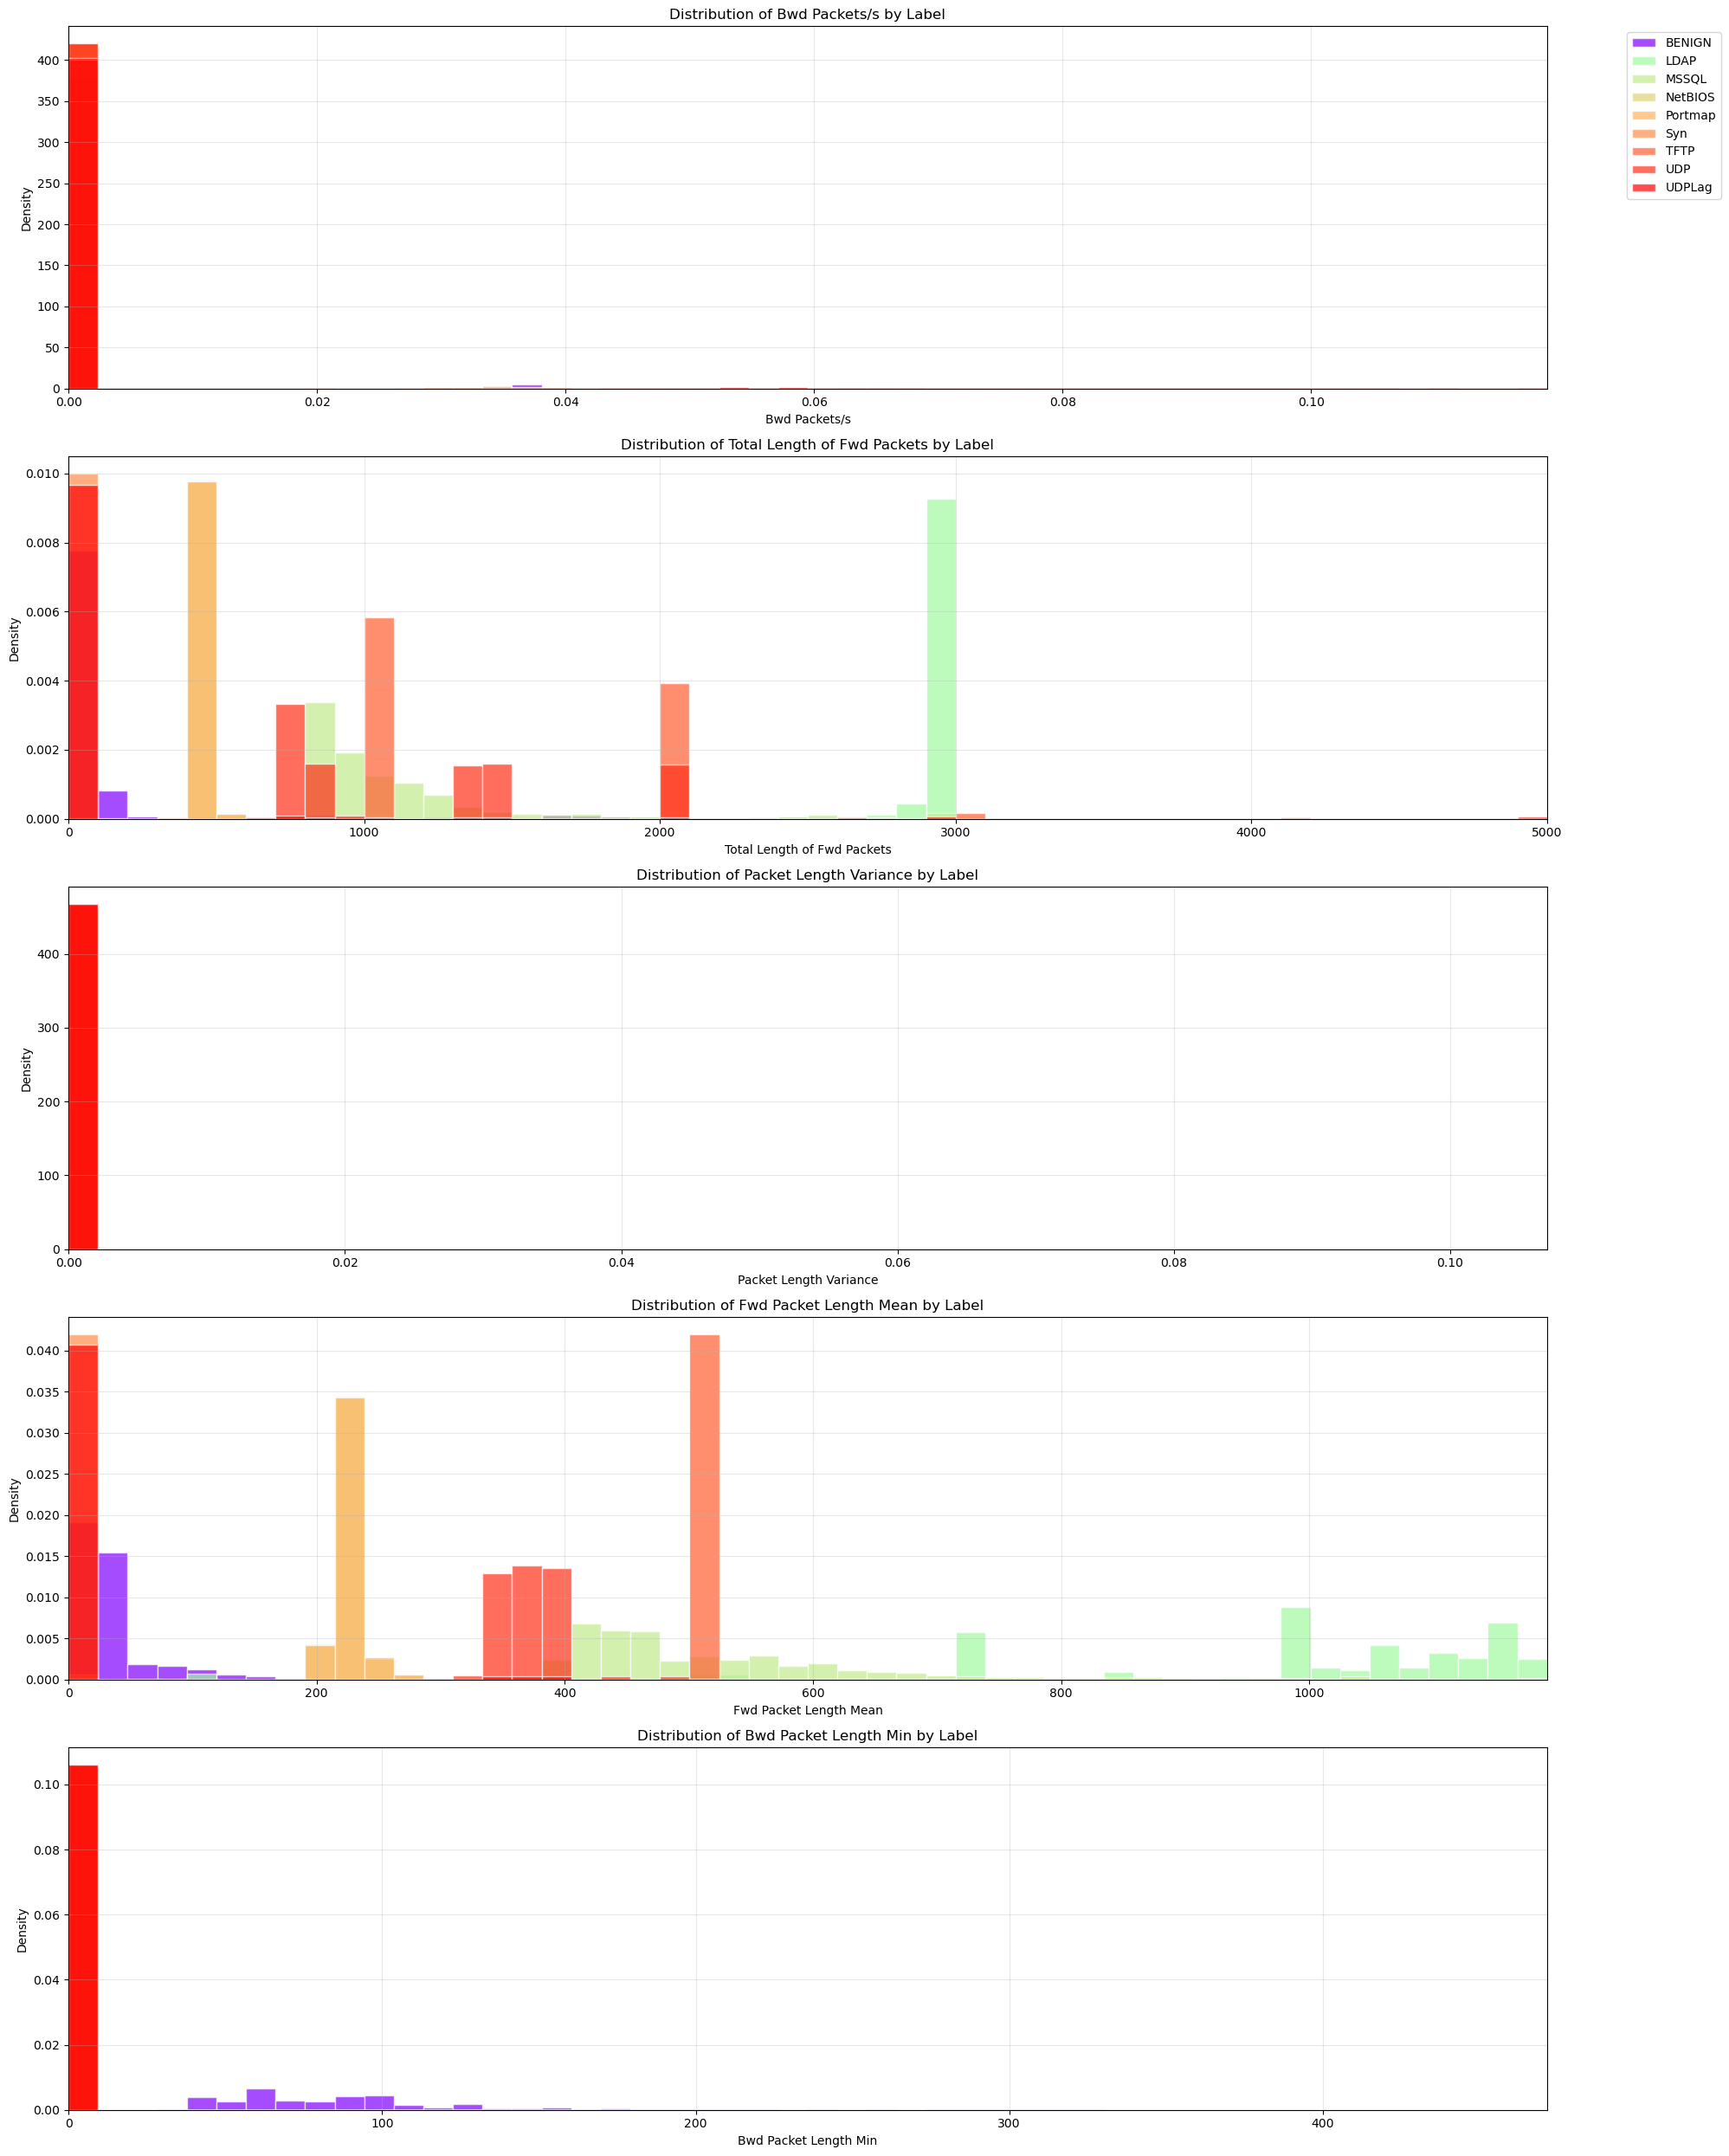


Información sobre los datos:

Característica: Bwd Packets/s
BENIGN: 19754 muestras, rango: 0.0000 - 0.1190
DrDoS_DNS: 0 muestras, rango: nan - nan
DrDoS_LDAP: 0 muestras, rango: nan - nan
DrDoS_MSSQL: 0 muestras, rango: nan - nan
DrDoS_NTP: 0 muestras, rango: nan - nan
DrDoS_NetBIOS: 0 muestras, rango: nan - nan
DrDoS_SNMP: 0 muestras, rango: nan - nan
DrDoS_SSDP: 0 muestras, rango: nan - nan
DrDoS_UDP: 0 muestras, rango: nan - nan
LDAP: 79820 muestras, rango: 0.0000 - 0.0000
MSSQL: 79493 muestras, rango: 0.0000 - 0.0000
NetBIOS: 79674 muestras, rango: 0.0000 - 0.0000
Portmap: 79413 muestras, rango: 0.0000 - 0.0000
Syn: 53746 muestras, rango: 0.0000 - 0.1189
TFTP: 79724 muestras, rango: 0.0000 - 0.0000
UDP: 79743 muestras, rango: 0.0000 - 0.0000
UDPLag: 72478 muestras, rango: 0.0000 - 0.1189

Característica: Total Length of Fwd Packets
BENIGN: 77199 muestras, rango: 0.0000 - 5000.0000
DrDoS_DNS: 0 muestras, rango: nan - nan
DrDoS_LDAP: 0 muestras, rango: nan - nan
DrDoS_MSSQL: 0 muest

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Asumimos que 'dataset' es tu DataFrame con los datos
# Si no está definido, necesitarás cargar tus datos primero

# Definir las 5 características más destacables y sus límites
top_features = [
    'Bwd Packets/s',
    'Total Length of Fwd Packets',
    'Packet Length Variance',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Min'
]
limits = [0.119, 5000.0, 0.107, 1191.5, 471.5]

# Definir los labels y colores
labels = ["BENIGN", "DrDoS_DNS", "DrDoS_LDAP", "DrDoS_MSSQL", "DrDoS_NTP", "DrDoS_NetBIOS",
          "DrDoS_SNMP", "DrDoS_SSDP", "DrDoS_UDP", "LDAP", "MSSQL", "NetBIOS", "Portmap",
          "Syn", "TFTP", "UDP", "UDPLag"]
colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))

# Crear la figura
plt.figure(figsize=(20, 25))

# Dibujar los histogramas para cada característica
for i, (feature, limit) in enumerate(zip(top_features, limits), 1):
    plt.subplot(5, 1, i)
    
    for label, color in zip(labels, colors):
        data = dataset[dataset['Label'] == label][feature]
        data = data[data <= limit]  # Aplicar el límite
        if not data.empty:
            plt.hist(data, bins=50, range=(0, limit), density=True, alpha=0.7, 
                     label=label, color=color, edgecolor='white')
    
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} by Label')
    plt.xlim(0, limit)
    plt.grid(True, alpha=0.3)
    
    if i == 1:  # Solo añadir leyenda al primer subgráfico
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Imprimir información sobre los datos
print("\nInformación sobre los datos:")
for feature, limit in zip(top_features, limits):
    print(f"\nCaracterística: {feature}")
    for label in labels:
        data = dataset[dataset['Label'] == label][feature]
        data = data[data <= limit]
        print(f"{label}: {len(data)} muestras, rango: {data.min():.4f} - {data.max():.4f}")